In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("dyutidasmahaptra/s-and-p-500-with-financial-news-headlines-20082024")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\namo\.cache\kagglehub\datasets\dyutidasmahaptra\s-and-p-500-with-financial-news-headlines-20082024\versions\1


In [2]:
# Import libraries
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from tabulate import tabulate
import json
import datetime
from datetime import date, timedelta
import os
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from tqdm import tqdm

# Set visualization style
sns.set(style='whitegrid', palette='muted', color_codes=True)

# Import additional libraries for machine learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve, log_loss, mean_squared_error, r2_score, ConfusionMatrixDisplay, roc_auc_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
import random
random.seed(42)
np.random.seed(42)
RANDOM_STATE = 42

import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')

from plot_utils import *

# SMOTE
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=RANDOM_STATE)

In [3]:
# Input file paths from local kagglehub dataset
raw_data_path = os.path.join(path, 'sp500_headlines_2008_2024.csv')

# Load the raw data
def load_raw_data():
    raw_data = pd.read_csv(raw_data_path)
    raw_data['Date'] = pd.to_datetime(raw_data['Date'])
    return raw_data

sp500_headlines_2008_2024 = load_raw_data()
sp500_headlines_2008_2024

Title       Date       CP
0       JPMorgan Predicts 2008 Will Be "Nothing But Net" 2008-01-02  1447.16
1      Dow Tallies Biggest First-session-of-year Poin... 2008-01-02  1447.16
2                       2008 predictions for the S&P 500 2008-01-02  1447.16
3      U.S. Stocks Higher After Economic Data, Monsan... 2008-01-03  1447.16
4      U.S. Stocks Climb As Hopes Increase For More F... 2008-01-07  1416.18
...                                                  ...        ...      ...
19122          REITs vs. Stocks: What Does the Data Say? 2024-03-04  5130.95
19123  Nasdaq Index, Dow Jones, S&P 500 News: Futures... 2024-03-04  5130.95
19124  Nasdaq 100, Dow Jones, S&P 500 News: Cautious ... 2024-03-04  5130.95
19125  Bank of America boosts S&P 500 target to 5,400... 2024-03-04  5130.95
19126  S&P 500 Gains and Losses Today: Tesla Shares T... 2024-03-04  5130.95

[19127 rows x 3 columns]

In [4]:
sp500_headlines_2008_2024.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19127 entries, 0 to 19126
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Title   19127 non-null  object        
 1   Date    19127 non-null  datetime64[ns]
 2   CP      19127 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 448.4+ KB


In [5]:
sp500_headlines_2008_2024.duplicated().sum()

974

<Axes: >

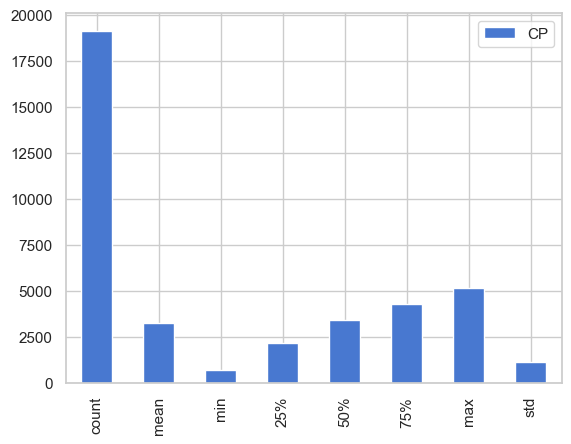

In [6]:
sp500_headlines_2008_2024.describe().plot(kind='bar')

<Axes: xlabel='Date', ylabel='CP'>

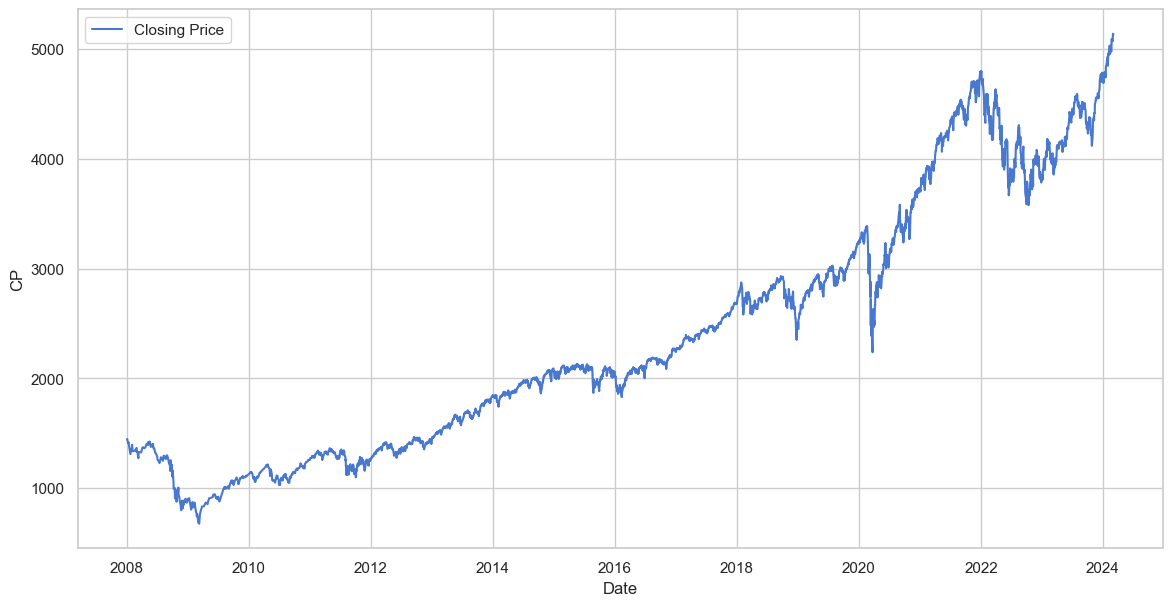

In [7]:
# Plot index prices over time
plt.figure(figsize=(14, 7))
sns.lineplot(x='Date', y='CP', data=sp500_headlines_2008_2024, label='Closing Price')

Numeric columns: Index(['CP'], dtype='object')


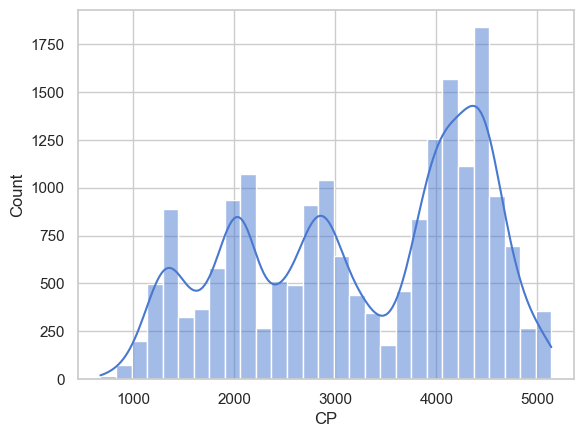

In [8]:
numeric_cols = sp500_headlines_2008_2024.select_dtypes(include=['number']).columns
print("Numeric columns:", numeric_cols)

for col in numeric_cols:
    sns.histplot(x=col, data=sp500_headlines_2008_2024, kde=True)
    plt.show()

## Prepare sentiment data

In [9]:
# Limit the dataset by number of rows for testing
max_rows = len(sp500_headlines_2008_2024)

In [ ]:
# Load FinBERT (pre-trained for financial sentiment)
tokenizer = AutoTokenizer.from_pretrained('ProsusAI/finbert')
model = AutoModelForSequenceClassification.from_pretrained('ProsusAI/finbert')

def get_sentiment_score(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True)
    outputs = model(**inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)

    # Custom score: Positive = +1, Neutral = 0, Negative = -1
    score = (probs[0][2] - probs[0][0]).item()
    return score

# Generate sentiment scores
# For testing purposes, we can limit the number of rows processed
sp500_headlines_2008_2024_test = sp500_headlines_2008_2024.head(max_rows)
tqdm.pandas()
sp500_headlines_2008_2024_test['sentiment_score_finbert'] = sp500_headlines_2008_2024_test['Title'].progress_apply(get_sentiment_score)

print(sp500_headlines_2008_2024_test[['Date', 'Title', 'sentiment_score_finbert']].head())

100%|██████████| 19127/19127 [12:31<00:00, 25.44it/s]

        Date                                              Title  \
0 2008-01-02   JPMorgan Predicts 2008 Will Be "Nothing But Net"   
1 2008-01-02  Dow Tallies Biggest First-session-of-year Poin...   
2 2008-01-02                   2008 predictions for the S&P 500   
3 2008-01-03  U.S. Stocks Higher After Economic Data, Monsan...   
4 2008-01-07  U.S. Stocks Climb As Hopes Increase For More F...   

   sentiment_score_finbert  
0                -0.415776  
1                -0.950723  
2                -0.069877  
3                 0.797434  
4                 0.421510  


In [11]:
# Define volatility period
volatility_period = [5, 22, 66, 132]  # 5 days, 22 days (1 month), 66 days (3 months), 132 days (6 months)

# Compute avg daily sentiment (you already do this)
daily_sentiment = sp500_headlines_2008_2024_test.groupby('Date')['sentiment_score_finbert'].mean().reset_index()
daily_sentiment.rename(columns={'sentiment_score_finbert': 'avg_sentiment_score_a_day'}, inplace=True)

# Compute cross-sectional sentiment dispersion (std dev of headline sentiment per day)
cross_sectional_dispersion = sp500_headlines_2008_2024_test.groupby('Date')['sentiment_score_finbert'].std().reset_index()
cross_sectional_dispersion.rename(columns={'sentiment_score_finbert': 'cross_sectional_sentiment_dispersion'}, inplace=True)
cross_sectional_dispersion['cross_sectional_sentiment_dispersion'].fillna(0, inplace=True)

daily_sentiment = daily_sentiment.merge(cross_sectional_dispersion, on='Date', how='left')

# # Daily average sentiment
# daily_sentiment = sp500_headlines_2008_2024_test.groupby('Date')['sentiment_score_finbert'].mean().reset_index()
# daily_sentiment.rename(columns={'sentiment_score_finbert': 'avg_sentiment_score_a_day'}, inplace=True)

# Calculate rolling n-day sentiment volatility (std deviation)
# a week, a month, a quarter, and half a year
for n in volatility_period:
    daily_sentiment[f'{n}_day_sentiment_volatility'] = daily_sentiment['avg_sentiment_score_a_day'].rolling(window=n).std()
    daily_sentiment[f'{n}_day_dispersion_volatility'] = daily_sentiment['cross_sectional_sentiment_dispersion'].rolling(window=n).std()


print(daily_sentiment)

           Date  avg_sentiment_score_a_day  \
0    2008-01-02                  -0.478792   
1    2008-01-03                   0.797434   
2    2008-01-07                   0.421510   
3    2008-01-09                  -0.375605   
4    2008-01-10                   0.259898   
...         ...                        ...   
3502 2024-02-27                  -0.059128   
3503 2024-02-28                  -0.095197   
3504 2024-02-29                   0.062807   
3505 2024-03-01                   0.322507   
3506 2024-03-04                  -0.157328   

      cross_sectional_sentiment_dispersion  5_day_sentiment_volatility  \
0                                 0.443791                         NaN   
1                                 0.000000                         NaN   
2                                 0.000000                         NaN   
3                                 0.627466                         NaN   
4                                 0.000000                    0.541630   
...

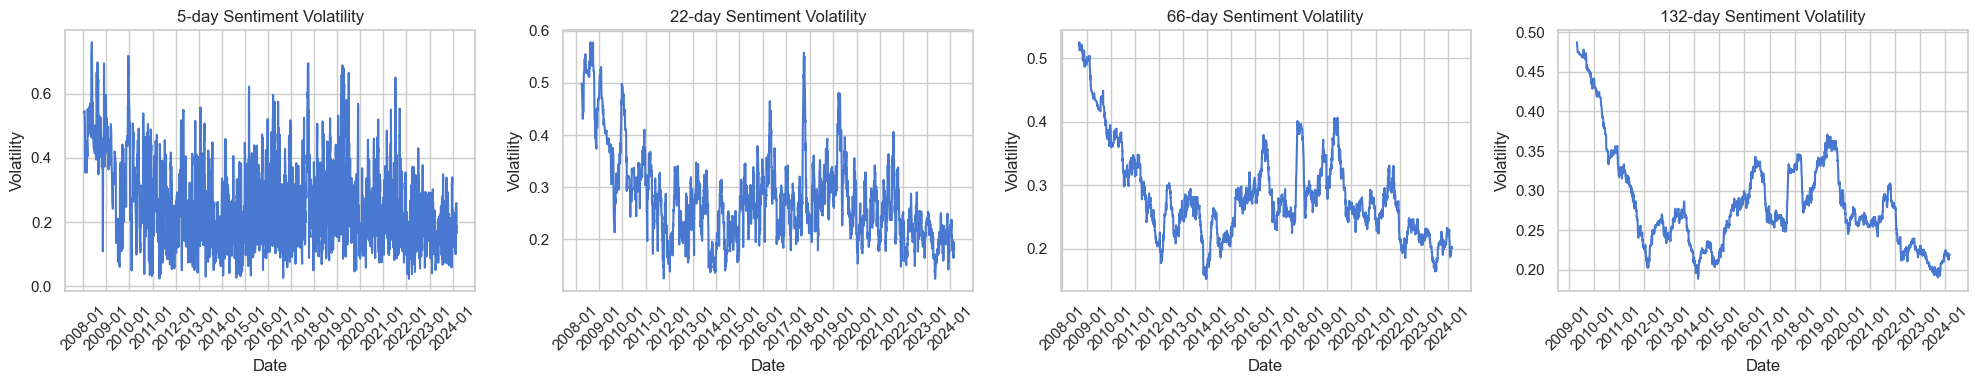

In [12]:
n_cols = 4
n_rows = int(np.ceil(len(volatility_period) / n_cols))

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

for i, n in enumerate(volatility_period):
    sns.lineplot(x='Date', y=f'{n}_day_sentiment_volatility', data=daily_sentiment, ax=axes[i])
    axes[i].set_title(f'{n}-day Sentiment Volatility')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Volatility')
    axes[i].xaxis.set_major_locator(mdates.YearLocator())
    axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    axes[i].tick_params(axis='x', rotation=45)

for j in range(len(volatility_period), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


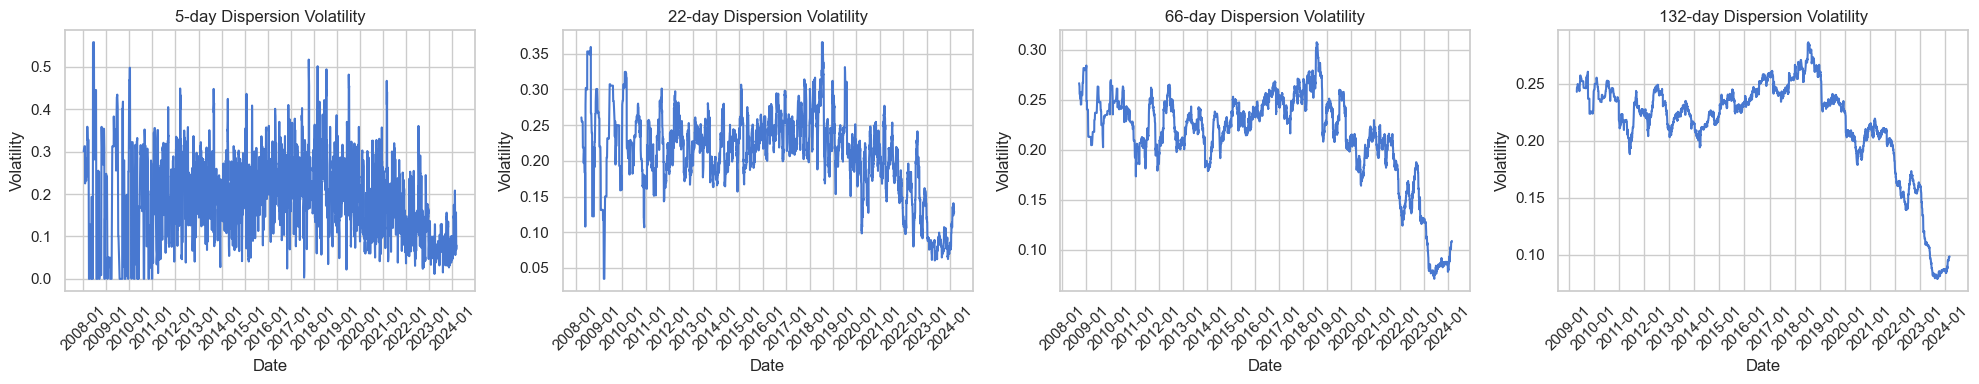

In [13]:
n_cols = 4
n_rows = int(np.ceil(len(volatility_period) / n_cols))

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

for i, n in enumerate(volatility_period):
    sns.lineplot(x='Date', y=f'{n}_day_dispersion_volatility', data=daily_sentiment, ax=axes[i])
    axes[i].set_title(f'{n}-day Dispersion Volatility')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Volatility')
    axes[i].xaxis.set_major_locator(mdates.YearLocator())
    axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    axes[i].tick_params(axis='x', rotation=45)

for j in range(len(volatility_period), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [14]:
# Percentages of each sentiment group by >0, <0, and ==0
def sentiment_percentage(df, column):
    total = len(df)
    positive = len(df[df[column] > 0])
    negative = len(df[df[column] < 0])
    neutral = len(df[df[column] == 0])
    
    return {
        'positive': positive / total * 100,
        'negative': negative / total * 100,
        'neutral': neutral / total * 100
    }

sentiment_stats = sentiment_percentage(daily_sentiment, 'avg_sentiment_score_a_day')
print("Sentiment Statistics:", sentiment_stats)

Sentiment Statistics: {'positive': 45.822640433418876, 'negative': 54.17735956658112, 'neutral': 0.0}


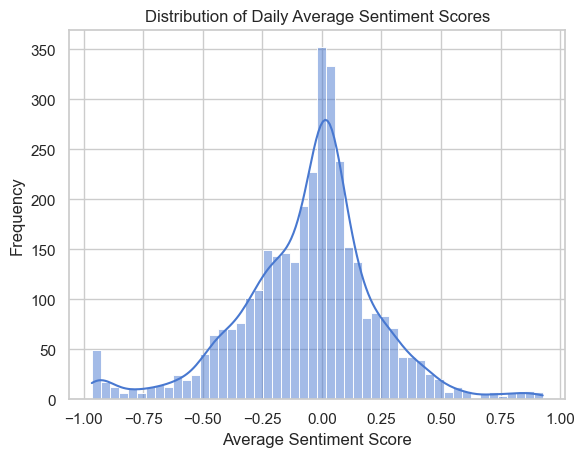

In [15]:
# Plot sentiment distribution
sns.histplot(daily_sentiment['avg_sentiment_score_a_day'], bins=50, kde=True)
plt.title('Distribution of Daily Average Sentiment Scores')
plt.xlabel('Average Sentiment Score')
plt.ylabel('Frequency')
plt.show()

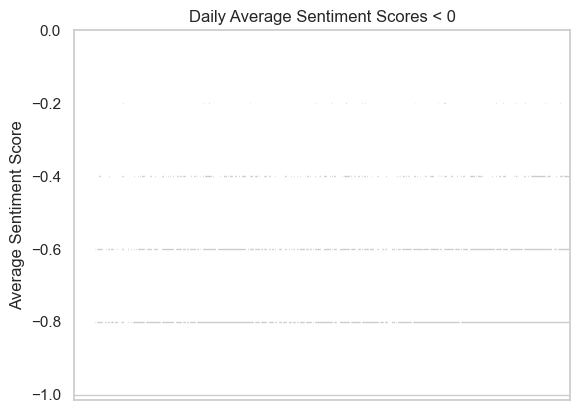

In [16]:
# Plot bar of sentiment which is <0 over time and set X axes to show year only
ax = sns.barplot(x='Date', y='avg_sentiment_score_a_day', data=daily_sentiment[daily_sentiment['avg_sentiment_score_a_day'] < 0])
ax.get_xaxis().set_visible(False)
plt.title('Daily Average Sentiment Scores < 0')
plt.ylabel('Average Sentiment Score')
plt.show()

## Prepare market data

In [17]:
# Drop the 'Title' column
df = sp500_headlines_2008_2024_test.drop(columns=['Title', 'sentiment_score_finbert'])

# Group by 'Date' and aggregate numeric columns
daily_data = df.groupby('Date', as_index=False).mean()
merged_data = pd.merge(daily_sentiment, daily_data[['Date', 'CP']], on='Date', how='left')

# Download daily OHLCV for S&P 500 (^GSPC) from yfinance
ohlcv = yf.download("^GSPC", start=merged_data['Date'].min(), end=merged_data['Date'].max())

# Flatten 
ohlcv = ohlcv.reset_index()
ohlcv.columns = [col[0] if isinstance(col, tuple) else col for col in ohlcv.columns]
ohlcv['Date'] = pd.to_datetime(ohlcv['Date'])
merged_data['Date'] = pd.to_datetime(merged_data['Date'])

# Merge OHLCV into merged_data
merged_data = pd.merge(merged_data, ohlcv[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']],
                       on='Date', how='left')

# Drop CP column as it is redundant with Close
merged_data.drop(columns=['CP'], inplace=True)

print(merged_data.columns)

[*********************100%***********************]  1 of 1 completed

Index(['Date', 'avg_sentiment_score_a_day',
       'cross_sectional_sentiment_dispersion', '5_day_sentiment_volatility',
       '5_day_dispersion_volatility', '22_day_sentiment_volatility',
       '22_day_dispersion_volatility', '66_day_sentiment_volatility',
       '66_day_dispersion_volatility', '132_day_sentiment_volatility',
       '132_day_dispersion_volatility', 'Open', 'High', 'Low', 'Close',
       'Volume'],
      dtype='object')


In [18]:
# Function to label future crash events based on future close prices
def add_future_crash_label(df, look_ahead_days=252, drop_threshold=0.9, close_col="Close"):
    df = df.copy()
    df["future_close"] = df[close_col].shift(-look_ahead_days)
    df["future_crash"] = (df["future_close"] < df[close_col] * drop_threshold).astype(int)
    return df

# Define look-ahead days and drop threshold
look_ahead_days = 132

# Future close price from today is less than drop_threshold% of the current close price
drop_threshold = 0.9

sp500_headlines_2008_2024_label_added = add_future_crash_label(merged_data, look_ahead_days, drop_threshold)
sp500_headlines_2008_2024_label_added

Date  avg_sentiment_score_a_day  \
0    2008-01-02                  -0.478792   
1    2008-01-03                   0.797434   
2    2008-01-07                   0.421510   
3    2008-01-09                  -0.375605   
4    2008-01-10                   0.259898   
...         ...                        ...   
3502 2024-02-27                  -0.059128   
3503 2024-02-28                  -0.095197   
3504 2024-02-29                   0.062807   
3505 2024-03-01                   0.322507   
3506 2024-03-04                  -0.157328   

      cross_sectional_sentiment_dispersion  5_day_sentiment_volatility  \
0                                 0.443791                         NaN   
1                                 0.000000                         NaN   
2                                 0.000000                         NaN   
3                                 0.627466                         NaN   
4                                 0.000000                    0.541630   
...                                    ...                         ...   
3502                              0.578089                    0.230249   
3503                              0.606199                    0.259137   
3504                              0.516911                    0.216242   
3505                              0.484517                    0.163706   
3506                              0.685760                    0.189856   

      5_day_dispersion_volatility  22_day_sentiment_volatility  \
0                             NaN                          NaN   
1                             NaN                          NaN   
2                             NaN                          NaN   
3                             NaN                          NaN   
4                        0.300477                          NaN   
...                           ...                          ...   
3502                     0.125885                     0.193825   
3503                     0.119988                     0.187380   
3504                     0.085630                     0.179988   
3505                     0.069304                     0.185860   
3506                     0.078755                     0.179960   

      22_day_dispersion_volatility  66_day_sentiment_volatility  \
0                              NaN                          NaN   
1                              NaN                          NaN   
2                              NaN                          NaN   
3                              NaN                          NaN   
4                              NaN                          NaN   
...                            ...                          ...   
3502                      0.133293                     0.201618   
3503                      0.133423                     0.201703   
3504                      0.129933                     0.200231   
3505                      0.126689                     0.201689   
3506                      0.129025                     0.202788   

      66_day_dispersion_volatility  132_day_sentiment_volatility  \
0                              NaN                           NaN   
1                              NaN                           NaN   
2                              NaN                           NaN   
3                              NaN                           NaN   
4                              NaN                           NaN   
...                            ...                           ...   
3502                      0.107730                      0.217954   
3503                      0.107667                      0.217296   
3504                      0.107722                      0.217601   
3505                      0.108198                      0.219525   
3506                      0.108999                      0.219509   

      132_day_dispersion_volatility         Open         High          Low  \
0                               NaN  1467.969971  1471.770020  1442.069946  

In [19]:
# Count future crash
crashed = sp500_headlines_2008_2024_label_added['future_crash'].value_counts()[1]
not_crashed = sp500_headlines_2008_2024_label_added['future_crash'].value_counts()[0]
print(crashed, not_crashed)

print(f'Ratio of crashed: {round(crashed/(crashed + not_crashed) * 100, 2)} %')

206 3301
Ratio of crashed: 5.87 %


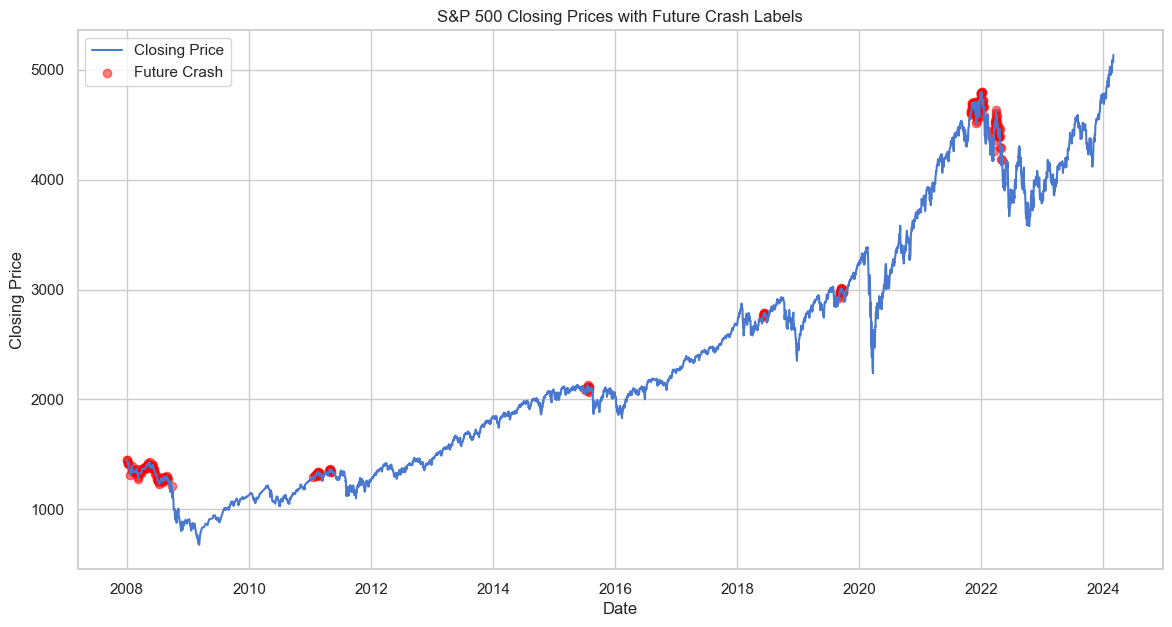

In [20]:
# Plot close prices and future crash labels
plt.figure(figsize=(14, 7))
sns.lineplot(x='Date', y='Close', data=sp500_headlines_2008_2024_label_added, label='Closing Price')
plt.scatter(sp500_headlines_2008_2024_label_added[sp500_headlines_2008_2024_label_added['future_crash'] == 1]['Date'],
            sp500_headlines_2008_2024_label_added[sp500_headlines_2008_2024_label_added['future_crash'] == 1]['Close'],
            color='red', label='Future Crash',alpha=0.5)
plt.title('S&P 500 Closing Prices with Future Crash Labels')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

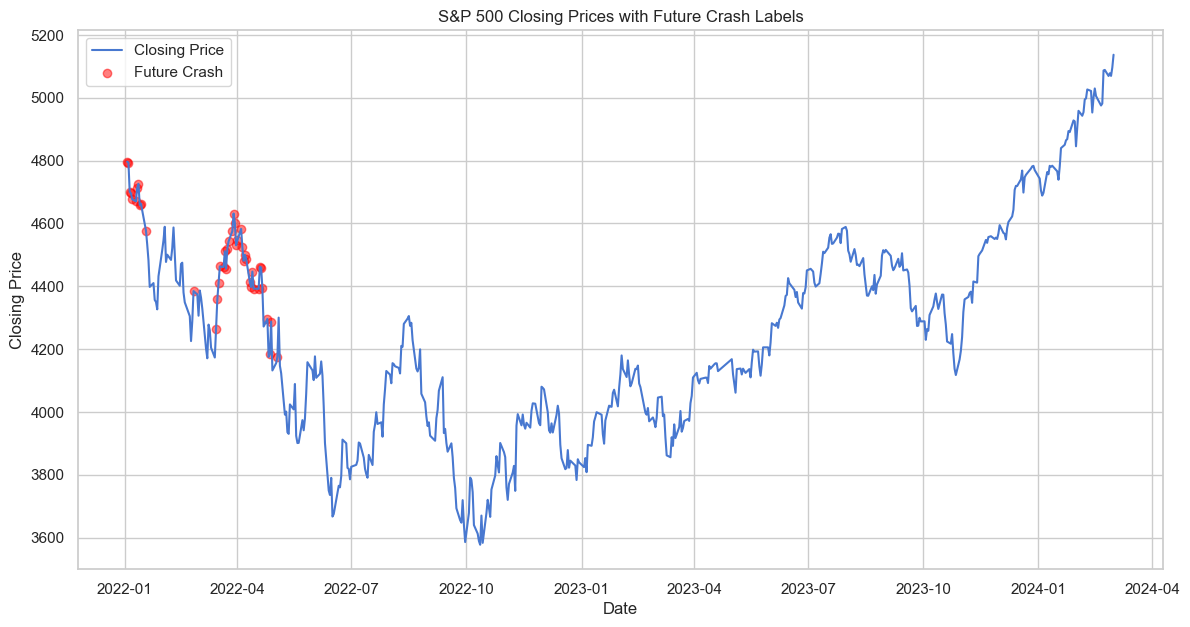

In [21]:
# Plot close prices and future crash labels
# Plot after 2022
sp500_headlines_2008_2024_label_added_after_2022 = sp500_headlines_2008_2024_label_added[sp500_headlines_2008_2024_label_added['Date'] >= '2022-01-01']

plt.figure(figsize=(14, 7))
sns.lineplot(x='Date', y='Close', data=sp500_headlines_2008_2024_label_added_after_2022, label='Closing Price')
plt.scatter(sp500_headlines_2008_2024_label_added_after_2022[sp500_headlines_2008_2024_label_added_after_2022['future_crash'] == 1]['Date'],
            sp500_headlines_2008_2024_label_added_after_2022[sp500_headlines_2008_2024_label_added_after_2022['future_crash'] == 1]['Close'],
            color='red', label='Future Crash',alpha=0.5)
plt.title('S&P 500 Closing Prices with Future Crash Labels')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

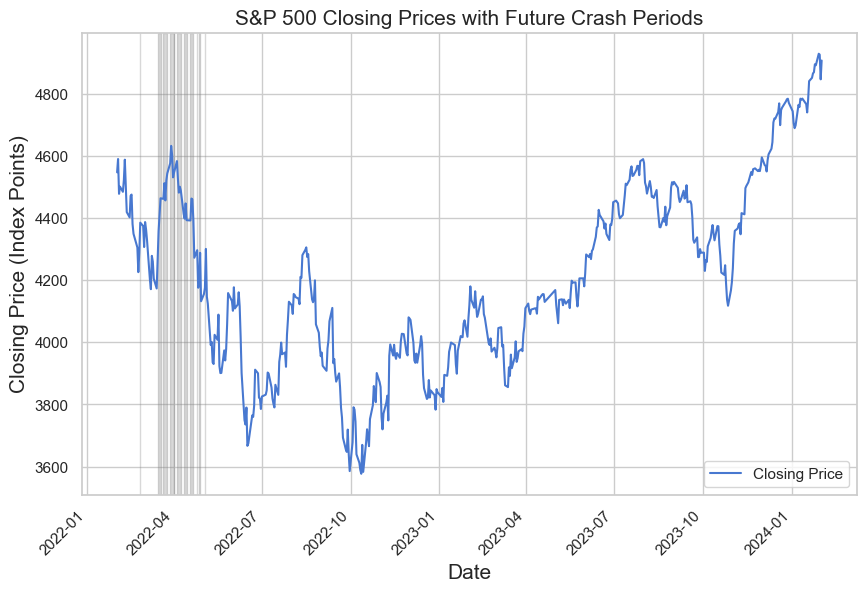

In [22]:
# Plot close prices and future crash labels as grey areas
sp500_headlines_2008_2024_label_added_after_2022 = sp500_headlines_2008_2024_label_added[
    (sp500_headlines_2008_2024_label_added['Date'] >= '2022-02-01') &
    (sp500_headlines_2008_2024_label_added['Date'] <= '2024-02-01')
]


plt.figure(figsize=(10, 6))
sns.lineplot(x='Date', y='Close', data=sp500_headlines_2008_2024_label_added_after_2022, label='Closing Price')

# Identify crash periods
crash_periods = sp500_headlines_2008_2024_label_added_after_2022[
    sp500_headlines_2008_2024_label_added_after_2022['future_crash'] == 1
]

# Group consecutive crash days into continuous intervals
crash_groups = (crash_periods['Date'].diff().dt.days > 1).cumsum()
for _, group in crash_periods.groupby(crash_groups):
    plt.axvspan(group['Date'].iloc[0], group['Date'].iloc[-1], color='grey', alpha=0.3)

plt.title('S&P 500 Closing Prices with Future Crash Periods', fontsize=15)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Closing Price (Index Points)', fontsize=15)
plt.xticks(rotation=45, ha="right")
plt.legend()
plt.show()

In [23]:
# Count total data points per year
total_per_year = sp500_headlines_2008_2024_label_added['Date'].dt.year.value_counts().sort_index()

# Count crashed data points per year
crashed_per_year = (
    sp500_headlines_2008_2024_label_added[sp500_headlines_2008_2024_label_added['future_crash'] == 1]['Date']
    .dt.year.value_counts()
    .sort_index()
)

# Combine into a DataFrame
yearly_stats = pd.DataFrame({
    'Total Data Points': total_per_year,
    'Crashed Data Points': crashed_per_year
})

# Fill missing years with 0 crashes
yearly_stats['Crashed Data Points'] = yearly_stats['Crashed Data Points'].fillna(0).astype(int)

print(yearly_stats)

      Total Data Points  Crashed Data Points
Date                                        
2008                106                   64
2009                 90                    0
2010                132                    0
2011                216                   20
2012                241                    0
2013                241                    0
2014                242                    0
2015                243                   10
2016                240                    0
2017                228                    0
2018                243                    7
2019                248                   18
2020                249                    0
2021                250                   44
2022                251                   43
2023                244                    0
2024                 43                    0


In [24]:
# Ratio of data points before and after 2022
before_2022 = len(sp500_headlines_2008_2024_label_added[sp500_headlines_2008_2024_label_added['Date'] < '2022-01-01'])
after_2022 = len(sp500_headlines_2008_2024_label_added[sp500_headlines_2008_2024_label_added['Date'] >= '2022-01-01'])
print(f"Data points before 2022: {before_2022}, after 2022: {after_2022}") 
print(f"Ratio of data points before 2022: {before_2022 / (before_2022 + after_2022) * 100:.2f}%")

# Ratio of crash data before and after 2022
crashed_before_2022 = len(sp500_headlines_2008_2024_label_added[(sp500_headlines_2008_2024_label_added['Date'] < '2022-01-01') & (sp500_headlines_2008_2024_label_added['future_crash'] == 1)])
crashed_after_2022 = len(sp500_headlines_2008_2024_label_added[(sp500_headlines_2008_2024_label_added['Date'] >= '2022-01-01') & (sp500_headlines_2008_2024_label_added['future_crash'] == 1)])
print(f"Crashes before 2022: {crashed_before_2022}, after 2022: {crashed_after_2022}")
print(f"Ratio of crashes before 2022: {crashed_before_2022 / (crashed_before_2022 + crashed_after_2022) * 100:.2f}%")

# Ratio of total crashes among all
total_crashes = crashed_before_2022 + crashed_after_2022
print(f"Total crashes: {total_crashes}")
print(f"Ratio of total crashes: {total_crashes / (before_2022 + after_2022) * 100:.2f}%")

Data points before 2022: 2969, after 2022: 538
Ratio of data points before 2022: 84.66%
Crashes before 2022: 163, after 2022: 43
Ratio of crashes before 2022: 79.13%
Total crashes: 206
Ratio of total crashes: 5.87%


In [25]:
# From the info above, it seems to be good if we split the data into 2008-2021, 2022-somewhere in the middle of 2022 for validating, and the rest for testing.
# Explore this hypothesis
train_data = sp500_headlines_2008_2024_label_added[sp500_headlines_2008_2024_label_added['Date'] < '2022-01-01']

# Summarize crash date from the rest of the data (exclude training data)
crash_in_rest_data = sp500_headlines_2008_2024_label_added[(sp500_headlines_2008_2024_label_added['Date'] >= '2022-01-01') & (sp500_headlines_2008_2024_label_added['future_crash'] == 1)]
print(crash_in_rest_data['Date'].describe())

count                               43
mean     2022-03-13 11:43:15.348837120
min                2022-01-03 00:00:00
25%                2022-02-06 00:00:00
50%                2022-03-28 00:00:00
75%                2022-04-11 12:00:00
max                2022-05-03 00:00:00
Name: Date, dtype: object


In [26]:
# Calculate daily returns
sp500_headlines_2008_2024_label_added['daily_return'] = sp500_headlines_2008_2024_label_added['Close'].pct_change() * 100  # Convert to percentage

# Prepare market data
market_sentiment_data = sp500_headlines_2008_2024_label_added.copy()
market_sentiment_data['Date'] = pd.to_datetime(market_sentiment_data['Date'])

market_sentiment_data

Date  avg_sentiment_score_a_day  \
0    2008-01-02                  -0.478792   
1    2008-01-03                   0.797434   
2    2008-01-07                   0.421510   
3    2008-01-09                  -0.375605   
4    2008-01-10                   0.259898   
...         ...                        ...   
3502 2024-02-27                  -0.059128   
3503 2024-02-28                  -0.095197   
3504 2024-02-29                   0.062807   
3505 2024-03-01                   0.322507   
3506 2024-03-04                  -0.157328   

      cross_sectional_sentiment_dispersion  5_day_sentiment_volatility  \
0                                 0.443791                         NaN   
1                                 0.000000                         NaN   
2                                 0.000000                         NaN   
3                                 0.627466                         NaN   
4                                 0.000000                    0.541630   
...                                    ...                         ...   
3502                              0.578089                    0.230249   
3503                              0.606199                    0.259137   
3504                              0.516911                    0.216242   
3505                              0.484517                    0.163706   
3506                              0.685760                    0.189856   

      5_day_dispersion_volatility  22_day_sentiment_volatility  \
0                             NaN                          NaN   
1                             NaN                          NaN   
2                             NaN                          NaN   
3                             NaN                          NaN   
4                        0.300477                          NaN   
...                           ...                          ...   
3502                     0.125885                     0.193825   
3503                     0.119988                     0.187380   
3504                     0.085630                     0.179988   
3505                     0.069304                     0.185860   
3506                     0.078755                     0.179960   

      22_day_dispersion_volatility  66_day_sentiment_volatility  \
0                              NaN                          NaN   
1                              NaN                          NaN   
2                              NaN                          NaN   
3                              NaN                          NaN   
4                              NaN                          NaN   
...                            ...                          ...   
3502                      0.133293                     0.201618   
3503                      0.133423                     0.201703   
3504                      0.129933                     0.200231   
3505                      0.126689                     0.201689   
3506                      0.129025                     0.202788   

      66_day_dispersion_volatility  132_day_sentiment_volatility  \
0                              NaN                           NaN   
1                              NaN                           NaN   
2                              NaN                           NaN   
3                              NaN                           NaN   
4                              NaN                           NaN   
...                            ...                           ...   
3502                      0.107730                      0.217954   
3503                      0.107667                      0.217296   
3504                      0.107722                      0.217601   
3505                      0.108198                      0.219525   
3506                      0.108999                      0.219509   

      132_day_dispersion_volatility         Open         High          Low  \
0                               NaN  1467.969971  1471.770020  1442.069946  

In [27]:
# Calculate n-day returns
def calculate_n_day_returns(data, volatility_period):
    for n in volatility_period:
        data[f'{n}_day_market_return'] = data['Close'].pct_change(periods=n) * 100  # Convert to percentage
    return data

market_sentiment_data = calculate_n_day_returns(market_sentiment_data, volatility_period)
market_sentiment_data

Date  avg_sentiment_score_a_day  \
0    2008-01-02                  -0.478792   
1    2008-01-03                   0.797434   
2    2008-01-07                   0.421510   
3    2008-01-09                  -0.375605   
4    2008-01-10                   0.259898   
...         ...                        ...   
3502 2024-02-27                  -0.059128   
3503 2024-02-28                  -0.095197   
3504 2024-02-29                   0.062807   
3505 2024-03-01                   0.322507   
3506 2024-03-04                  -0.157328   

      cross_sectional_sentiment_dispersion  5_day_sentiment_volatility  \
0                                 0.443791                         NaN   
1                                 0.000000                         NaN   
2                                 0.000000                         NaN   
3                                 0.627466                         NaN   
4                                 0.000000                    0.541630   
...                                    ...                         ...   
3502                              0.578089                    0.230249   
3503                              0.606199                    0.259137   
3504                              0.516911                    0.216242   
3505                              0.484517                    0.163706   
3506                              0.685760                    0.189856   

      5_day_dispersion_volatility  22_day_sentiment_volatility  \
0                             NaN                          NaN   
1                             NaN                          NaN   
2                             NaN                          NaN   
3                             NaN                          NaN   
4                        0.300477                          NaN   
...                           ...                          ...   
3502                     0.125885                     0.193825   
3503                     0.119988                     0.187380   
3504                     0.085630                     0.179988   
3505                     0.069304                     0.185860   
3506                     0.078755                     0.179960   

      22_day_dispersion_volatility  66_day_sentiment_volatility  \
0                              NaN                          NaN   
1                              NaN                          NaN   
2                              NaN                          NaN   
3                              NaN                          NaN   
4                              NaN                          NaN   
...                            ...                          ...   
3502                      0.133293                     0.201618   
3503                      0.133423                     0.201703   
3504                      0.129933                     0.200231   
3505                      0.126689                     0.201689   
3506                      0.129025                     0.202788   

      66_day_dispersion_volatility  132_day_sentiment_volatility  ...  \
0                              NaN                           NaN  ...   
1                              NaN                           NaN  ...   
2                              NaN                           NaN  ...   
3                              NaN                           NaN  ...   
4                              NaN                           NaN  ...   
...                            ...                           ...  ...   
3502                      0.107730                      0.217954  ...   
3503                      0.107667                      0.217296  ...   
3504                      0.107722                      0.217601  ...   
3505                      0.108198                      0.219525  ...   
3506                      0.108999                      0.219509  ...   

              Low        Close        Volume  future_close  future_crash  \
0     1442.069946 

In [28]:
# Calculate n-day volatility
def calculate_n_day_volatility(data, volatility_period):
    for n in volatility_period:
        data[f'{n}_day_market_volatility'] = data['daily_return'].rolling(window=n).std() * np.sqrt(252)  # Standard deviation of closing prices
        # data[f'{n}_day_market_volatility'] = data['daily_return'].rolling(window=n).std()

        # # Parkinson Volatility
        # data['parkinson_vol'] = np.sqrt((1 / (4 * np.log(2))) * (np.log(data['High'] / data['Low']) ** 2))

        # # Garman-Klass Volatility
        # data['garman_klass_vol'] = np.sqrt(
        #     0.5 * (np.log(data['High'] / data['Low']) ** 2) -
        #     (2 * np.log(2) - 1) * (np.log(data['Close'] / data['Open']) ** 2)
        # )
        
        # # Rogers-Satchell Volatility
        # data['rogers_satchell_vol'] = np.sqrt(
        #     (np.log(data['High'] / data['Close']) * np.log(data['High'] / data['Open']) +
        #     np.log(data['Low'] / data['Close']) * np.log(data['Low'] / data['Open']))
        # )

    return data

market_sentiment_data = calculate_n_day_volatility(market_sentiment_data, volatility_period)
market_sentiment_data

Date  avg_sentiment_score_a_day  \
0    2008-01-02                  -0.478792   
1    2008-01-03                   0.797434   
2    2008-01-07                   0.421510   
3    2008-01-09                  -0.375605   
4    2008-01-10                   0.259898   
...         ...                        ...   
3502 2024-02-27                  -0.059128   
3503 2024-02-28                  -0.095197   
3504 2024-02-29                   0.062807   
3505 2024-03-01                   0.322507   
3506 2024-03-04                  -0.157328   

      cross_sectional_sentiment_dispersion  5_day_sentiment_volatility  \
0                                 0.443791                         NaN   
1                                 0.000000                         NaN   
2                                 0.000000                         NaN   
3                                 0.627466                         NaN   
4                                 0.000000                    0.541630   
...                                    ...                         ...   
3502                              0.578089                    0.230249   
3503                              0.606199                    0.259137   
3504                              0.516911                    0.216242   
3505                              0.484517                    0.163706   
3506                              0.685760                    0.189856   

      5_day_dispersion_volatility  22_day_sentiment_volatility  \
0                             NaN                          NaN   
1                             NaN                          NaN   
2                             NaN                          NaN   
3                             NaN                          NaN   
4                        0.300477                          NaN   
...                           ...                          ...   
3502                     0.125885                     0.193825   
3503                     0.119988                     0.187380   
3504                     0.085630                     0.179988   
3505                     0.069304                     0.185860   
3506                     0.078755                     0.179960   

      22_day_dispersion_volatility  66_day_sentiment_volatility  \
0                              NaN                          NaN   
1                              NaN                          NaN   
2                              NaN                          NaN   
3                              NaN                          NaN   
4                              NaN                          NaN   
...                            ...                          ...   
3502                      0.133293                     0.201618   
3503                      0.133423                     0.201703   
3504                      0.129933                     0.200231   
3505                      0.126689                     0.201689   
3506                      0.129025                     0.202788   

      66_day_dispersion_volatility  132_day_sentiment_volatility  ...  \
0                              NaN                           NaN  ...   
1                              NaN                           NaN  ...   
2                              NaN                           NaN  ...   
3                              NaN                           NaN  ...   
4                              NaN                           NaN  ...   
...                            ...                           ...  ...   
3502                      0.107730                      0.217954  ...   
3503                      0.107667                      0.217296  ...   
3504                      0.107722                      0.217601  ...   
3505                      0.108198                      0.219525  ...   
3506                      0.108999                      0.219509  ...   

      future_crash  daily_return  5_day_market_return  22_day_market_return  \
0              

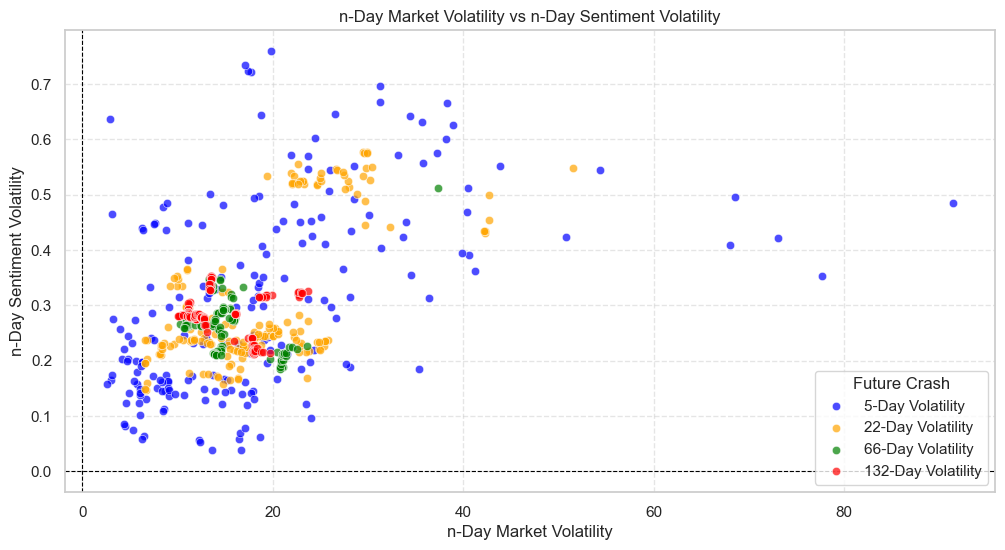

In [29]:
# Plot relationship between future crash and n-day market volatility combined with sentiment volatility
# Plot for 5 day, 22 day, 66 day, and 126 day volatility
crash_data = market_sentiment_data[market_sentiment_data['future_crash'] == 1]

# Scale the market volatility and sentiment volatility for better visualization
def scale_to_0_1(series):
    return (series - series.min()) / (series.max() - series.min())

scale_crash_data = crash_data.copy()

# for n in volatility_period:
#     scale_crash_data[f'{n}_day_market_volatility'] = scale_to_0_1(crash_data[f'{n}_day_market_volatility'])
#     scale_crash_data[f'{n}_day_sentiment_volatility'] = scale_to_0_1(crash_data[f'{n}_day_sentiment_volatility'])

plt.figure(figsize=(12, 6))
sns.scatterplot(x='5_day_market_volatility', y='5_day_sentiment_volatility', data=scale_crash_data, label='5-Day Volatility', alpha=0.7, color='blue')
sns.scatterplot(x='22_day_market_volatility', y='22_day_sentiment_volatility', data=scale_crash_data, label='22-Day Volatility', alpha=0.7, color='orange')
sns.scatterplot(x='66_day_market_volatility', y='66_day_sentiment_volatility', data=scale_crash_data, label='66-Day Volatility', alpha=0.7, color='green')
sns.scatterplot(x='132_day_market_volatility', y='132_day_sentiment_volatility', data=scale_crash_data, label='132-Day Volatility', alpha=0.7, color='red')
# sns.scatterplot(x='252_day_market_volatility', y='252_day_sentiment_volatility', data=scale_crash_data, label='252-Day Volatility', alpha=0.7, color='purple')
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.axvline(0, color='black', linestyle='--', linewidth=0.8)
plt.grid(True, linestyle='--', alpha=0.5)
plt.title('n-Day Market Volatility vs n-Day Sentiment Volatility')
plt.xlabel('n-Day Market Volatility')
plt.ylabel('n-Day Sentiment Volatility')
plt.legend(title='Future Crash', loc='lower right')
plt.show()

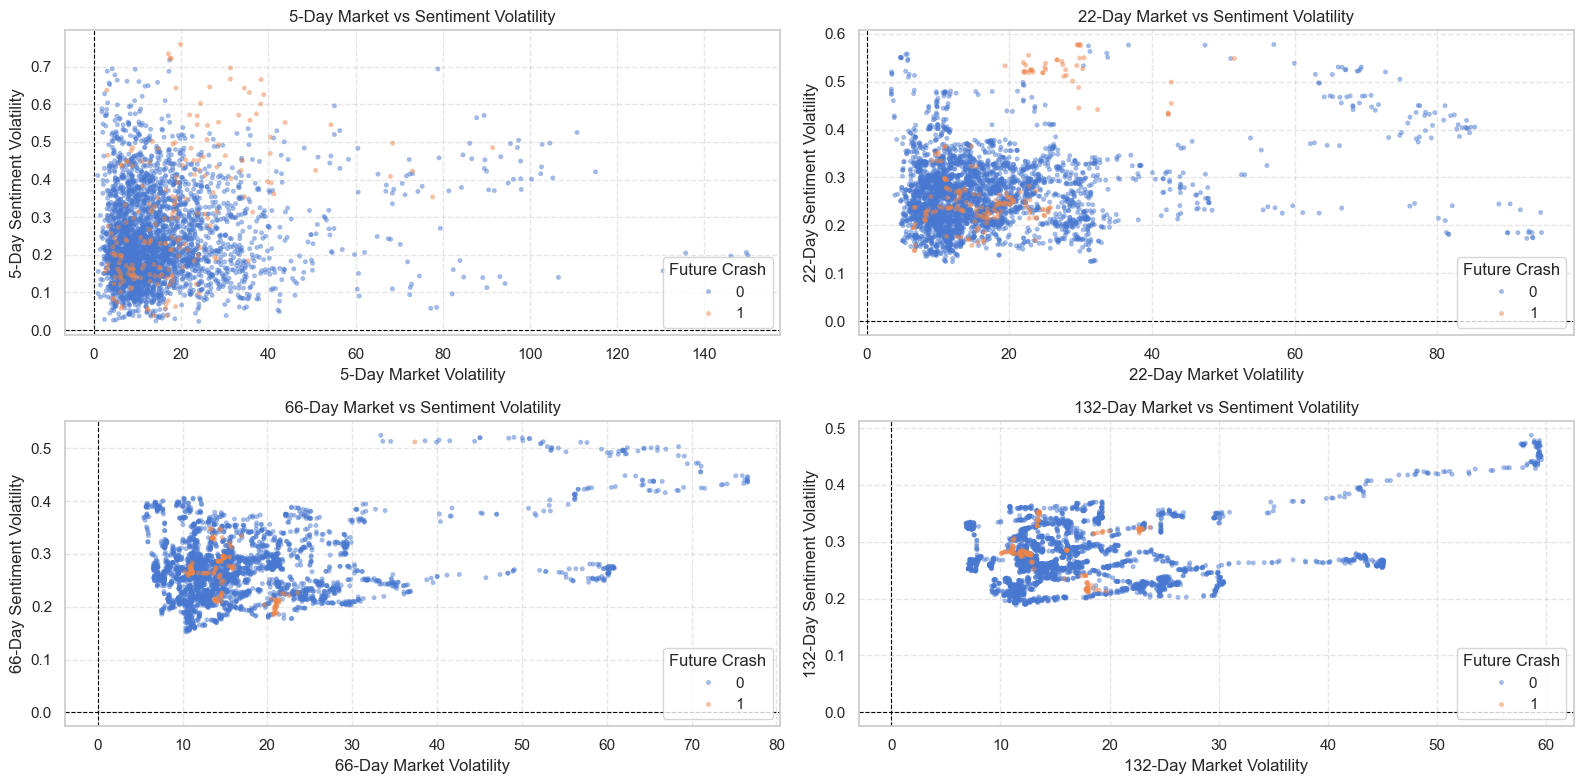

In [30]:
# Plot relationship between n-day market volatility and n-day sentiment volatility for each volatility period
n_cols = 2
n_rows = (len(volatility_period) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4 * n_rows))
axes = axes.flatten()

scale_crash_data = market_sentiment_data.copy()
# for n in volatility_period:
#     scale_crash_data[f'{n}_day_market_volatility'] = scale_to_0_1(market_sentiment_data[f'{n}_day_market_volatility'])
#     scale_crash_data[f'{n}_day_sentiment_volatility'] = scale_to_0_1(market_sentiment_data[f'{n}_day_sentiment_volatility'])
df_sorted = scale_crash_data.sort_values('future_crash')

for idx, n in enumerate(volatility_period):
    ax = axes[idx]
    x_col = f'{n}_day_market_volatility'
    y_col = f'{n}_day_sentiment_volatility'

    # Drop NA values for clean plot
    df_plot = df_sorted.dropna(subset=[x_col, y_col, 'future_crash'])

    sns.scatterplot(
        x=x_col, y=y_col, hue='future_crash', data=df_plot, alpha=0.5, ax=ax, edgecolor=None, s=10
    )
    ax.axhline(0, color='black', linestyle='--', linewidth=0.8)
    ax.axvline(0, color='black', linestyle='--', linewidth=0.8)
    ax.set_title(f'{n}-Day Market vs Sentiment Volatility')
    ax.set_xlabel(f'{n}-Day Market Volatility')
    ax.set_ylabel(f'{n}-Day Sentiment Volatility')
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.legend(title='Future Crash', loc='lower right')

# Remove unused subplots
for j in range(len(volatility_period), len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.legend(title='Future Crash', loc='lower right')
plt.show()

## Modelling

### Add VaR and ES features

In [31]:
def add_var_es_features(df, return_col='daily_return', windows=volatility_period, confidence=0.05):
    df = df.copy()
    z_score = abs(stats.norm.ppf(confidence))
    
    for w in windows:
        # Rolling mean and std of returns
        rolling_mu = df[return_col].rolling(window=w).mean()
        rolling_sigma = df[return_col].rolling(window=w).std()

        # Parametric Gaussian VaR (1-day, % return)
        df[f'VaR_{w}'] = - (rolling_mu + z_score * rolling_sigma)

        # Expected Shortfall (ES) assuming normal distribution
        pdf_factor = np.exp(-0.5 * z_score**2) / (np.sqrt(2 * np.pi))
        cdf_factor = confidence
        df[f'ES_{w}'] = - (rolling_mu + (rolling_sigma * pdf_factor / cdf_factor))
    
    return df

market_sentiment_data = add_var_es_features(market_sentiment_data, return_col='daily_return', confidence=0.05)

In [32]:
market_sentiment_data.columns

Index(['Date', 'avg_sentiment_score_a_day',
       'cross_sectional_sentiment_dispersion', '5_day_sentiment_volatility',
       '5_day_dispersion_volatility', '22_day_sentiment_volatility',
       '22_day_dispersion_volatility', '66_day_sentiment_volatility',
       '66_day_dispersion_volatility', '132_day_sentiment_volatility',
       '132_day_dispersion_volatility', 'Open', 'High', 'Low', 'Close',
       'Volume', 'future_close', 'future_crash', 'daily_return',
       '5_day_market_return', '22_day_market_return', '66_day_market_return',
       '132_day_market_return', '5_day_market_volatility',
       '22_day_market_volatility', '66_day_market_volatility',
       '132_day_market_volatility', 'VaR_5', 'ES_5', 'VaR_22', 'ES_22',
       'VaR_66', 'ES_66', 'VaR_132', 'ES_132'],
      dtype='object')

In [33]:
train_data = market_sentiment_data[market_sentiment_data['Date'] < '2022-01-01']
test_data = market_sentiment_data[market_sentiment_data['Date'] >= '2022-01-01']
target_col = 'future_crash'

print(train_data.shape, test_data.shape)

(2969, 35) (538, 35)


## Static Logit Regression

In [34]:
all_results = []

In [35]:
def static_logit_regression(n, feature_cols, market_sentiment_data, static_logit, X_test_dict, y_test_dict):
    train_data = market_sentiment_data[market_sentiment_data['Date'] < '2022-01-01']
    test_data = market_sentiment_data[(market_sentiment_data['Date'] >= '2022-01-01')]
    train_df = train_data.dropna(subset=feature_cols+['future_crash']).copy()
    test_df = test_data.dropna(subset=feature_cols+['future_crash']).copy()

    # Prepare feature matrices and target vectors
    X_train = train_df[feature_cols].fillna(train_df[feature_cols].mean())
    y_train = train_df['future_crash']

    X_test = test_df[feature_cols].fillna(train_df[feature_cols].mean())
    y_test = test_df['future_crash']
    
    # Apply SMOTE or any resampling to the training set only
    sm = SMOTE(random_state=RANDOM_STATE)
    X_resampled, y_resampled = sm.fit_resample(X_train, y_train)
    # X_resampled, y_resampled = X_train, y_train  # For simplicity, using original training data without resampling

    scaler = StandardScaler()
    X_resampled = scaler.fit_transform(X_resampled)
    X_test = scaler.transform(X_test)

    # Fit Logistic Regression
    logit = LogisticRegression(
        penalty='elasticnet',
        solver='saga',
        max_iter=1000, 
        class_weight='balanced',
        C=1.0,
        l1_ratio=0.5)
    logit.fit(X_resampled, y_resampled)

    # Predict on training set
    y_pred_train = logit.predict(X_resampled)
    y_proba_train = logit.predict_proba(X_resampled)[:, 1]

    y_proba_test = logit.predict_proba(X_test)[:, 1]
    best_thresh = dynamic_threshold_calculate(y_test, y_proba_test)
    y_pred_test = (y_proba_test >= best_thresh).astype(int)

    # Log loss (cross-entropy)
    train_loss = log_loss(y_resampled, y_proba_train)

    # Save results
    auc_test = roc_auc_score(y_test, y_proba_test)
    report_test = classification_report(y_test, y_pred_test, output_dict=True)
    conf = confusion_matrix(y_test, y_pred_test)
    date_seq = test_data['Date'].reset_index(drop=True)

    coefficients = pd.DataFrame({
        'Feature': feature_cols,
        'Coefficient': logit.coef_[0]
    }).sort_values(by='Coefficient', key=abs, ascending=False)

    static_logit[n] = {
        'model': logit,
        'auc_score': auc_test,
        'train_log_loss': train_loss,
        'report': report_test,
        'coefficients': coefficients,
        'y_test': y_test,
        'y_prob': y_proba_test,
        'confusion': conf,
        'date_seq': date_seq,
    }

    # Save test set for plotting or later comparison
    X_test_dict[n] = X_test
    y_test_dict[n] = y_test

    # Print summary
    print(f"\n=== {n}-Day Static Logit Model ===")
    print(f"Test AUC: {auc_test:.3f}")
    print("Classification Report (Test):")
    print(classification_report(y_test, y_pred_test))

### Static Logit Regression (Market)

In [36]:
static_logit_market = {}
X_test_dict = {}
y_test_dict = {}

for n in volatility_period:
    feature_cols = [
        f'{n}_day_market_volatility',
        f'VaR_{n}',
        f'ES_{n}',
    ]

    static_logit_regression(n, feature_cols, market_sentiment_data, static_logit_market, X_test_dict, y_test_dict)

all_results.append(static_logit_market)

Best threshold: 0.47, F1: 0.17

=== 5-Day Static Logit Model ===
Test AUC: 0.535
Classification Report (Test):
              precision    recall  f1-score   support

           0       0.96      0.29      0.44       495
           1       0.10      0.86      0.17        43

    accuracy                           0.33       538
   macro avg       0.53      0.57      0.31       538
weighted avg       0.89      0.33      0.42       538

Best threshold: 0.50, F1: 0.23

=== 22-Day Static Logit Model ===
Test AUC: 0.684
Classification Report (Test):
              precision    recall  f1-score   support

           0       0.95      0.66      0.78       495
           1       0.14      0.63      0.23        43

    accuracy                           0.66       538
   macro avg       0.55      0.64      0.50       538
weighted avg       0.89      0.66      0.74       538

Best threshold: 0.27, F1: 0.19

=== 66-Day Static Logit Model ===
Test AUC: 0.416
Classification Report (Test):
           

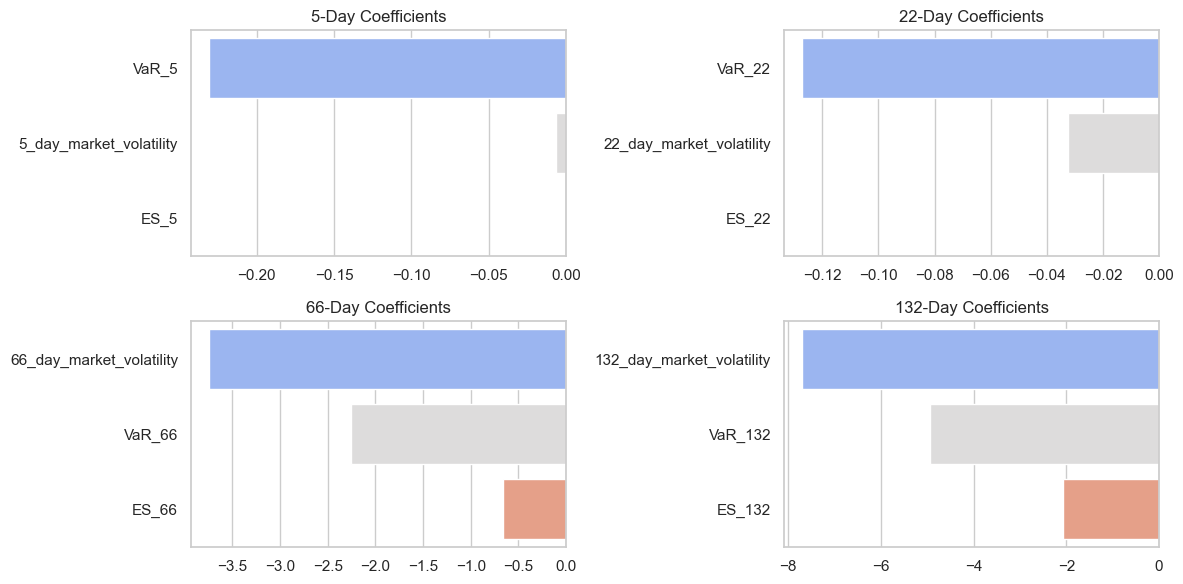

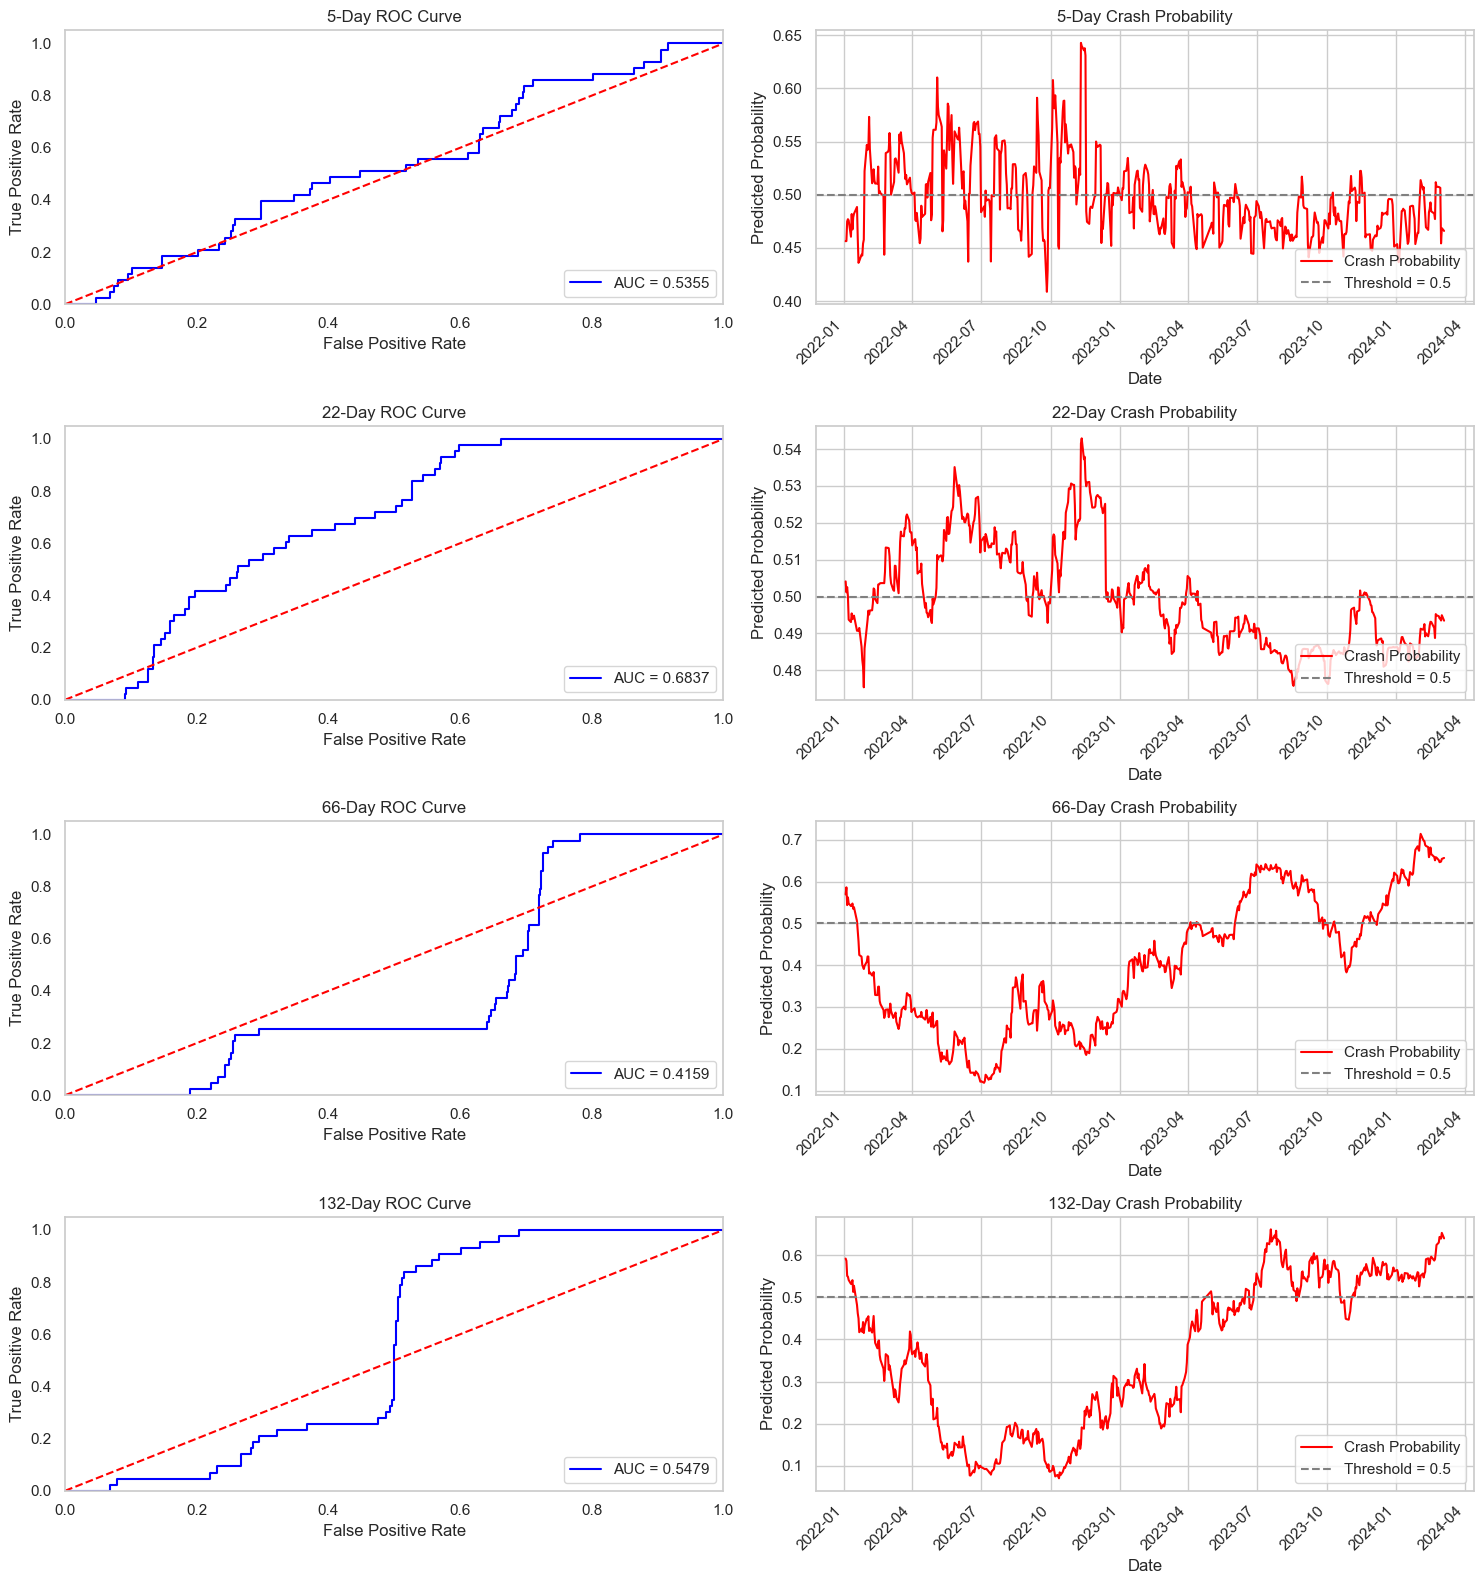

In [37]:
plot_logit_coefficients_grid(static_logit_market)
plot_roc_and_crash_probabilities_grid(static_logit_market, X_test_dict, y_test_dict)

### Static Logit Regression (Sentiment)

In [38]:
static_logit_sentiment = {}
X_test_dict = {}
y_test_dict = {}

for n in volatility_period:
    feature_cols = [
        f'{n}_day_sentiment_volatility',
    ]

    static_logit_regression(n, feature_cols, market_sentiment_data, static_logit_sentiment, X_test_dict, y_test_dict)

all_results.append(static_logit_sentiment)


Best threshold: 0.50, F1: 0.35

=== 5-Day Static Logit Model ===
Test AUC: 0.558
Classification Report (Test):
              precision    recall  f1-score   support

           0       0.94      0.95      0.95       495
           1       0.37      0.33      0.35        43

    accuracy                           0.90       538
   macro avg       0.66      0.64      0.65       538
weighted avg       0.90      0.90      0.90       538

Best threshold: 0.40, F1: 0.30

=== 22-Day Static Logit Model ===
Test AUC: 0.758
Classification Report (Test):
              precision    recall  f1-score   support

           0       0.98      0.65      0.78       495
           1       0.18      0.88      0.30        43

    accuracy                           0.67       538
   macro avg       0.58      0.77      0.54       538
weighted avg       0.92      0.67      0.75       538

Best threshold: 0.52, F1: 0.23

=== 66-Day Static Logit Model ===
Test AUC: 0.635
Classification Report (Test):
           

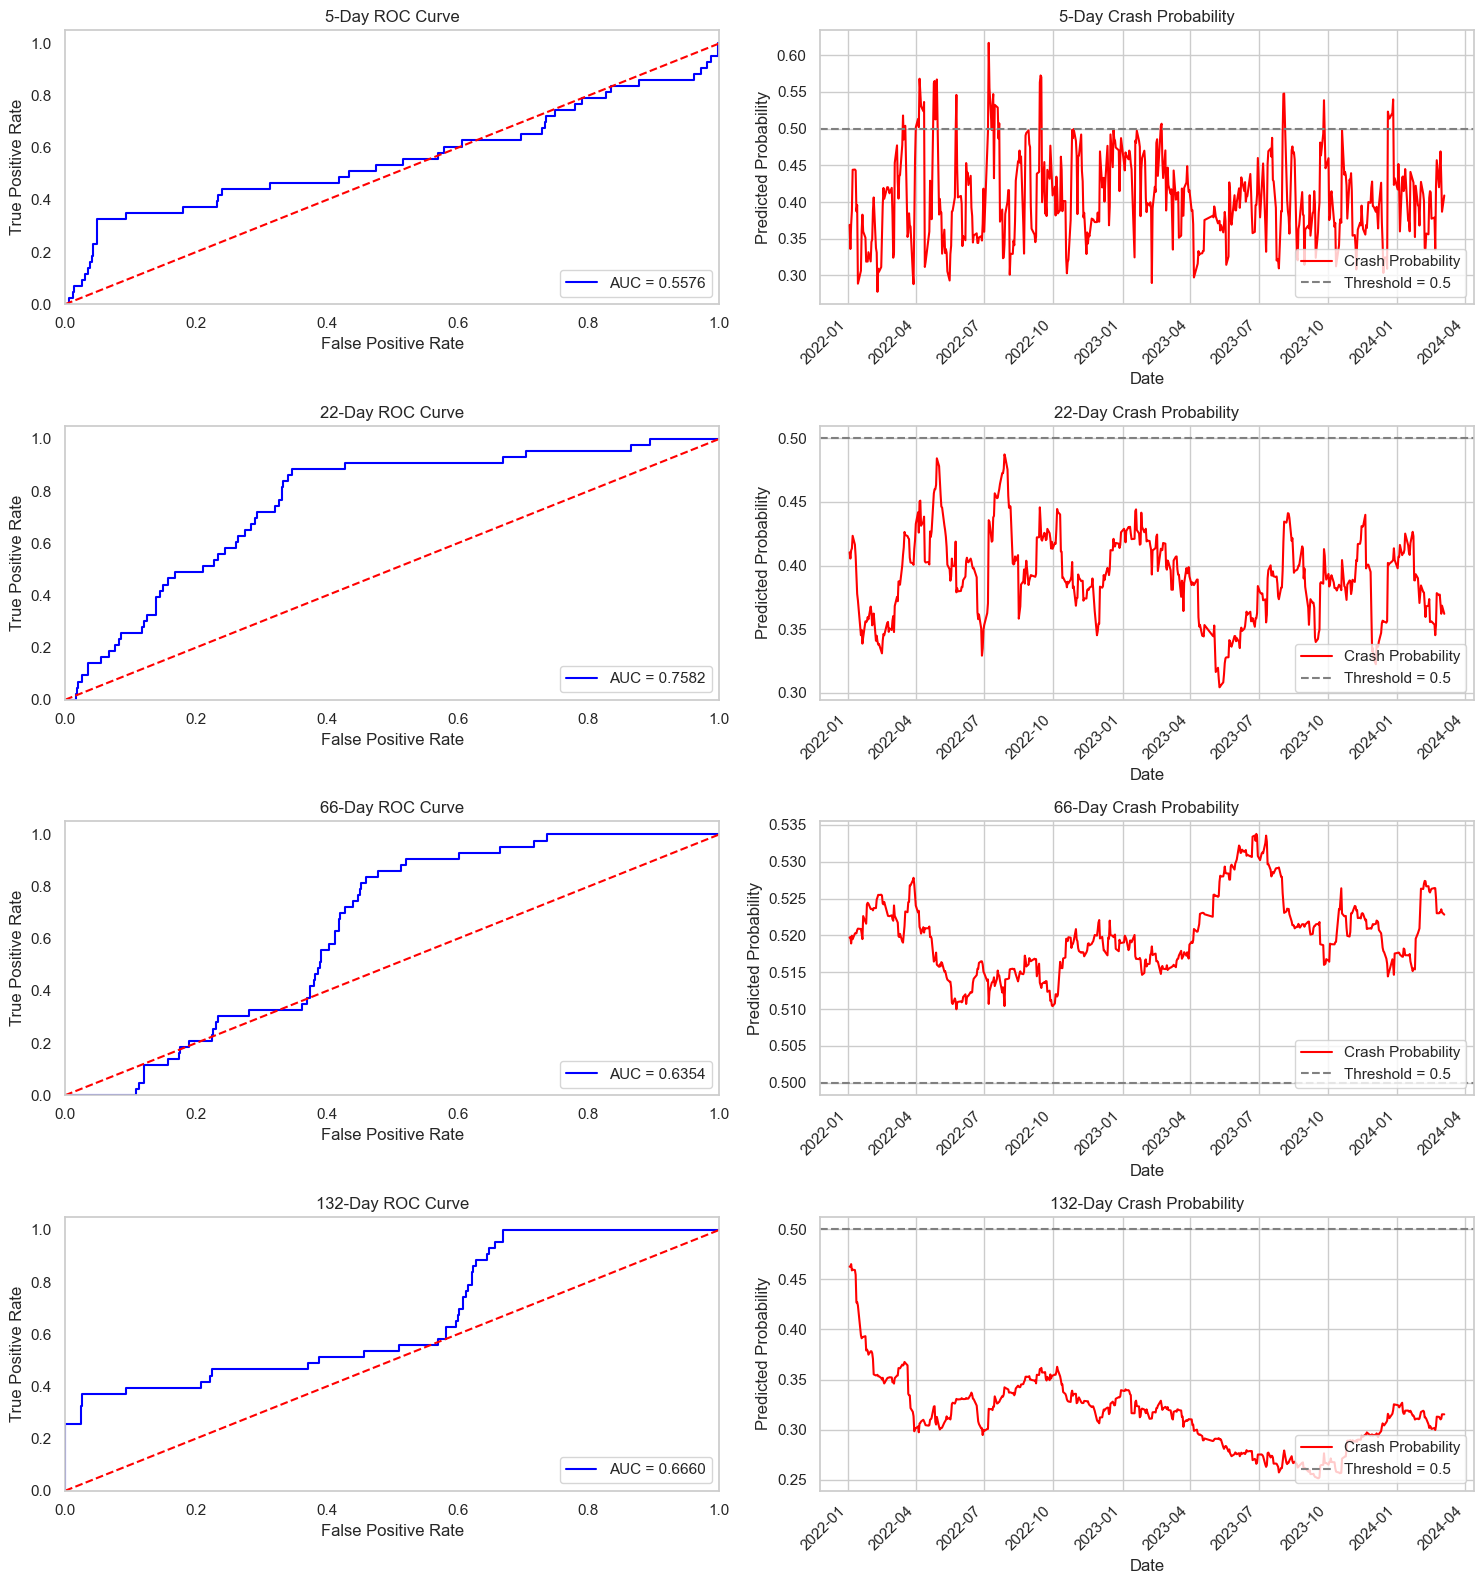

In [39]:
plot_roc_and_crash_probabilities_grid(static_logit_sentiment, X_test_dict, y_test_dict)

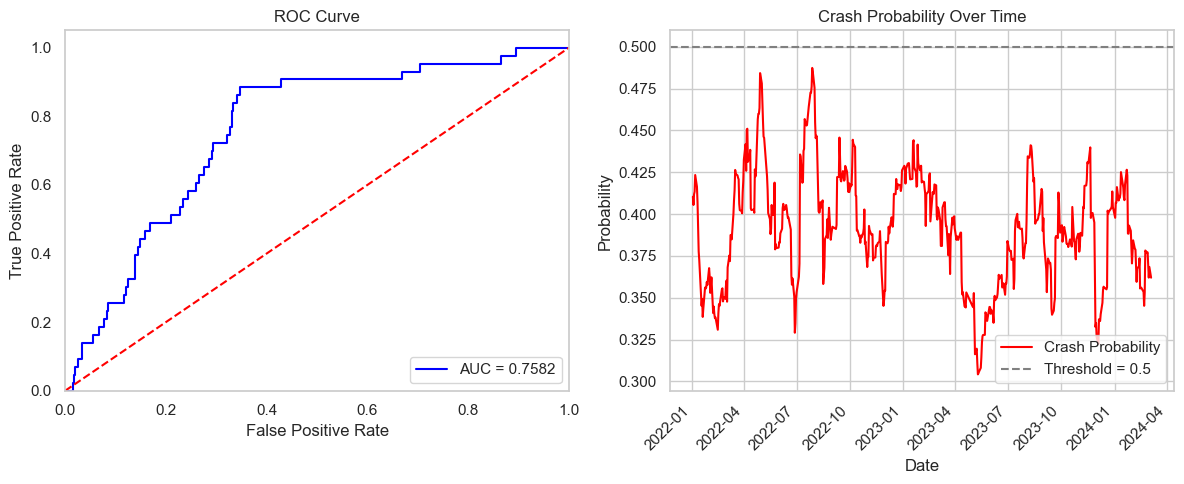

In [40]:
plot_logit_roc_and_crash_prob_for_one(static_logit_sentiment[22], X_test_dict[22], y_test_dict[22])

### Static Logit Regression (Market + Sentiment)

In [41]:
static_logit_combined = {}
X_test_dict = {}
y_test_dict = {}

for n in volatility_period:
    feature_cols = [
        f'{n}_day_market_volatility',
        f'{n}_day_sentiment_volatility',
        f'VaR_{n}',
        f'ES_{n}',
    ]

    static_logit_regression(n, feature_cols, market_sentiment_data, static_logit_combined, X_test_dict, y_test_dict)

all_results.append(static_logit_combined)

Best threshold: 0.49, F1: 0.32

=== 5-Day Static Logit Model ===
Test AUC: 0.564
Classification Report (Test):
              precision    recall  f1-score   support

           0       0.94      0.93      0.94       495
           1       0.30      0.35      0.32        43

    accuracy                           0.88       538
   macro avg       0.62      0.64      0.63       538
weighted avg       0.89      0.88      0.89       538

Best threshold: 0.38, F1: 0.30

=== 22-Day Static Logit Model ===
Test AUC: 0.735
Classification Report (Test):
              precision    recall  f1-score   support

           0       0.97      0.70      0.81       495
           1       0.19      0.79      0.30        43

    accuracy                           0.71       538
   macro avg       0.58      0.74      0.56       538
weighted avg       0.91      0.71      0.77       538

Best threshold: 0.24, F1: 0.19

=== 66-Day Static Logit Model ===
Test AUC: 0.410
Classification Report (Test):
           

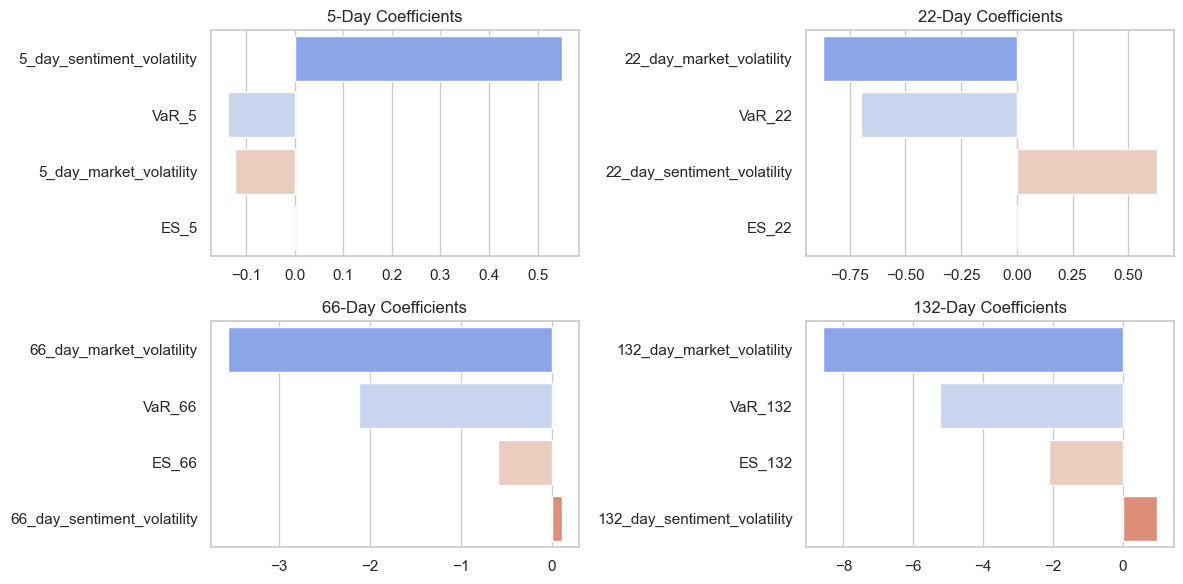

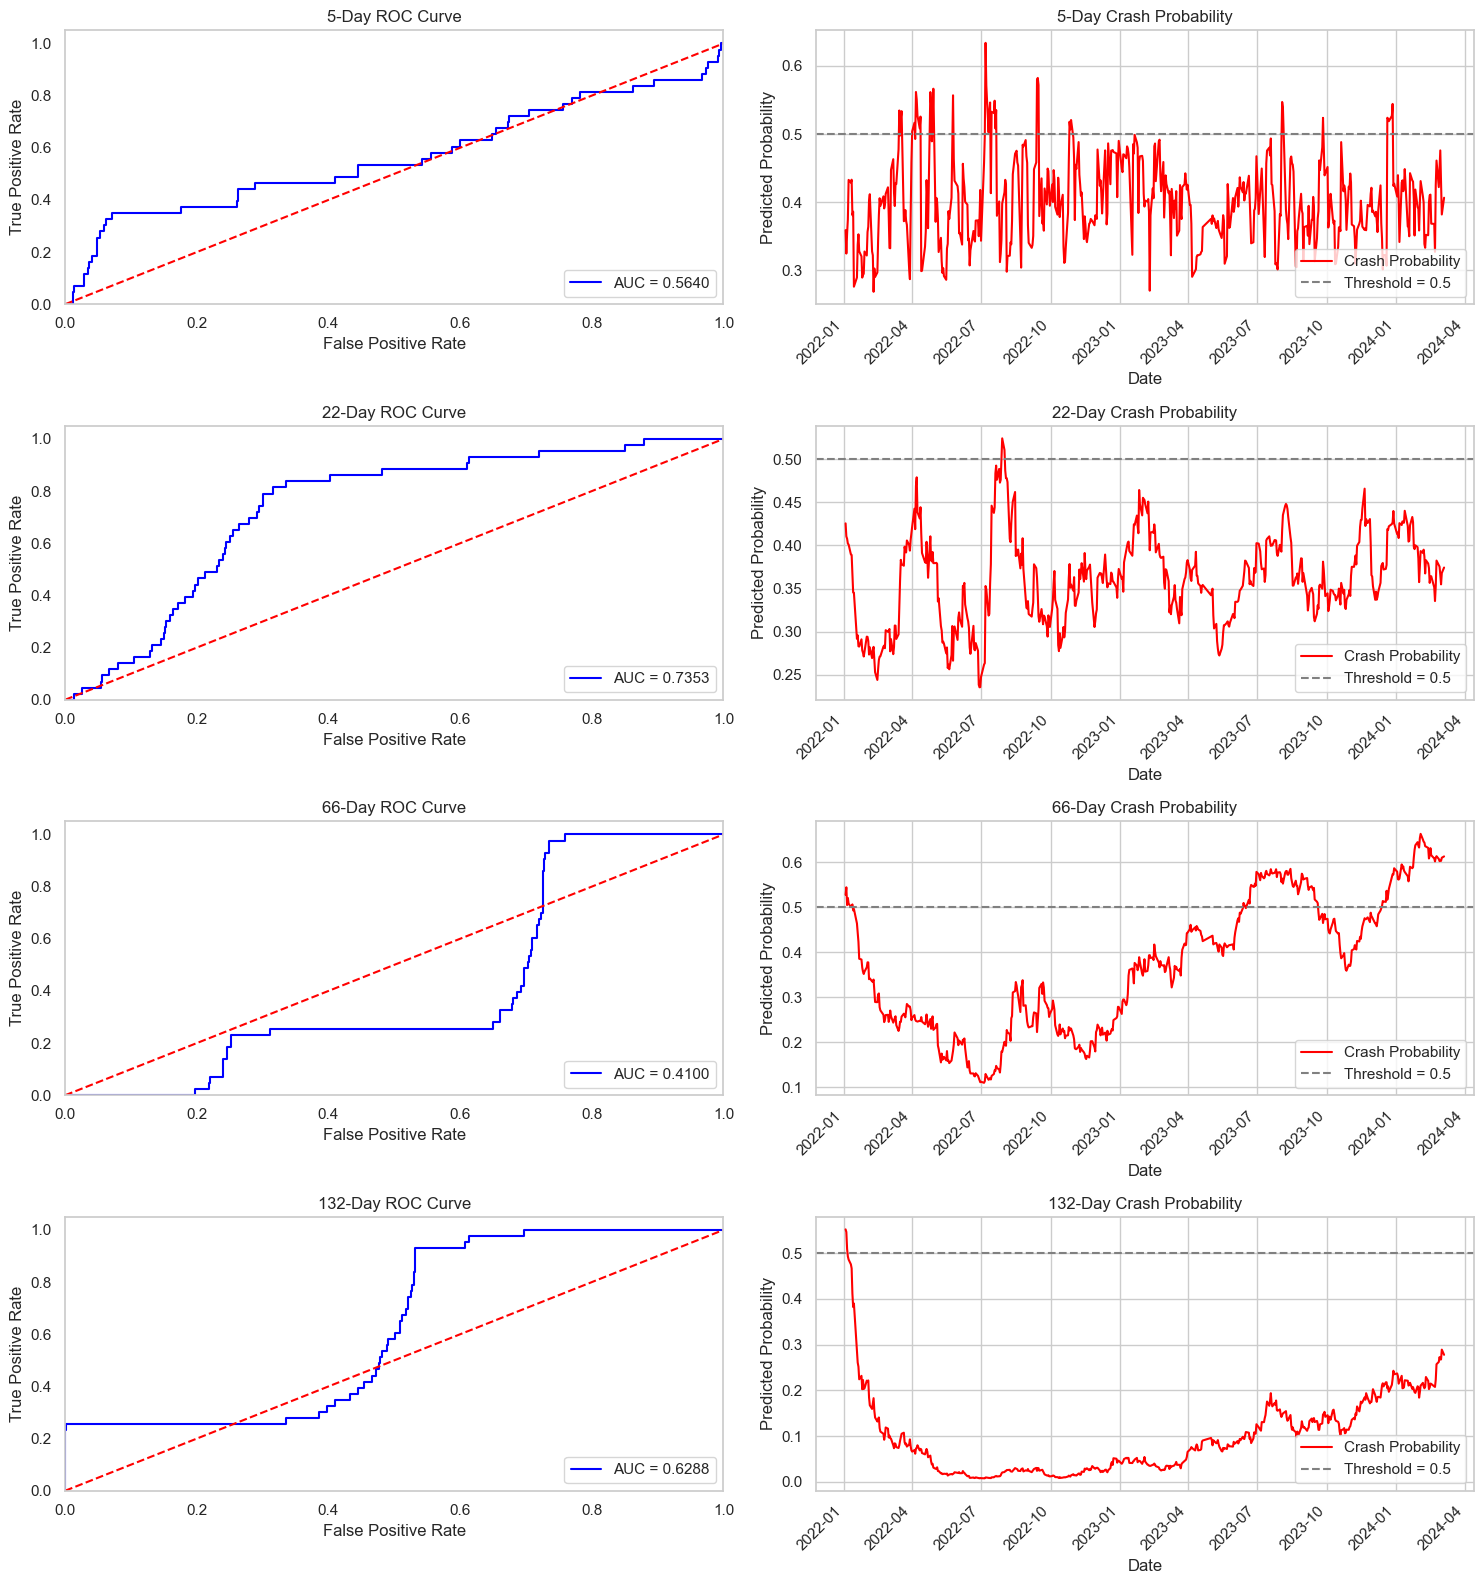

In [42]:
plot_logit_coefficients_grid(static_logit_combined)
plot_roc_and_crash_probabilities_grid(static_logit_combined, X_test_dict, y_test_dict)

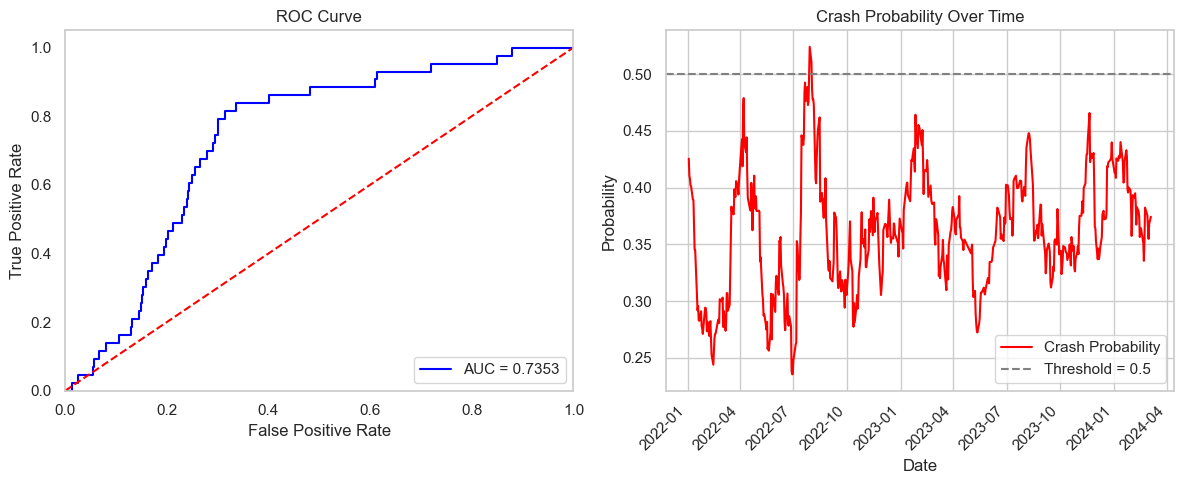

In [43]:
plot_logit_roc_and_crash_prob_for_one(static_logit_combined[22], X_test_dict[22], y_test_dict[22])

## Dynamic Logit Regression

In [44]:
def dynamic_logit_regression(n, feature_cols, market_sentiment_data, dynamic_logit, X_test_dict, y_test_dict, lag=10):
    market_sentiment_data_with_lags = market_sentiment_data.copy()

    # Add lagged features
    for feat in feature_cols:
        market_sentiment_data_with_lags[f'{feat}_lag{lag}'] = market_sentiment_data[feat].shift(lag)

    feature_cols_lag = feature_cols + [f'{f}_lag{lag}' for f in feature_cols]

    train_data = market_sentiment_data_with_lags[market_sentiment_data_with_lags['Date'] < '2022-01-01']
    test_data = market_sentiment_data_with_lags[(market_sentiment_data_with_lags['Date'] >= '2022-01-01')]
    train_df = train_data.dropna(subset=feature_cols_lag+['future_crash']).copy()
    test_df = test_data.dropna(subset=feature_cols_lag+['future_crash']).copy()

    # Prepare feature matrices and target vectors
    X_train = train_df[feature_cols_lag].fillna(train_df[feature_cols_lag].mean())
    y_train = train_df['future_crash']

    X_test = test_df[feature_cols_lag].fillna(train_df[feature_cols_lag].mean())
    y_test = test_df['future_crash']
    
    # Oversample
    sm = SMOTE(random_state=RANDOM_STATE)
    X_resampled, y_resampled = sm.fit_resample(X_train, y_train)
    # X_resampled, y_resampled = X_train.copy(), y_train.copy()

    scaler = StandardScaler()
    X_resampled = scaler.fit_transform(X_resampled)
    X_test = scaler.transform(X_test)

    # Fit Logistic Regression
    logit = LogisticRegression(
        penalty='elasticnet',
        solver='saga',
        max_iter=1000, 
        class_weight='balanced',
        C=1.0,
        l1_ratio=0.5)
    logit.fit(X_resampled, y_resampled)
    # Predict
    y_proba = logit.predict_proba(X_test)[:, 1]
    best_thresh = dynamic_threshold_calculate(y_test, y_proba)
    y_pred = (y_proba >= best_thresh).astype(int)
    # y_pred = logit.predict(X_test)
    
    # Save results
    auc_score = roc_auc_score(y_test, y_proba)
    report = classification_report(y_test, y_pred, output_dict=True)
    conf = confusion_matrix(y_test, y_pred)
    date_seq = test_data['Date'].reset_index(drop=True)

    coefficients = pd.DataFrame({
        'Feature': feature_cols_lag,
        'Coefficient': logit.coef_[0]
    }).sort_values(by='Coefficient', key=abs, ascending=False)

    dynamic_logit[n] = {
        'model': logit,
        'auc_score': auc_score,
        'report': report,
        'coefficients': coefficients,
        'confusion': conf,
        'date_seq': date_seq,
        'y_test': y_test,
        'y_prob': y_proba,
    }

    X_test_dict[n] = X_test
    y_test_dict[n] = y_test

    print(f"\n=== {n}-Day Logit Model with Lag {lag} ===")
    print(f"AUC: {auc_score:.3f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

### Dynamic Logit Regression (Market)

In [45]:
dynamic_logit_market = {}
X_test_dict = {}
y_test_dict = {}

for n in volatility_period:
    feature_cols = [
        f'{n}_day_market_volatility',
        f'VaR_{n}',
        f'ES_{n}',
    ]

    dynamic_logit_regression(n, feature_cols, market_sentiment_data, dynamic_logit_market, X_test_dict, y_test_dict, lag=10)

all_results.append(dynamic_logit_market)

Best threshold: 0.52, F1: 0.18

=== 5-Day Logit Model with Lag 10 ===
AUC: 0.538
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.83      0.88       495
           1       0.13      0.28      0.18        43

    accuracy                           0.79       538
   macro avg       0.53      0.56      0.53       538
weighted avg       0.87      0.79      0.82       538

Best threshold: 0.48, F1: 0.18

=== 22-Day Logit Model with Lag 10 ===
AUC: 0.501
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.21      0.35       495
           1       0.10      1.00      0.18        43

    accuracy                           0.28       538
   macro avg       0.55      0.61      0.27       538
weighted avg       0.93      0.28      0.34       538

Best threshold: 0.20, F1: 0.18

=== 66-Day Logit Model with Lag 10 ===
AUC: 0.416
Classification Report:
              precision    recal

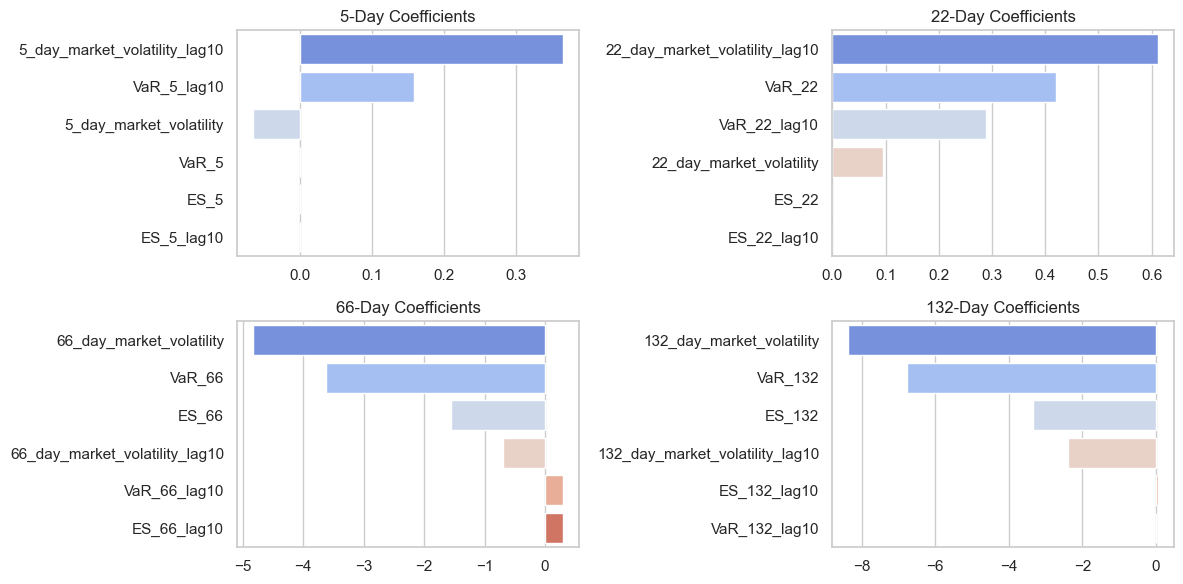

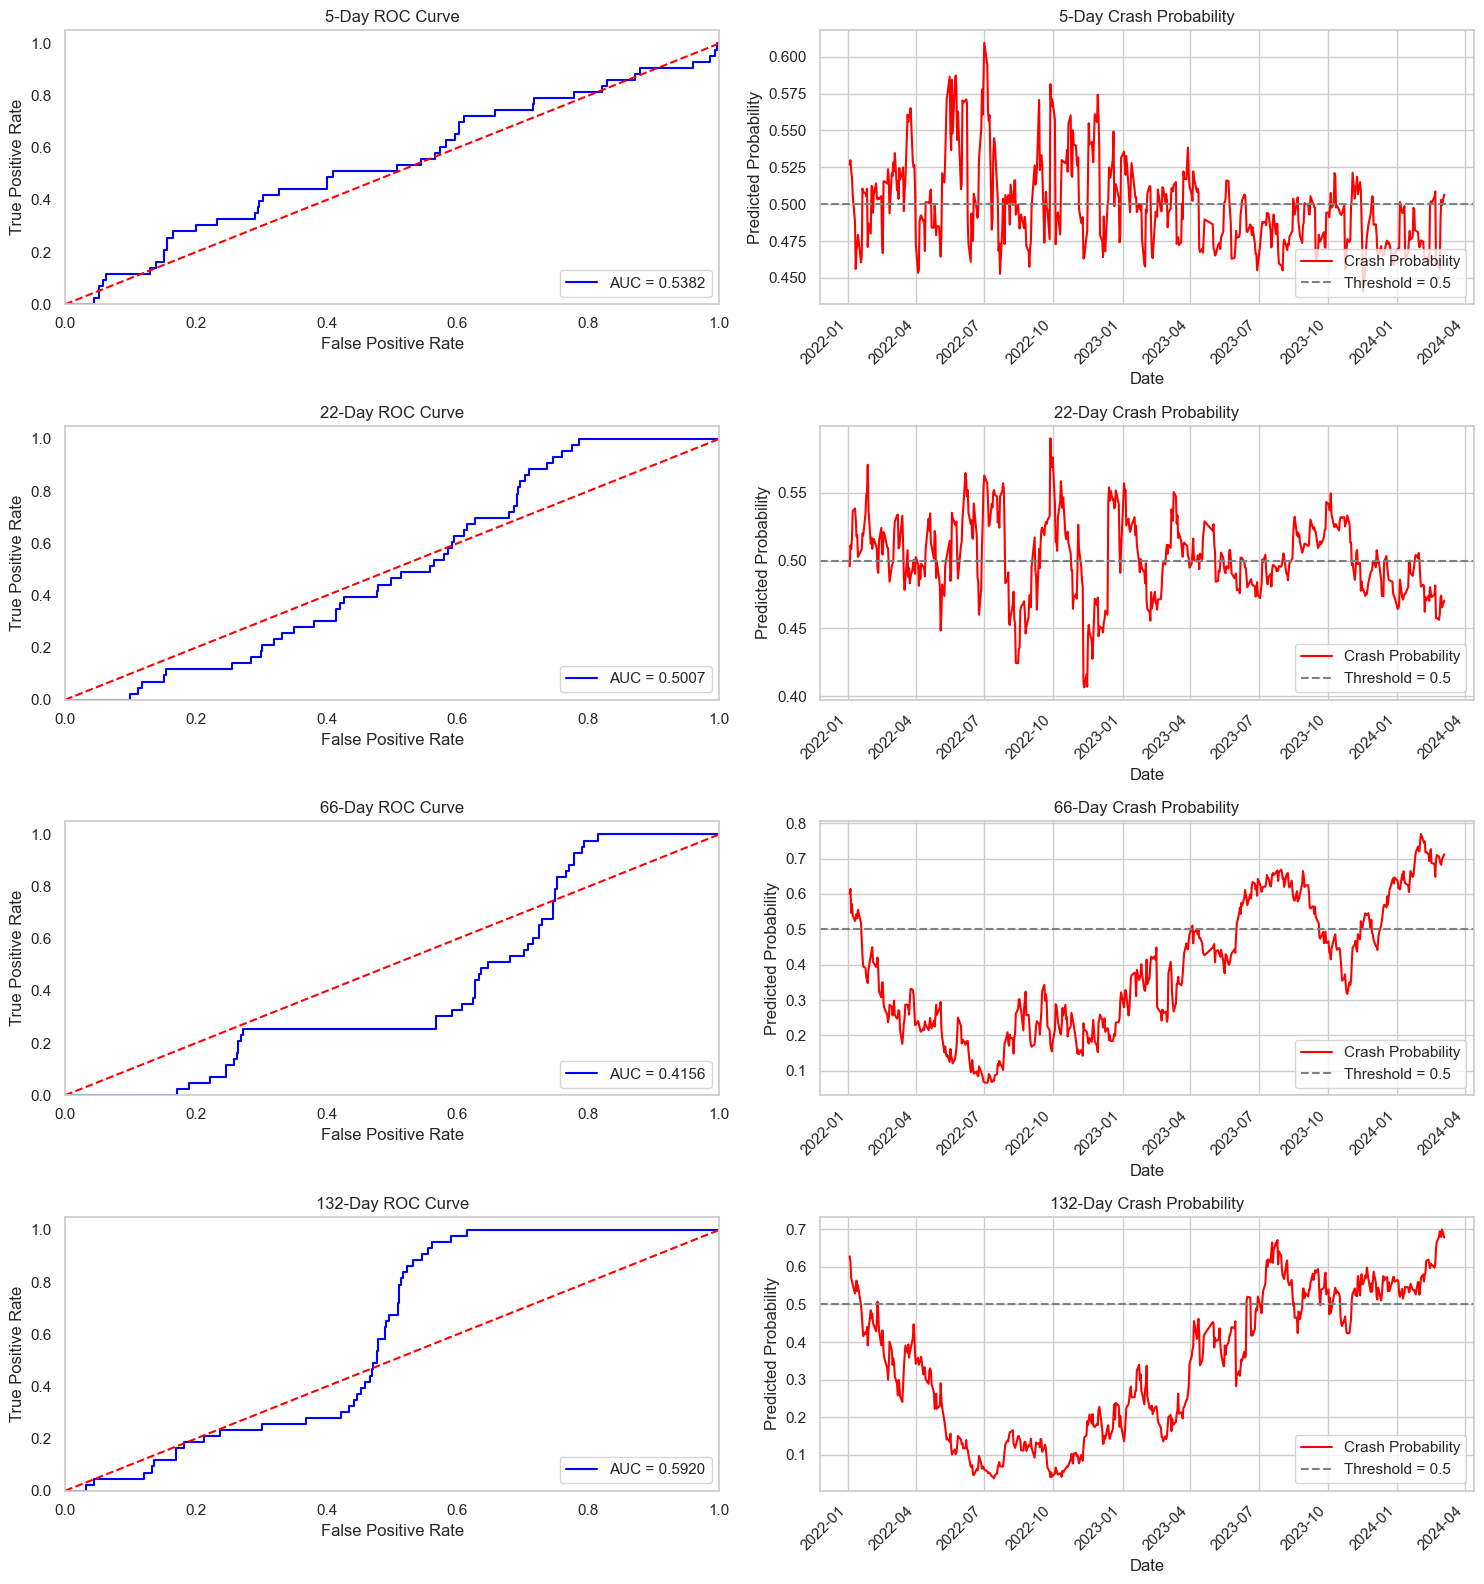

In [46]:
plot_logit_coefficients_grid(dynamic_logit_market)
plot_roc_and_crash_probabilities_grid(dynamic_logit_market, X_test_dict, y_test_dict)

### Dynamic Logit Regression (Sentiment)

In [47]:
dynamic_logit_sentiment = {}
X_test_dict = {}
y_test_dict = {}

for n in volatility_period:
    feature_cols = [
        f'{n}_day_sentiment_volatility',
    ]

    dynamic_logit_regression(n, feature_cols, market_sentiment_data, dynamic_logit_sentiment, X_test_dict, y_test_dict, lag=10)

all_results.append(dynamic_logit_sentiment)

Best threshold: 0.47, F1: 0.20

=== 5-Day Logit Model with Lag 10 ===
AUC: 0.608
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.91      0.92       495
           1       0.18      0.23      0.20        43

    accuracy                           0.85       538
   macro avg       0.56      0.57      0.56       538
weighted avg       0.87      0.85      0.86       538

Best threshold: 0.45, F1: 0.30

=== 22-Day Logit Model with Lag 10 ===
AUC: 0.711
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.89      0.92       495
           1       0.24      0.40      0.30        43

    accuracy                           0.85       538
   macro avg       0.59      0.64      0.61       538
weighted avg       0.89      0.85      0.87       538

Best threshold: 0.61, F1: 0.28

=== 66-Day Logit Model with Lag 10 ===
AUC: 0.508
Classification Report:
              precision    recal

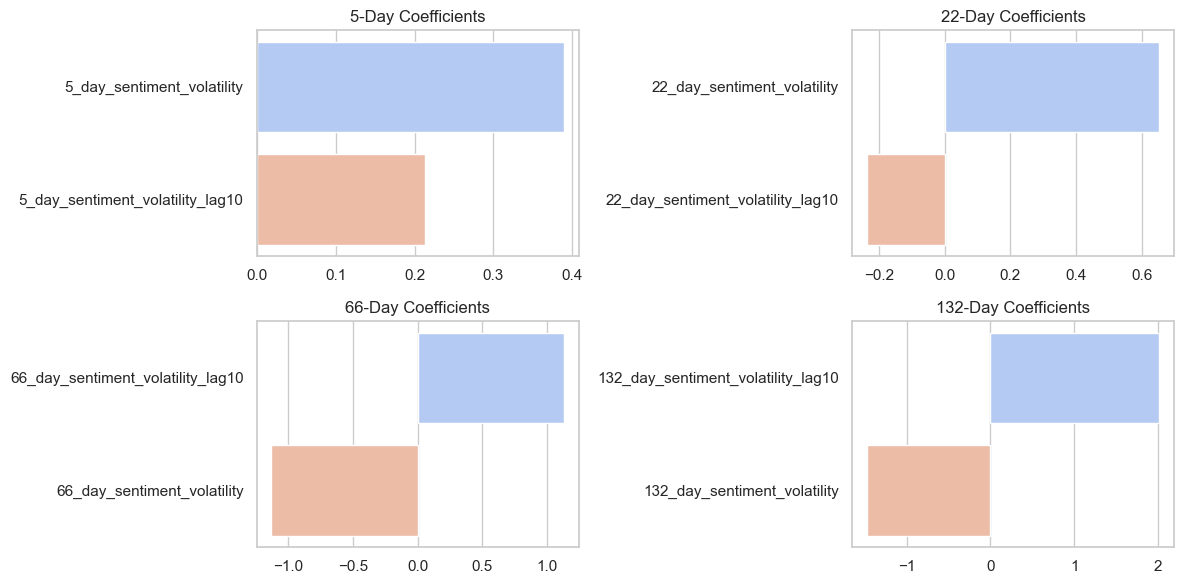

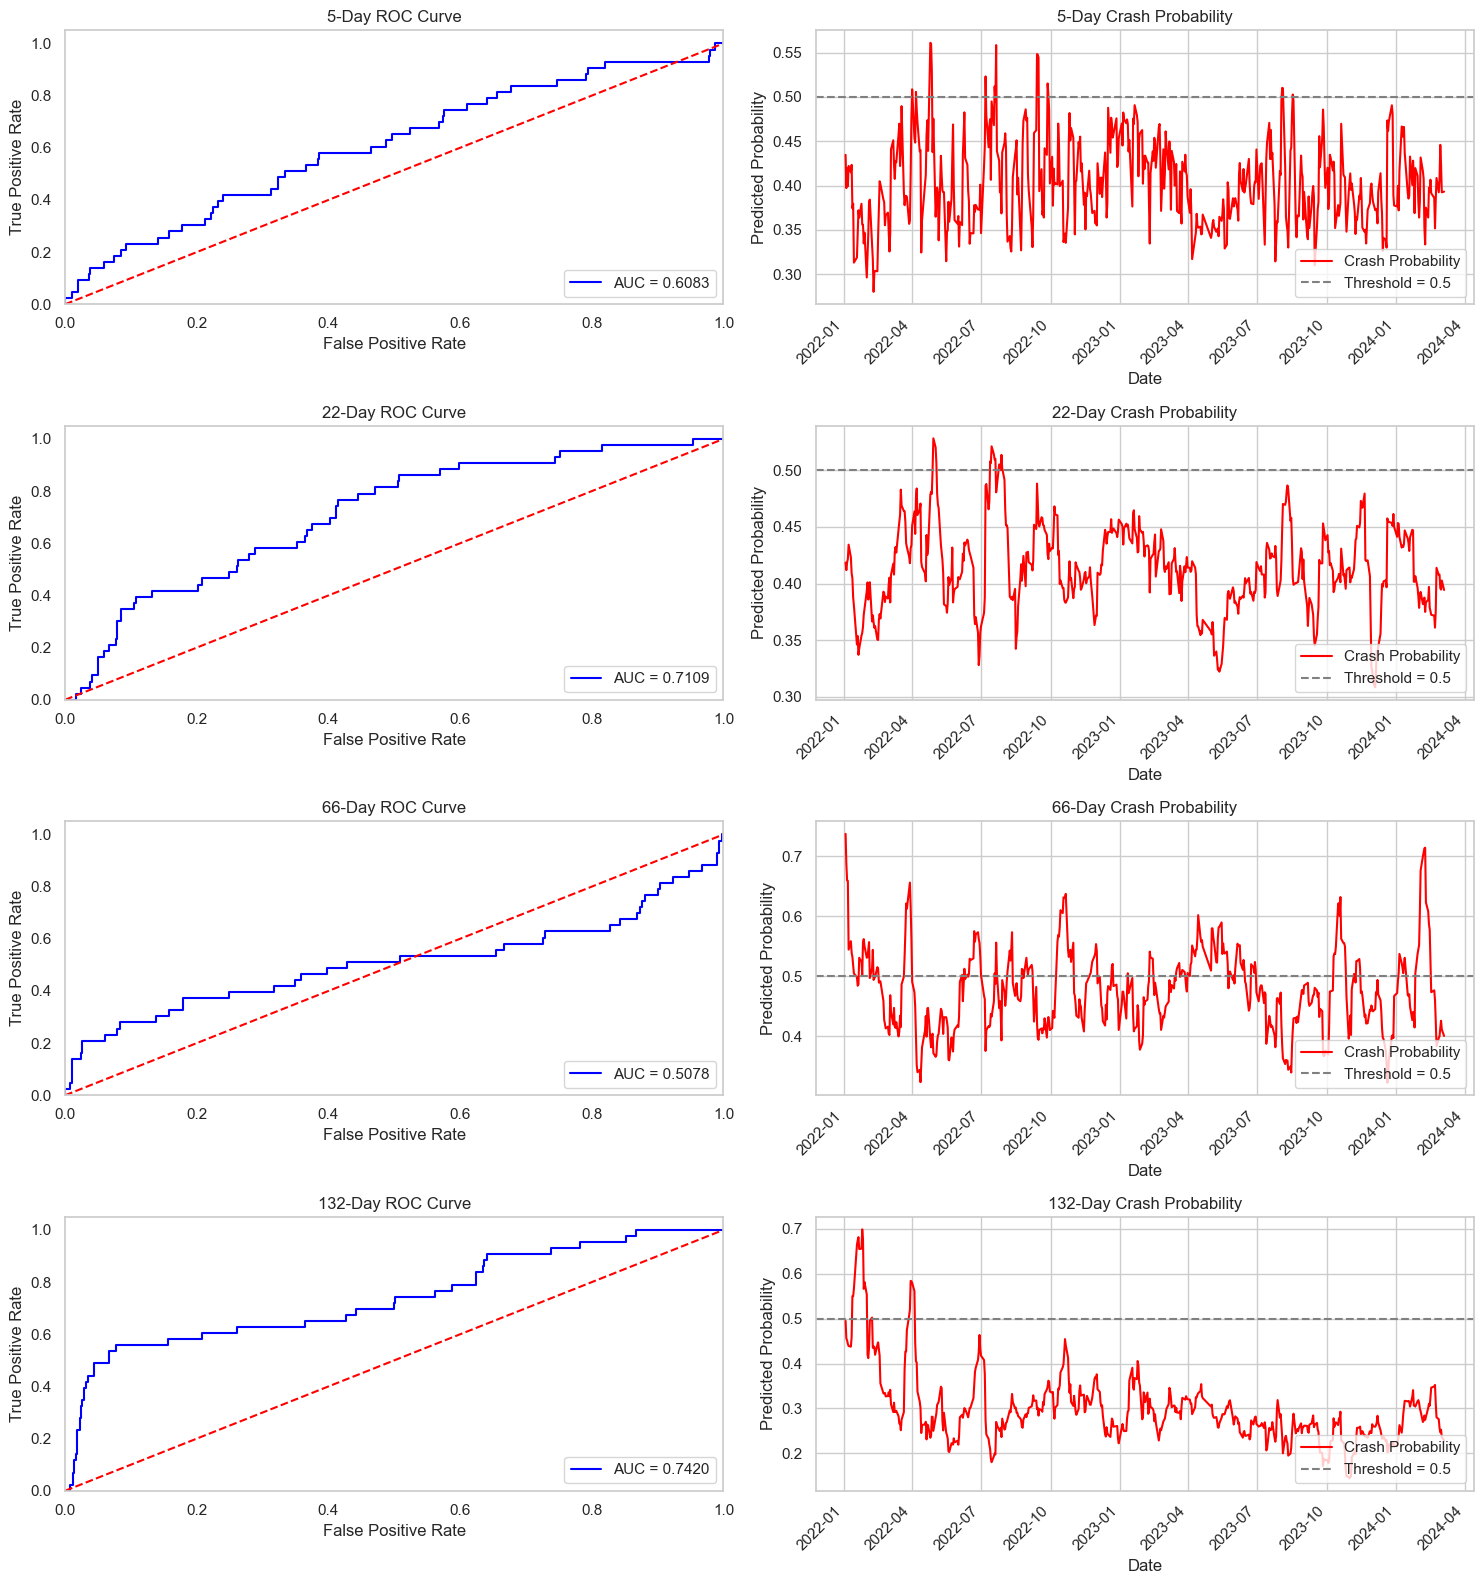

In [48]:
plot_logit_coefficients_grid(dynamic_logit_sentiment)
plot_roc_and_crash_probabilities_grid(dynamic_logit_sentiment, X_test_dict, y_test_dict)

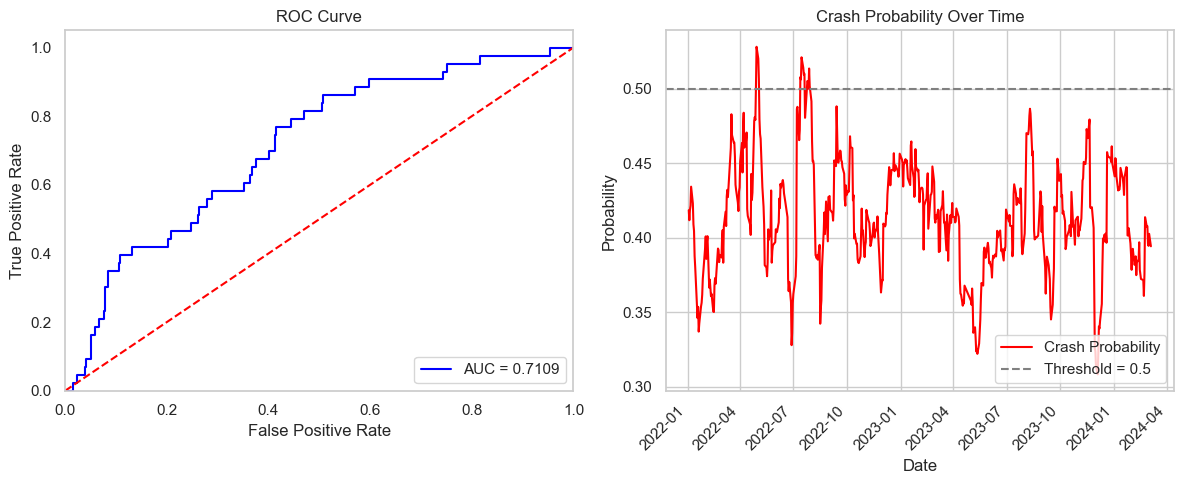

In [49]:
plot_logit_roc_and_crash_prob_for_one(dynamic_logit_sentiment[22], X_test_dict[22], y_test_dict[22])

### Dynamic Logit Regression (Market + Sentiment)

In [50]:
dynamic_logit_combined = {}
X_test_dict = {}
y_test_dict = {}

for n in volatility_period:
    feature_cols = [
        f'{n}_day_sentiment_volatility',
        f'{n}_day_market_volatility',
        f'VaR_{n}',
        f'ES_{n}',
    ]

    dynamic_logit_regression(n, feature_cols, market_sentiment_data, dynamic_logit_combined, X_test_dict, y_test_dict, lag=10)

all_results.append(dynamic_logit_combined)

Best threshold: 0.39, F1: 0.20

=== 5-Day Logit Model with Lag 10 ===
AUC: 0.606
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.56      0.70       495
           1       0.12      0.67      0.20        43

    accuracy                           0.57       538
   macro avg       0.53      0.61      0.45       538
weighted avg       0.88      0.57      0.66       538

Best threshold: 0.41, F1: 0.24

=== 22-Day Logit Model with Lag 10 ===
AUC: 0.656
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.71      0.81       495
           1       0.15      0.60      0.24        43

    accuracy                           0.70       538
   macro avg       0.55      0.66      0.53       538
weighted avg       0.89      0.70      0.77       538

Best threshold: 0.47, F1: 0.16

=== 66-Day Logit Model with Lag 10 ===
AUC: 0.430
Classification Report:
              precision    recal

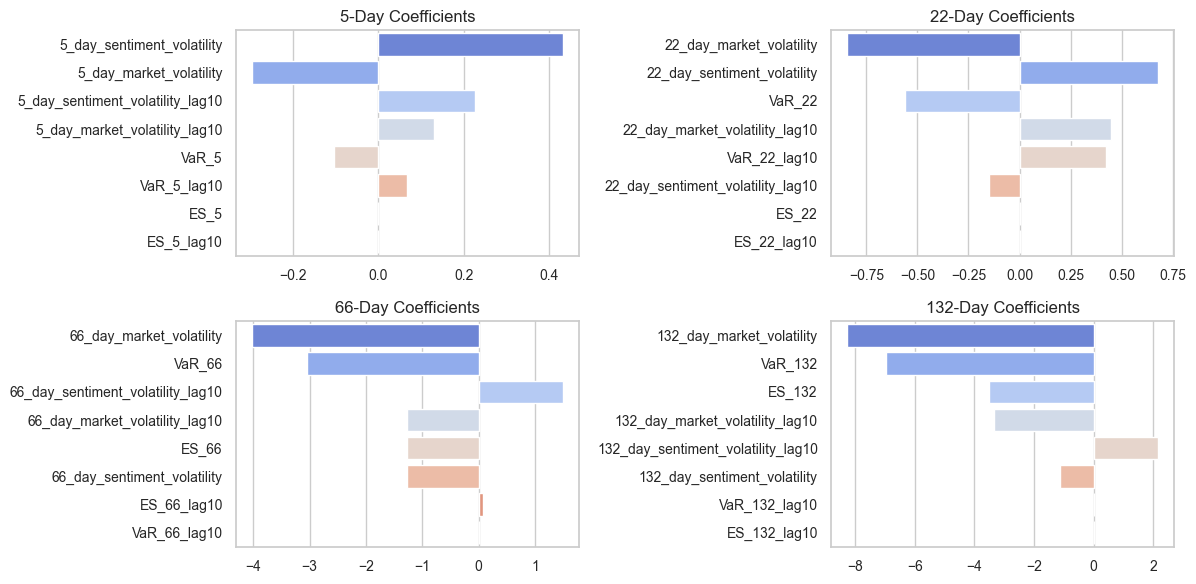

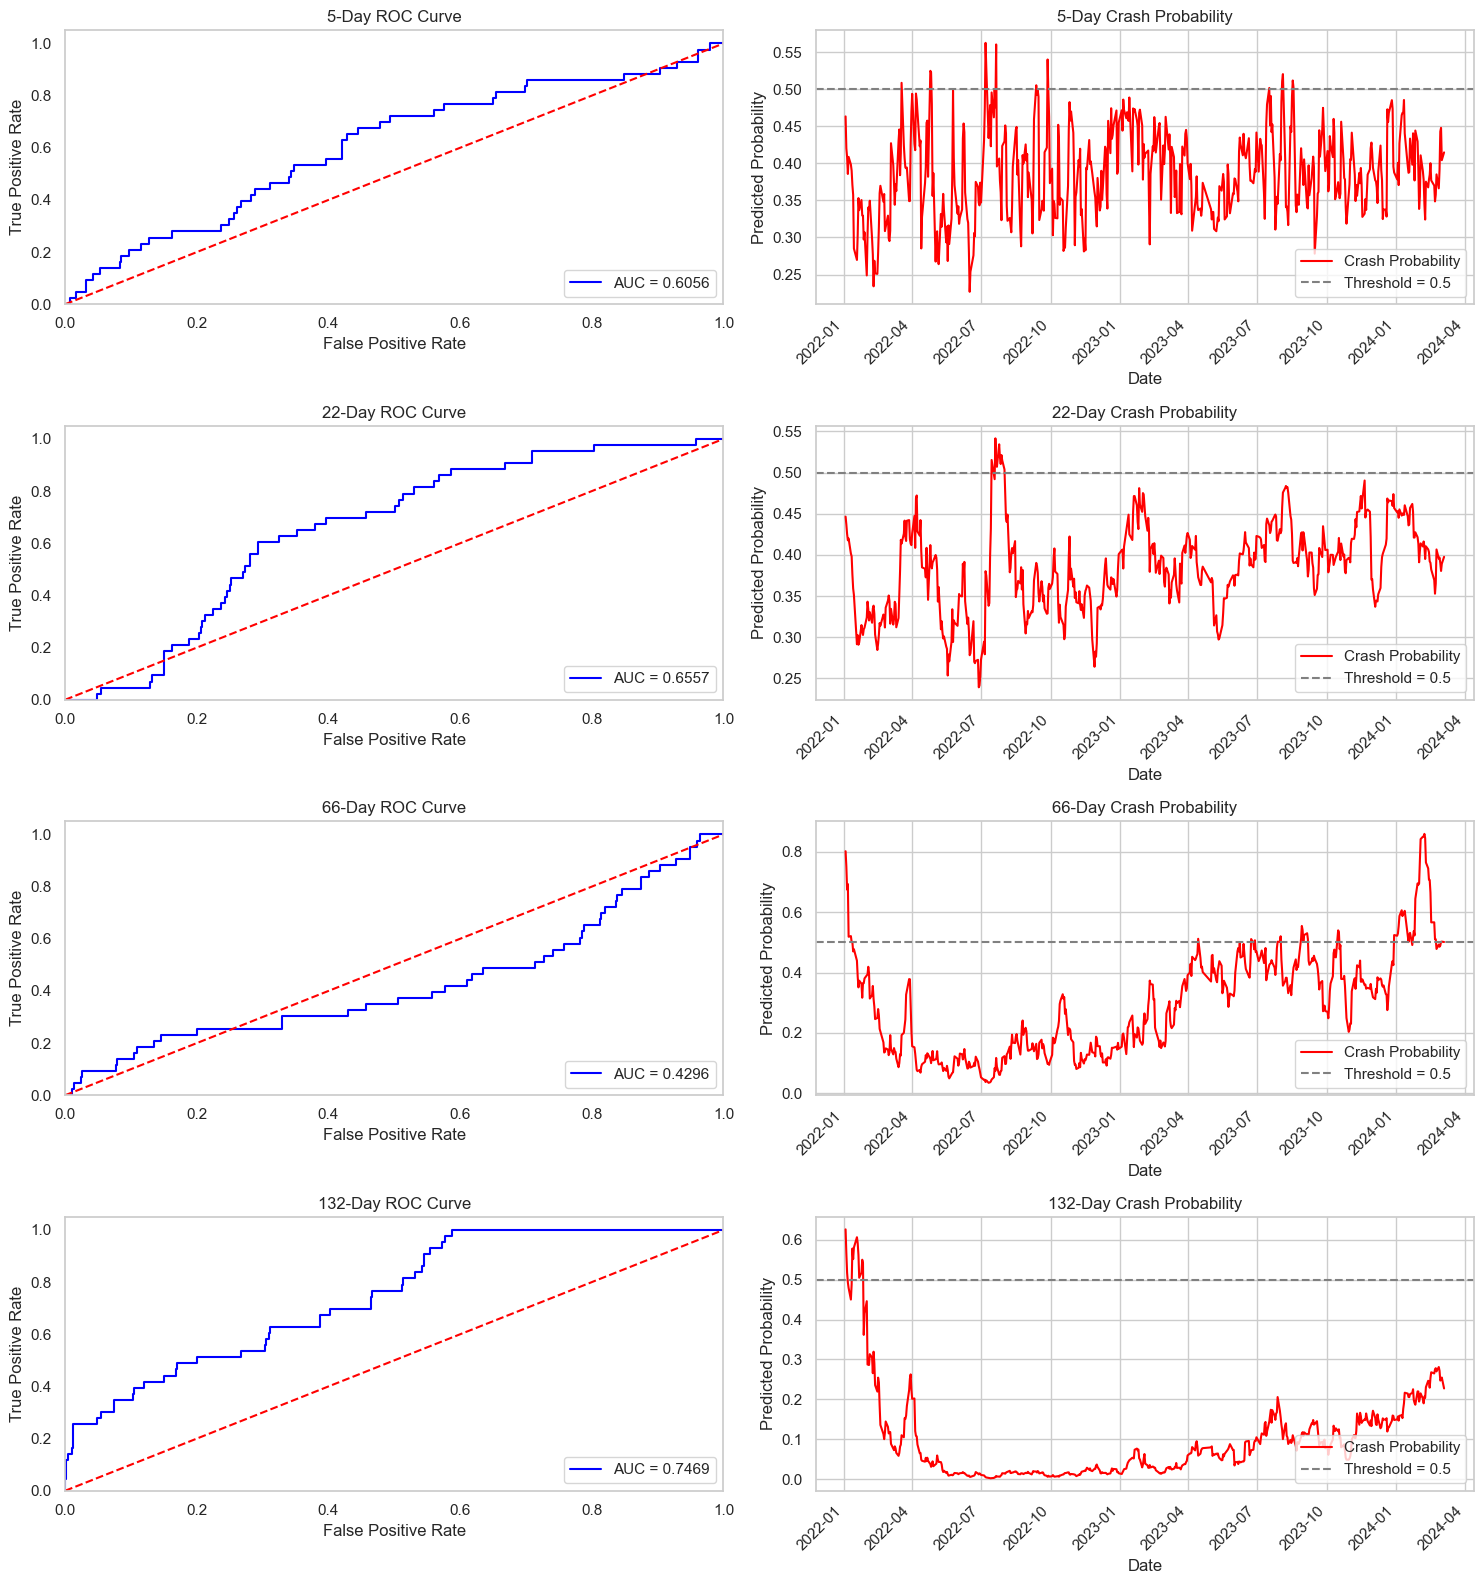

In [51]:
def plot_logit_coefficients_grid(results):
    num_models = len(results)
    cols = 2
    rows = int(np.ceil(num_models / cols))

    fig, axes = plt.subplots(rows, cols, figsize=(12, rows * 3))
    axes = axes.flatten()

    for idx, (n, result) in enumerate(sorted(results.items())):
        coefs_df = result['coefficients']

        sns.barplot(
            x='Coefficient',
            y='Feature',
            data=coefs_df,
            ax=axes[idx],
            palette='coolwarm'
        )
        axes[idx].set_title(f'{n}-Day Coefficients')
        axes[idx].set_xlabel('')
        axes[idx].set_ylabel('')
        axes[idx].tick_params(axis='x', labelsize=10)
        axes[idx].tick_params(axis='y', labelsize=10)

    # Remove unused subplots
    for i in range(idx + 1, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()
    
plot_logit_coefficients_grid(dynamic_logit_combined)
plot_roc_and_crash_probabilities_grid(dynamic_logit_combined, X_test_dict, y_test_dict)

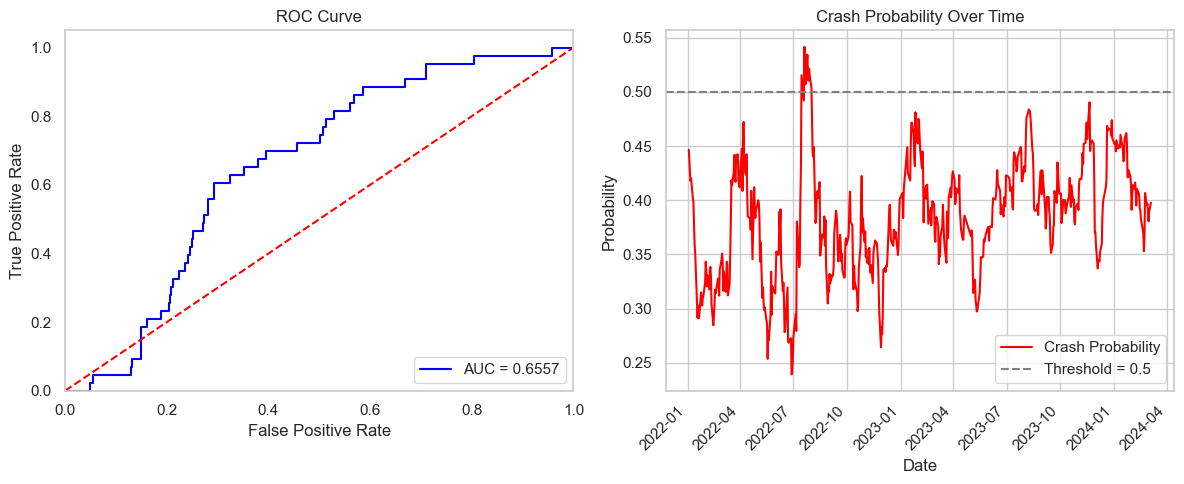

In [52]:
plot_logit_roc_and_crash_prob_for_one(dynamic_logit_combined[22], X_test_dict[22], y_test_dict[22])

## CNN

In [53]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout
from sklearn.utils import class_weight

def cnn_model(n, feature_cols, market_sentiment_data, cnn_results, X_test_dict, y_test_dict, lag=10, window_size=10):
    market_sentiment_data_with_lags = market_sentiment_data.copy()

    train_data = market_sentiment_data_with_lags[market_sentiment_data_with_lags['Date'] < '2022-01-01']
    test_data = market_sentiment_data_with_lags[(market_sentiment_data_with_lags['Date'] >= '2022-01-01')]
    train_df = train_data.dropna(subset=feature_cols+['future_crash']).copy()
    test_df = test_data.dropna(subset=feature_cols+['future_crash']).copy()

    # Prepare feature matrices and target vectors
    X_train = train_df[feature_cols].fillna(train_df[feature_cols].mean())
    y_train = train_df['future_crash']
    X_train_raw = X_train.values
    y_train_raw = y_train.values

    X_test = test_df[feature_cols].fillna(train_df[feature_cols].mean())
    y_test = test_df['future_crash']
    X_test_raw = X_test.values
    y_test_raw = y_test.values

    X_train_resampled, y_train_resampled = X_train_raw, y_train_raw

    # Convert to DataFrame for convenience
    X_train_resampled = pd.DataFrame(X_train_resampled, columns=X_train.columns)
    y_train_resampled = pd.Series(y_train_resampled)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_resampled)
    X_test_scaled = scaler.transform(X_test_raw)

    X_train_seq, y_train_seq, _ = create_sequences(pd.DataFrame(X_train_scaled, columns=X_train.columns), y_train_resampled, window=window_size)
    X_test_seq, y_test_seq, _ = create_sequences(pd.DataFrame(X_test_scaled, columns=X_test.columns), pd.Series(y_test_raw), window=window_size)

    # Define CNN model
    cnn_model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(window_size, X_train_seq.shape[2])),
        MaxPooling1D(pool_size=2),
        Conv1D(filters=128, kernel_size=3, activation='relu'),
        GlobalMaxPooling1D(),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')  # Binary classification
    ])

    cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])

    class_weights_array = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train_seq),
        y=y_train_seq
    )
    class_weight_dict = dict(enumerate(class_weights_array))

    # Train
    cnn_model.fit(X_train_seq, y_train_seq, epochs=10, batch_size=32, validation_split=0.2, verbose=0, 
                class_weight=class_weight_dict)

    y_prob = cnn_model.predict(X_test_seq).flatten()
    best_threshold = dynamic_threshold_calculate(y_test_seq, y_prob)
    y_pred = (y_prob > best_threshold).astype(int)

    # Evaluate
    auc_score = roc_auc_score(y_test_seq, y_prob)
    report = classification_report(y_test_seq, y_pred, output_dict=True)
    conf = confusion_matrix(y_test_seq, y_pred)
    date_seq = test_df['Date'].iloc[window_size:].reset_index(drop=True)
    
    # Save model and results
    cnn_results[n] = {
        'model': cnn_model,
        'auc_score': auc_score,
        'report': report,
        'y_test': y_test_seq,
        'y_prob': y_prob,
        'features': feature_cols,
        'confusion': conf,
        'date_seq': date_seq,
    }

    X_test_dict[n] = X_test_seq
    y_test_dict[n] = y_test_seq

    print(f"\n=== {n}-Day CNN Model ===")
    print(f"AUC: {auc_score:.3f}")
    print(classification_report(y_test_seq, y_pred))

### CNN (Market)

In [54]:
cnn_market = {}
X_test_dict = {}
y_test_dict = {}
window_size = 10

for n in volatility_period:
    feature_cols = [
        f'{n}_day_market_volatility',
        f'VaR_{n}',
        f'ES_{n}',
    ]

    cnn_model(n, feature_cols, market_sentiment_data, cnn_market, X_test_dict, y_test_dict, lag=10, window_size=window_size)

all_results.append(cnn_market)    

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Best threshold: 0.37, F1: 0.15

=== 5-Day CNN Model ===
AUC: 0.468
              precision    recall  f1-score   support

           0       0.99      0.28      0.43       495
           1       0.08      0.94      0.15        33

    accuracy                           0.32       528
   macro avg       0.53      0.61      0.29       528
weighted avg       0.93      0.32      0.42       528

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Best threshold: 0.63, F1: 0.28

=== 22-Day CNN Model ===
AUC: 0.778
              precision    recall  f1-score   support

           0       0.98      0.75      0.85       495
           1       0.16      0.73      0.27        33

    accuracy                           0.75       528
   macro avg       0.57      0.74      0.56       528
weighted avg       0.93      0.75      0.81       528

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Best threshold: 0.02, F1: 0.17

=== 66-Day CNN Model ===
AUC: 0.418
              precision   

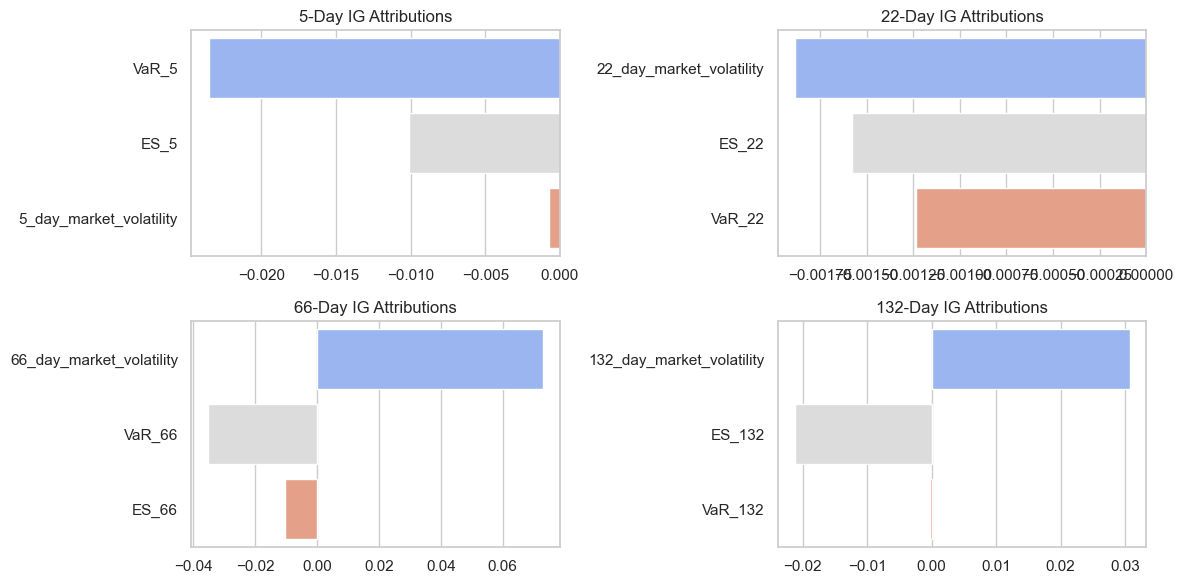

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


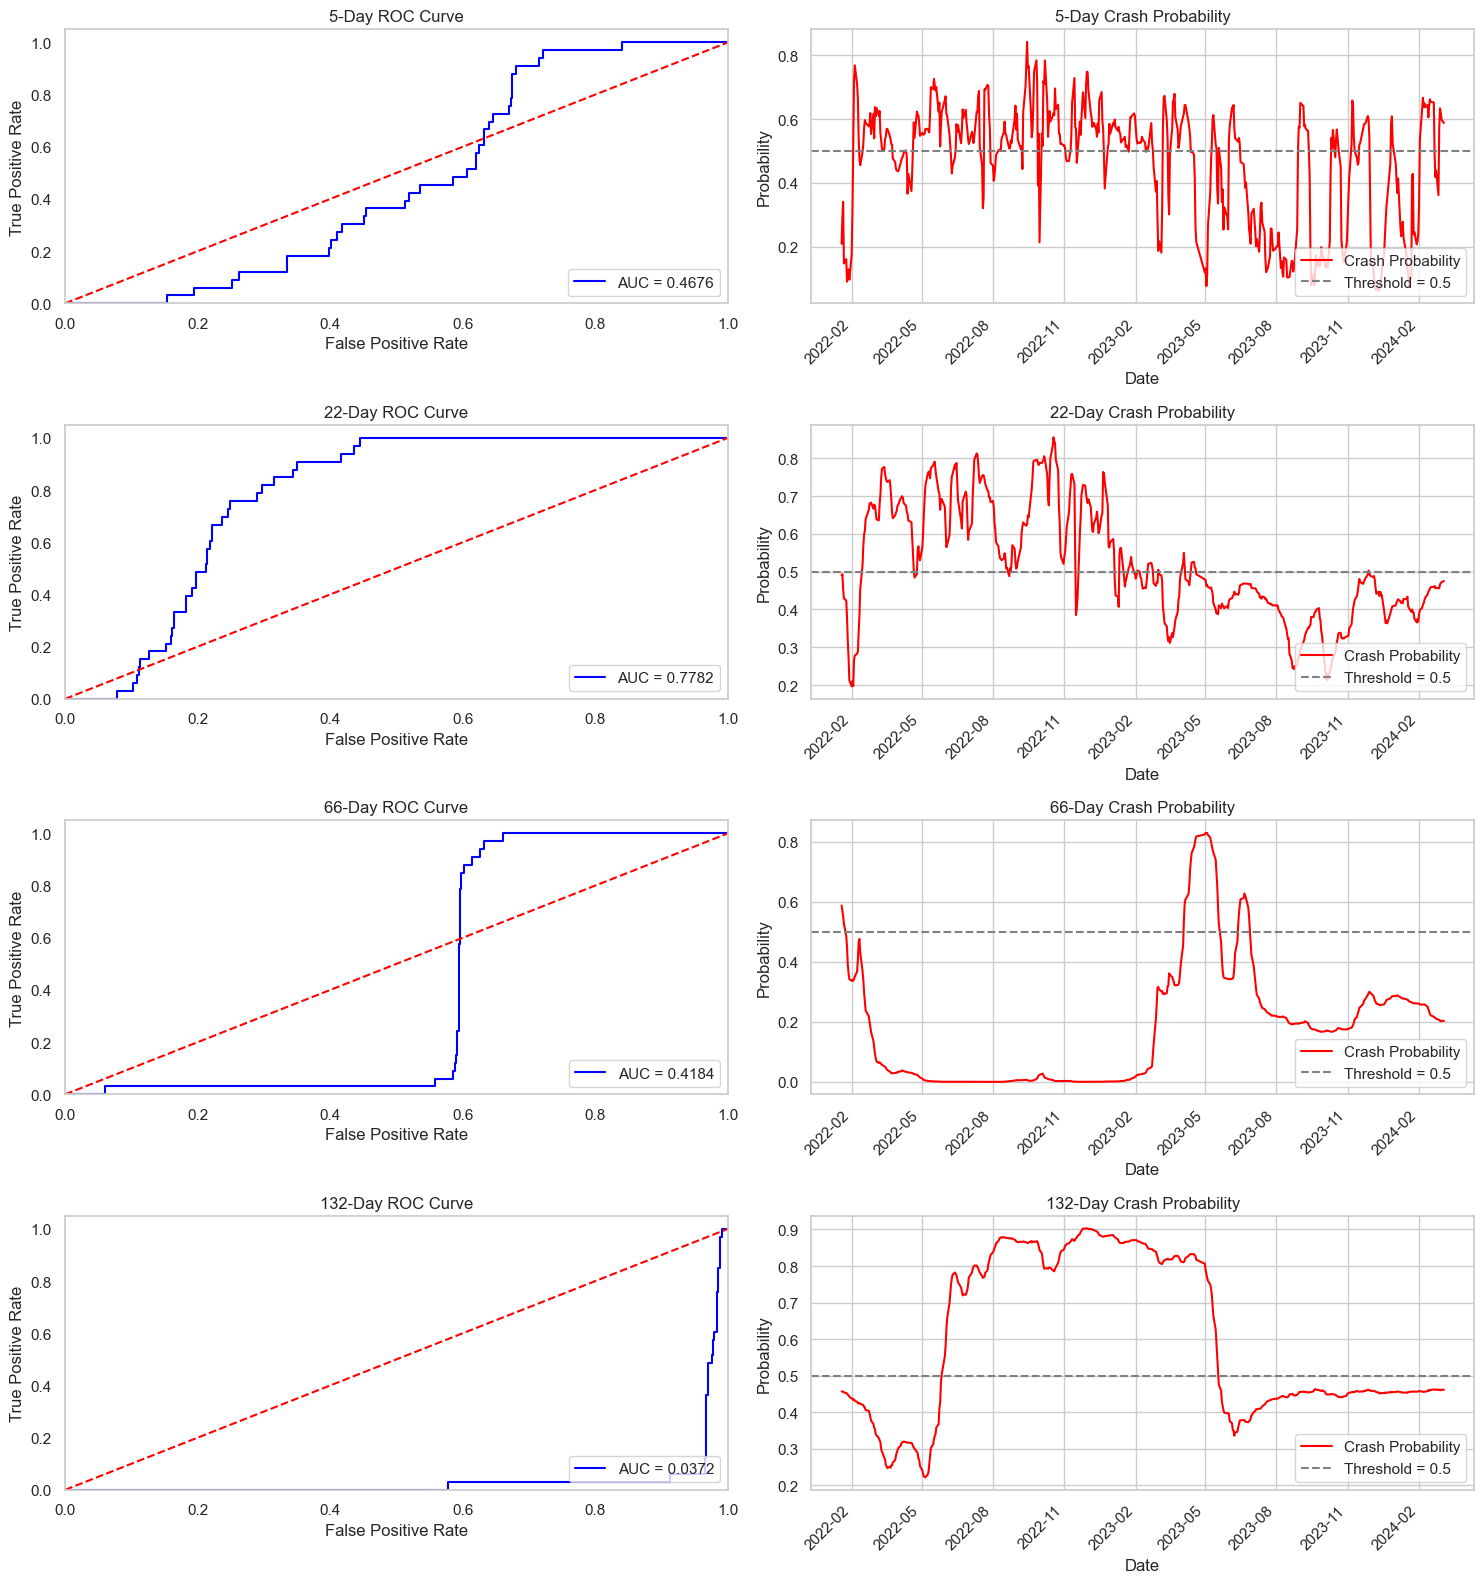

In [55]:
plot_ig_feature_attributions_grid(cnn_market, X_test_dict, window_size=window_size)
plot_CNN_roc_and_crash_probabilities(cnn_market, X_test_dict, y_test_dict)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


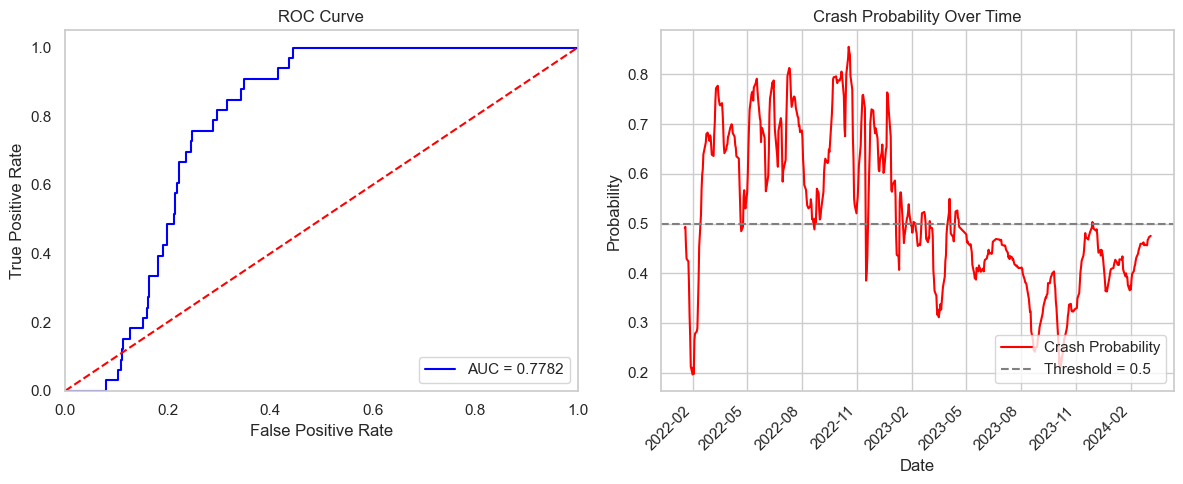

In [56]:
plot_CNN_roc_and_crash_prob_for_one(cnn_market[22], X_test_dict[22], y_test_dict[22])

### CNN (Sentiment)

In [57]:
cnn_sentiment = {}
X_test_dict = {}
y_test_dict = {}

for n in volatility_period:
    feature_cols = [
        f'{n}_day_sentiment_volatility',
    ]

    cnn_model(n, feature_cols, market_sentiment_data, cnn_sentiment, X_test_dict, y_test_dict, lag=10, window_size=window_size)

all_results.append(cnn_sentiment)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Best threshold: 0.18, F1: 0.31

=== 5-Day CNN Model ===
AUC: 0.707
              precision    recall  f1-score   support

           0       0.96      0.92      0.94       495
           1       0.24      0.39      0.30        33

    accuracy                           0.88       528
   macro avg       0.60      0.65      0.62       528
weighted avg       0.91      0.88      0.90       528

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Best threshold: 0.09, F1: 0.27

=== 22-Day CNN Model ===
AUC: 0.774
              precision    recall  f1-score   support

           0       0.97      0.77      0.86       495
           1       0.16      0.67      0.26        33

    accuracy                           0.76       528
   macro avg       0.57      0.72      0.56       528
weighted avg       0.92      0.76      0.82       528

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Best threshold: 0.00, F1: 0.13

=== 66-Day CNN Model ===
AUC: 0.291
              precision   

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


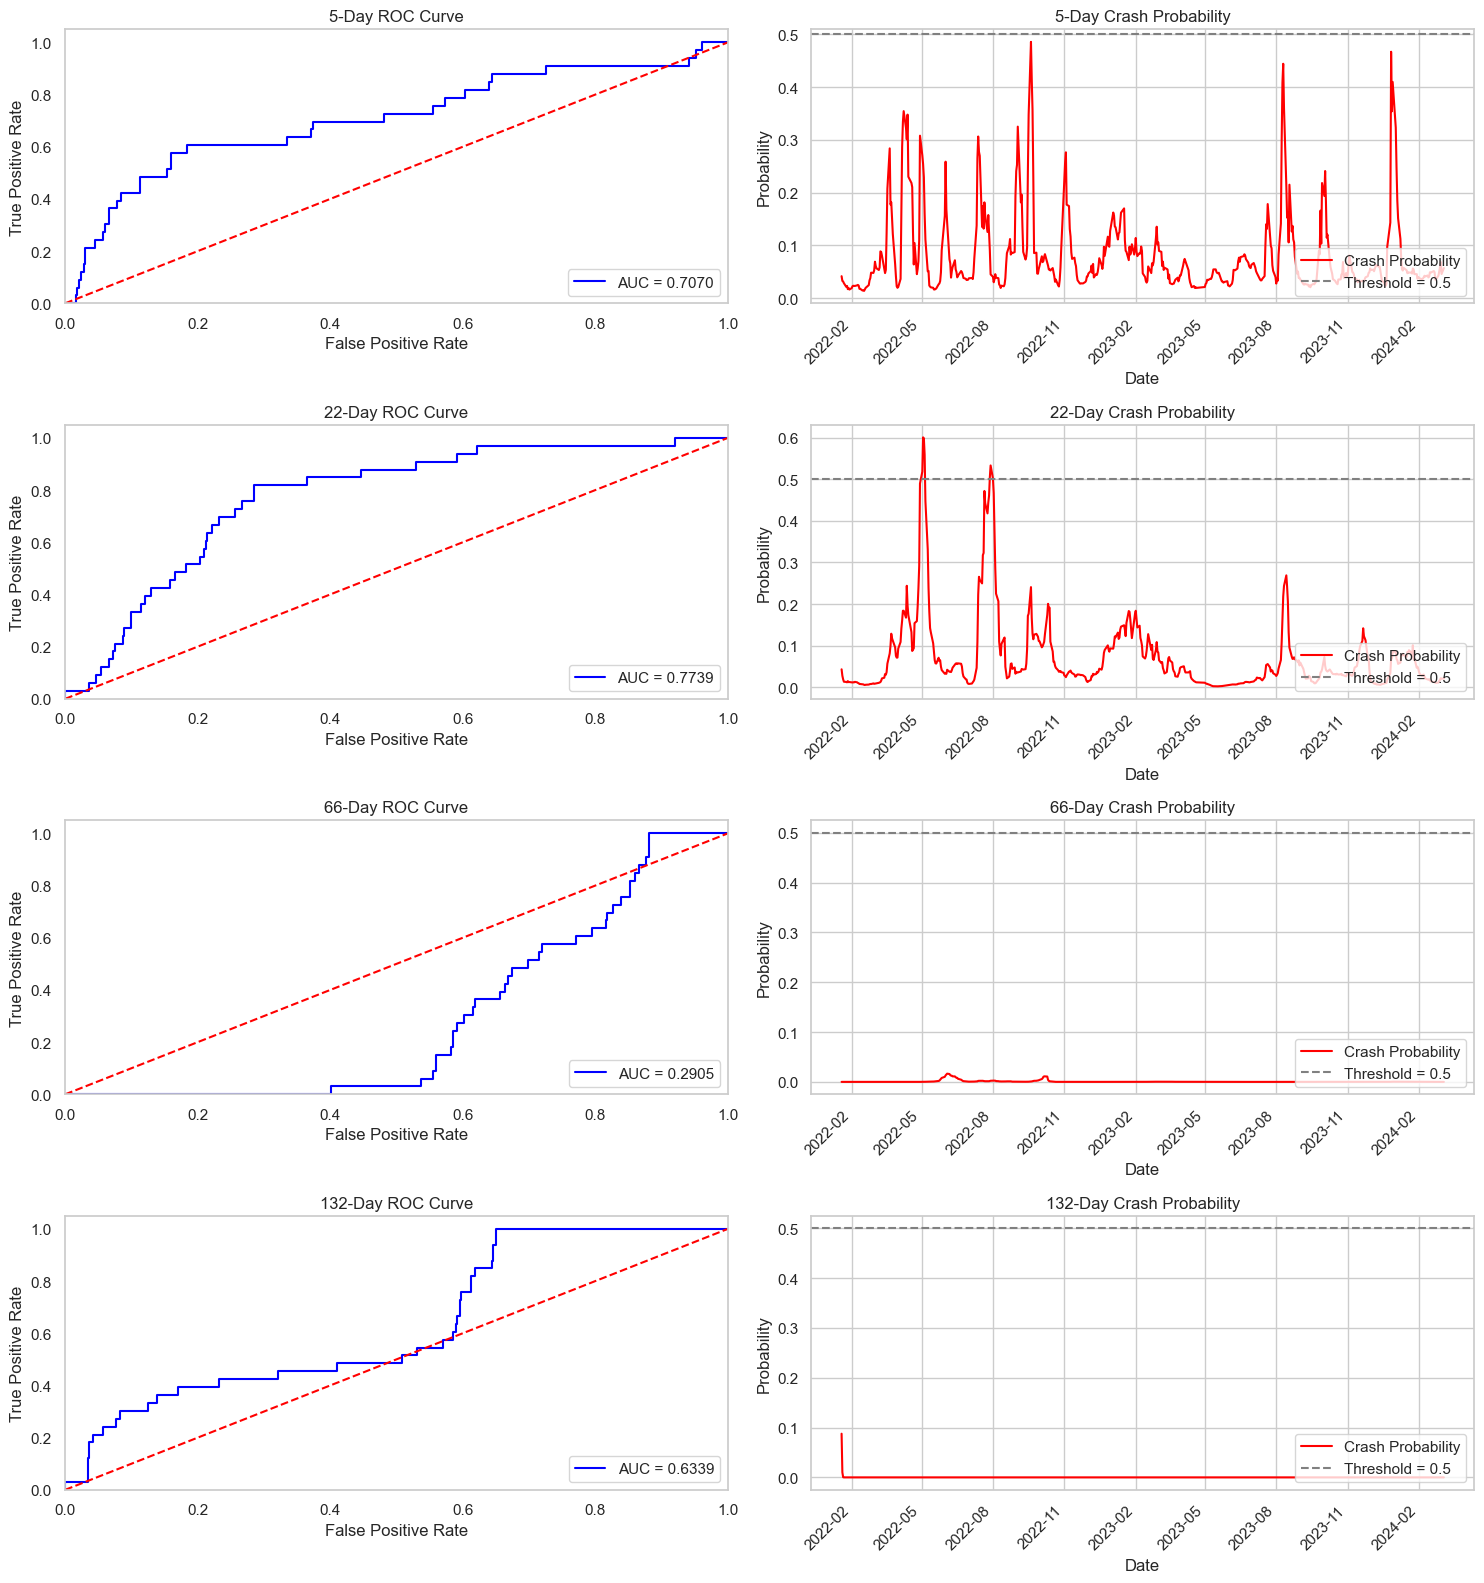

In [58]:
plot_CNN_roc_and_crash_probabilities(cnn_sentiment, X_test_dict, y_test_dict)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


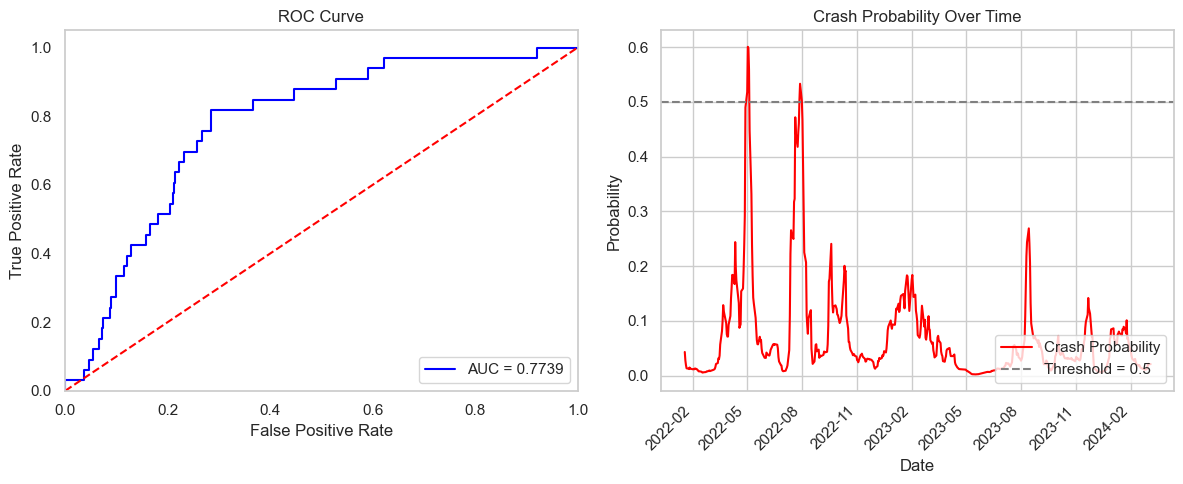

In [59]:
plot_CNN_roc_and_crash_prob_for_one(cnn_sentiment[22], X_test_dict[22], y_test_dict[22])

### CNN (Market + Sentiment)

In [60]:
cnn_combined = {}
X_test_dict = {}
y_test_dict = {}

for n in volatility_period:
    feature_cols = [
        f'{n}_day_sentiment_volatility',
        f'{n}_day_market_volatility',
        f'VaR_{n}',
        f'ES_{n}',
    ]

    cnn_model(n, feature_cols, market_sentiment_data, cnn_combined, X_test_dict, y_test_dict, lag=10, window_size=window_size)

all_results.append(cnn_combined)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Best threshold: 0.22, F1: 0.15

=== 5-Day CNN Model ===
AUC: 0.540
              precision    recall  f1-score   support

           0       0.94      0.91      0.93       495
           1       0.10      0.15      0.12        33

    accuracy                           0.87       528
   macro avg       0.52      0.53      0.53       528
weighted avg       0.89      0.87      0.88       528

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Best threshold: 0.00, F1: 0.14

=== 22-Day CNN Model ===
AUC: 0.348
              precision    recall  f1-score   support

           0       0.99      0.17      0.29       495
           1       0.07      0.97      0.13        33

    accuracy                           0.22       528
   macro avg       0.53      0.57      0.21       528
weighted avg       0.93      0.22      0.28       528

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Best threshold: 0.00, F1: 0.14

=== 66-Day CNN Model ===
AUC: 0.351
              precision   

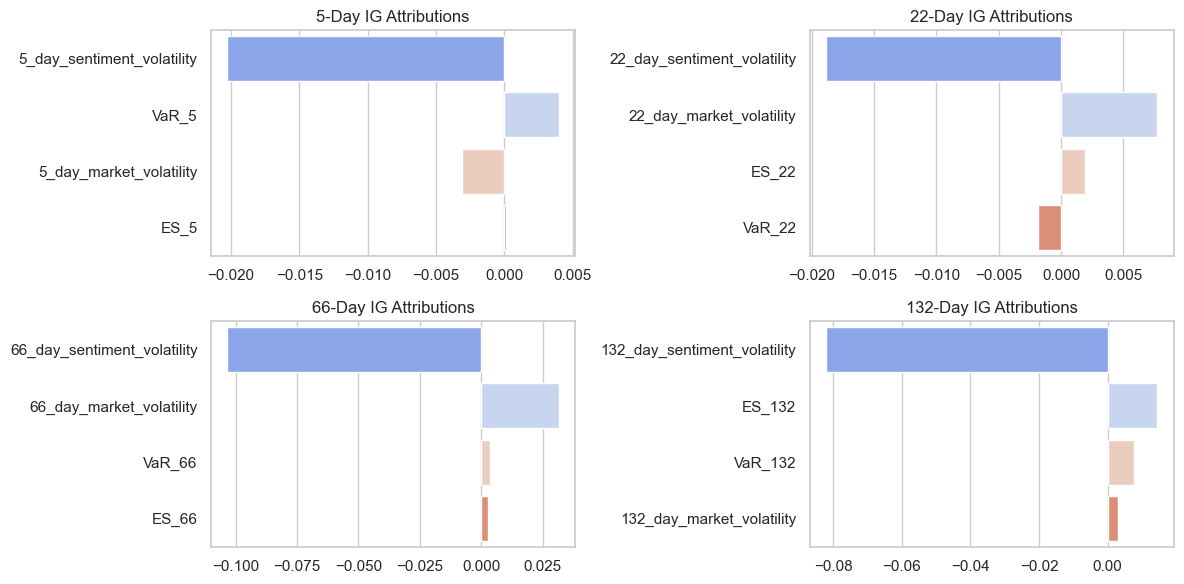

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


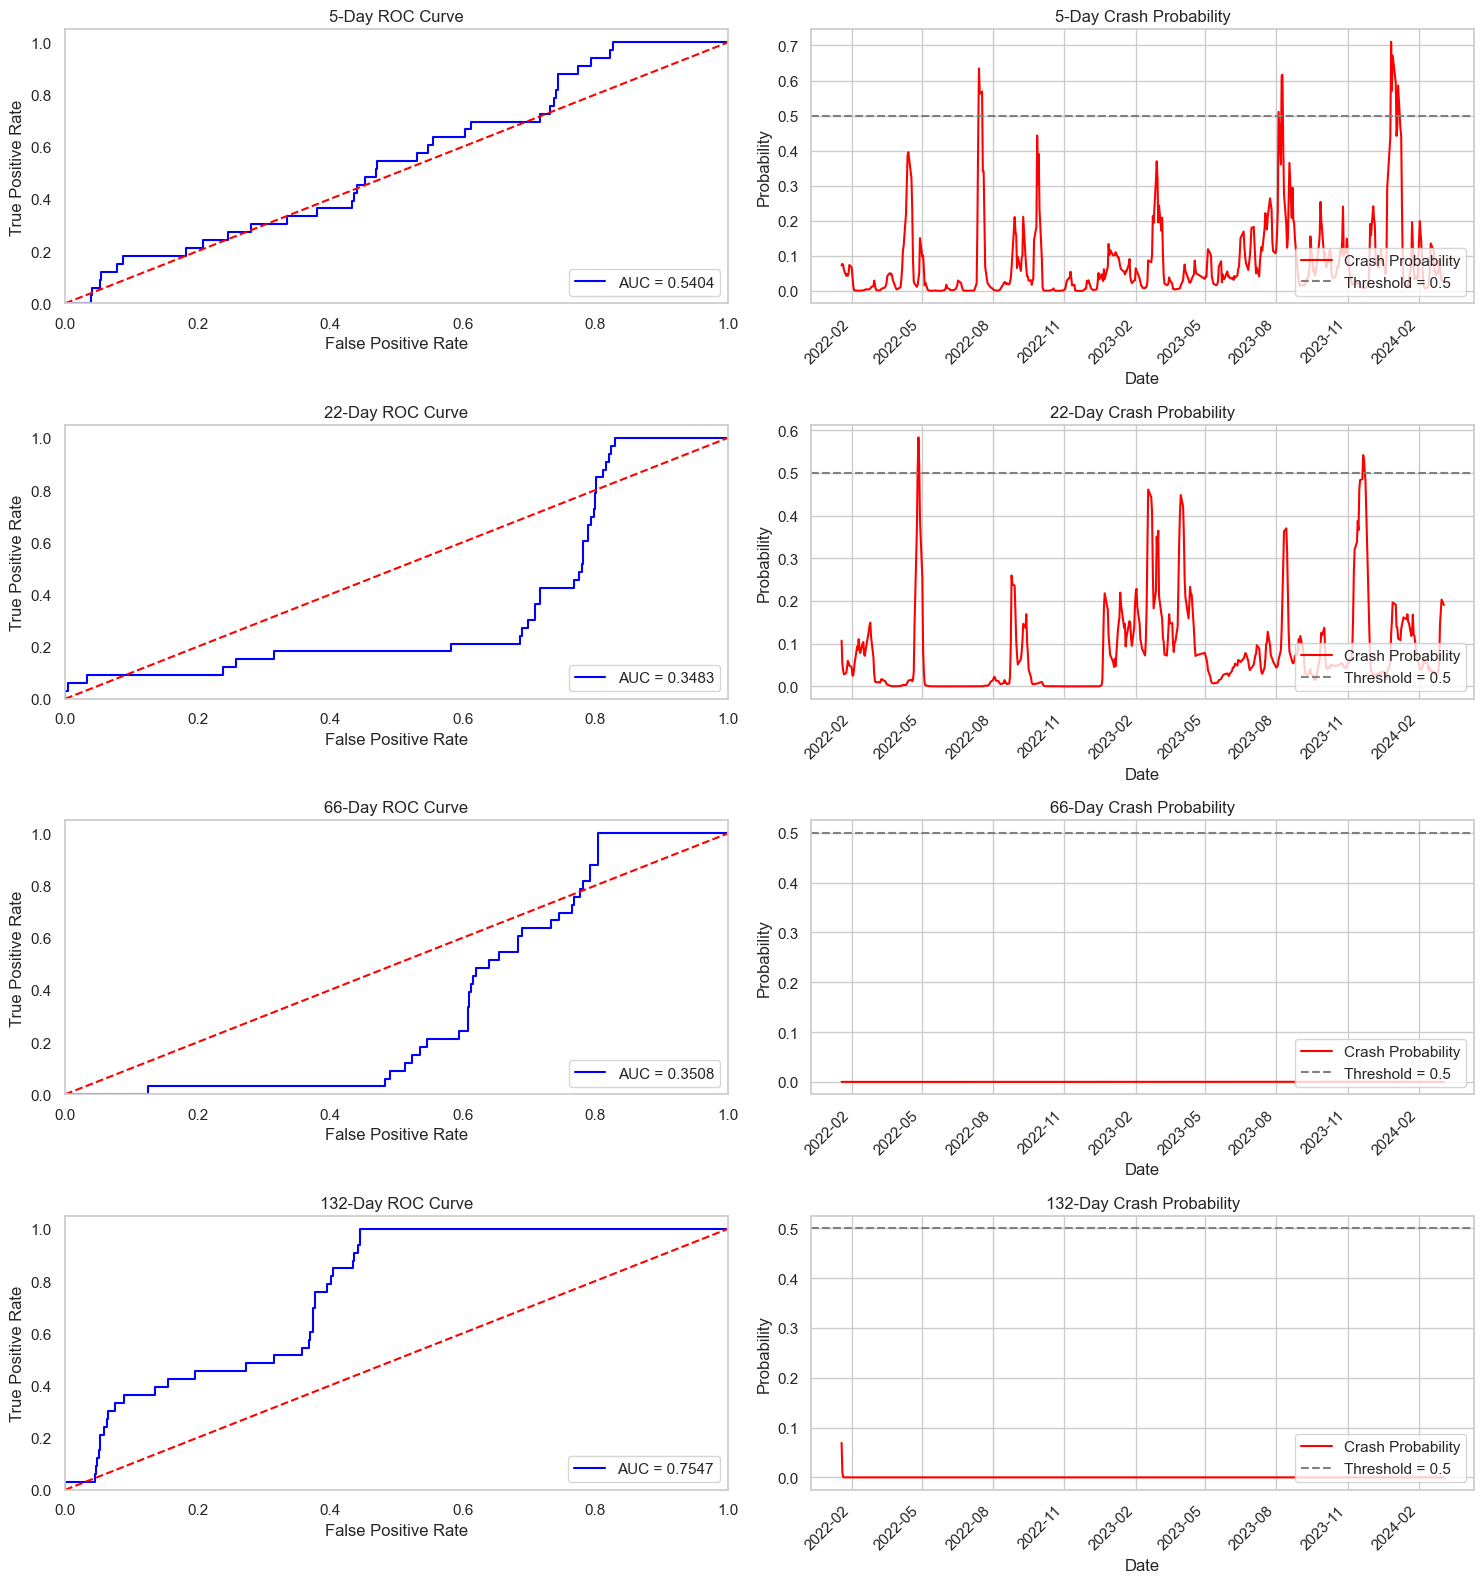

In [61]:
plot_ig_feature_attributions_grid(cnn_combined, X_test_dict, window_size=window_size)
plot_CNN_roc_and_crash_probabilities(cnn_combined, X_test_dict, y_test_dict)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


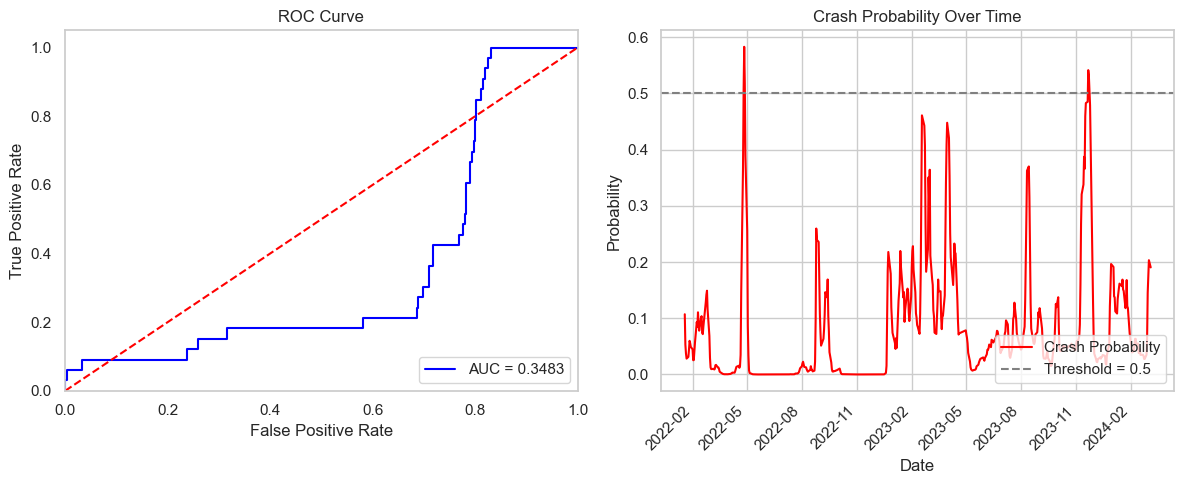

In [62]:
plot_CNN_roc_and_crash_prob_for_one(cnn_combined[22], X_test_dict[22], y_test_dict[22])

## LSTM

In [63]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def lstm_model(n, feature_cols, market_sentiment_data, lstm_results, X_test_dict, y_test_dict):
    train_data = market_sentiment_data[market_sentiment_data['Date'] < '2022-01-01']
    test_data = market_sentiment_data[(market_sentiment_data['Date'] >= '2022-01-01')]
    train_df = train_data.dropna(subset=feature_cols+['future_crash']).copy()
    test_df = test_data.dropna(subset=feature_cols+['future_crash']).copy()

    # Prepare feature matrices and target vectors
    X_train = train_df[feature_cols].fillna(train_df[feature_cols].mean())
    y_train = train_df['future_crash']
    X_train_raw = X_train.values
    y_train_raw = y_train.values

    X_test = test_df[feature_cols].fillna(train_df[feature_cols].mean())
    y_test = test_df['future_crash']
    X_test_raw = X_test.values
    y_test_raw = y_test.values

    # X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)
    X_train_resampled, y_train_resampled = X_train_raw, y_train_raw  # For simplicity, using original training data without resampling

    # Convert to DataFrame for convenience
    X_train_resampled = pd.DataFrame(X_train_resampled, columns=X_train.columns)
    y_train_resampled = pd.Series(y_train_resampled)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_resampled)
    X_test_scaled = scaler.transform(X_test_raw)

    X_train, y_train, _ = create_sequences(pd.DataFrame(X_train_scaled, columns=X_train.columns), y_train_resampled, window=window_size)
    X_test, y_test, _ = create_sequences(pd.DataFrame(X_test_scaled, columns=X_test.columns), pd.Series(y_test_raw), window=window_size)


    lstm_model = Sequential([
        LSTM(64, return_sequences=False, input_shape=(window_size, X_train.shape[2])),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])

    lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['AUC'])

    lstm_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

    # Predict
    y_prob = lstm_model.predict(X_test).flatten()
    best_threshold = dynamic_threshold_calculate(y_test, y_prob)
    y_pred = (y_prob > best_threshold).astype(int)

    # Evaluate
    auc_score = roc_auc_score(y_test, y_prob)
    report = classification_report(y_test, y_pred, output_dict=True)
    conf = confusion_matrix(y_test, y_pred)
    date_seq = test_df['Date'].iloc[window_size:].reset_index(drop=True)

    # Save model and results
    lstm_results[n] = {
        'model': lstm_model,
        'auc_score': auc_score,
        'report': report,
        'y_test': y_test,
        'y_prob': y_prob,
        'features': feature_cols,
        'confusion': conf,
        'date_seq': date_seq,
    }

    X_test_dict[n] = X_test
    y_test_dict[n] = y_test

    print(f"\n=== {n}-Day LSTM Model ===")
    print(f"AUC: {auc_score:.3f}")
    print(report)

### LSTM (Market)

In [64]:
lstm_market = {}
X_test_dict = {}
y_test_dict = {}
window_size = 10  # Default window size 

for n in volatility_period:
    feature_cols = [
        f'{n}_day_market_volatility',
        f'VaR_{n}',
        f'ES_{n}',
    ]
    
    lstm_model(n, feature_cols, market_sentiment_data, lstm_market, X_test_dict, y_test_dict)

all_results.append(lstm_market)

Epoch 1/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - AUC: 0.6206 - loss: 0.4631 - val_AUC: 0.5324 - val_loss: 0.4025
Epoch 2/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7024 - loss: 0.1593 - val_AUC: 0.4865 - val_loss: 0.3888
Epoch 3/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.6706 - loss: 0.1363 - val_AUC: 0.4601 - val_loss: 0.4212
Epoch 4/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.6800 - loss: 0.1543 - val_AUC: 0.4567 - val_loss: 0.4214
Epoch 5/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.6825 - loss: 0.1609 - val_AUC: 0.4489 - val_loss: 0.4223
Epoch 6/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7201 - loss: 0.1564 - val_AUC: 0.4462 - val_loss: 0.4288
Epoch 7/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.6449 - loss: 0.1620 - val_AUC: 0.4550 - val_loss: 0.4405
Epoch 8/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7145 - loss: 0.1440 - val_AUC: 0.4538 - val_loss: 0.4216
Epoch 9/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.6820 - loss: 

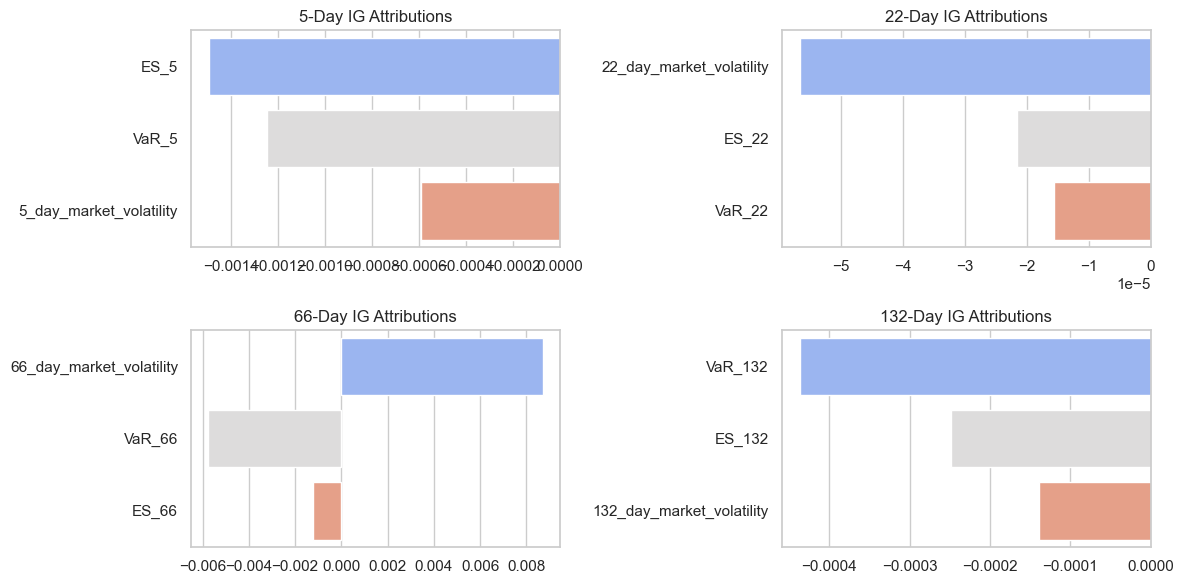

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


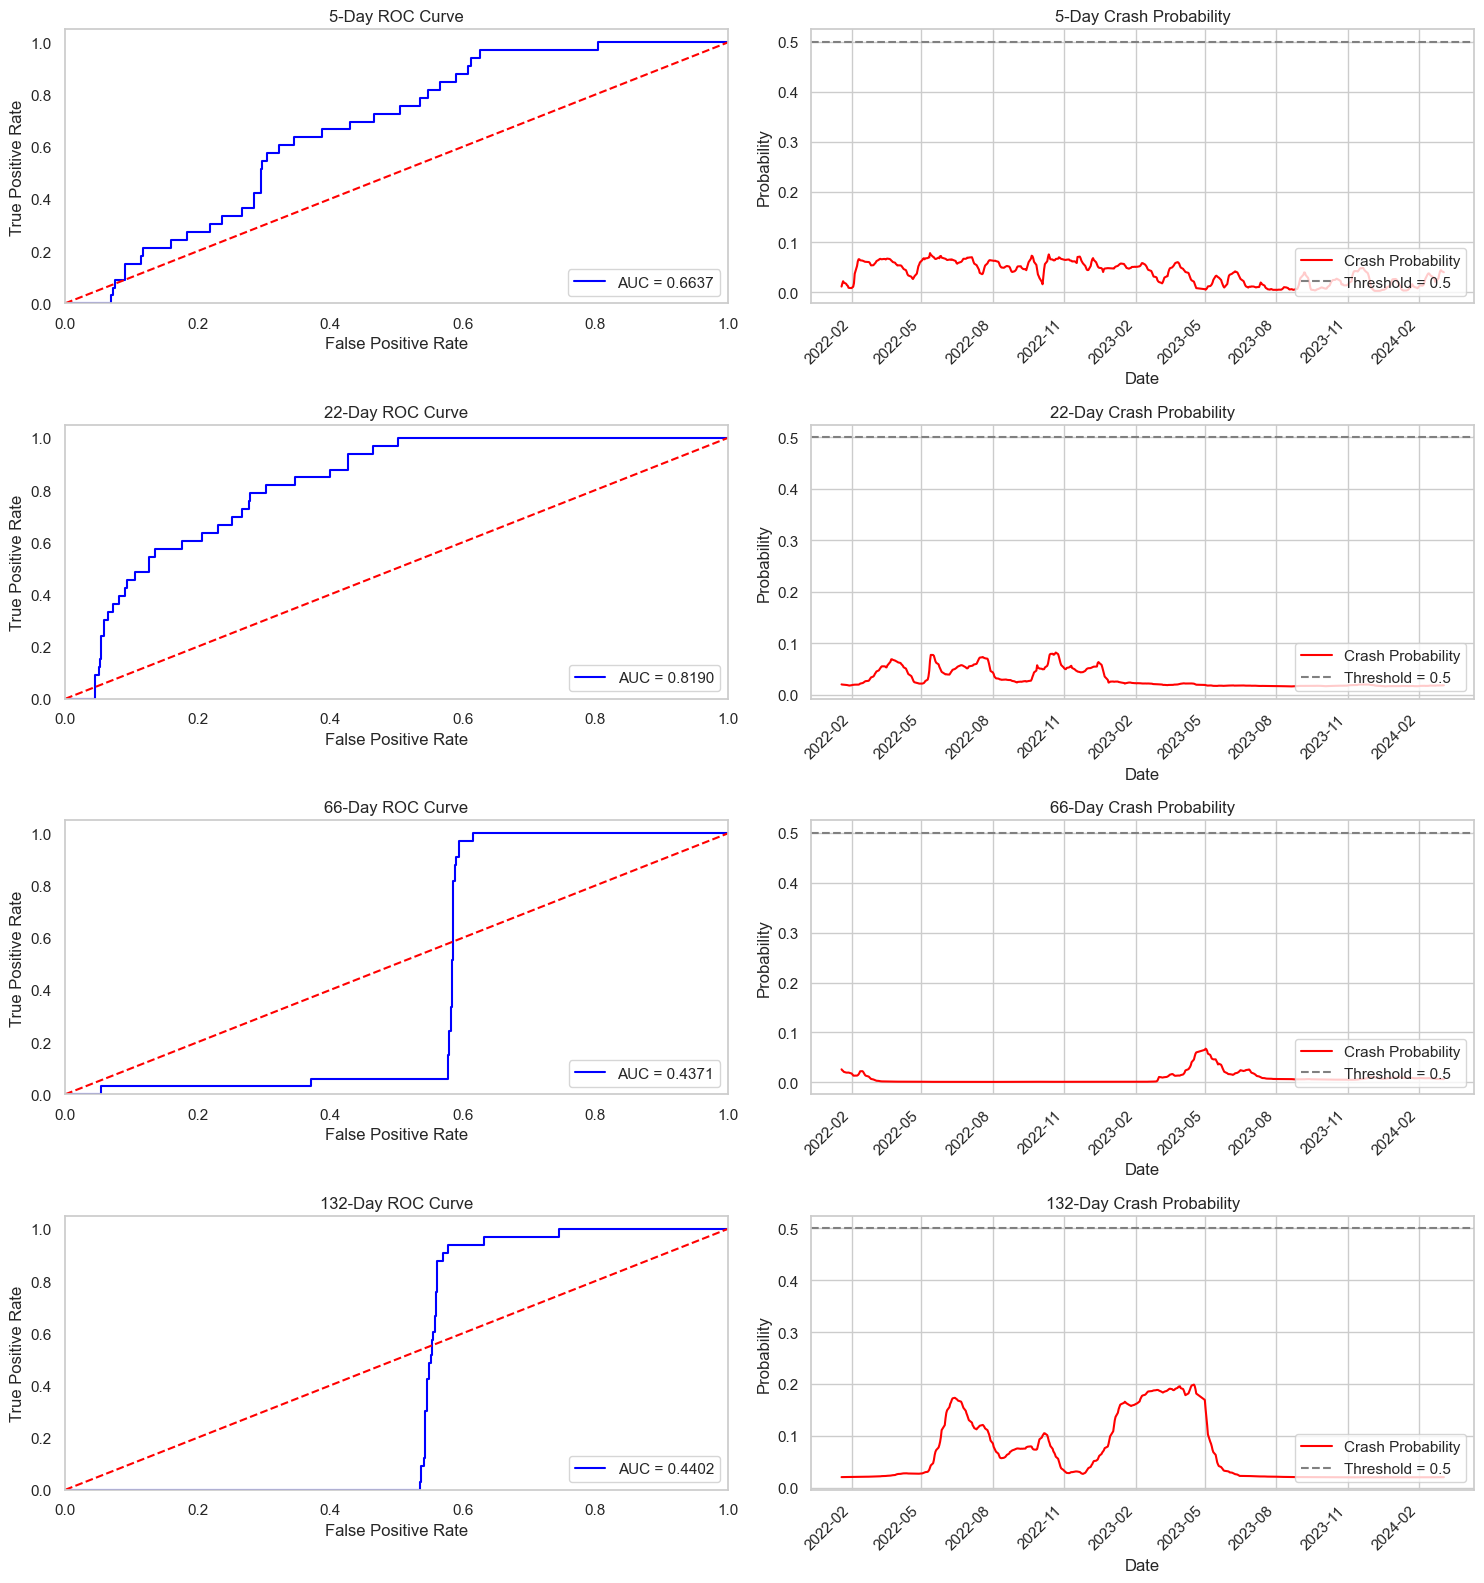

In [65]:
plot_ig_feature_attributions_grid(lstm_market, X_test_dict, window_size=window_size)
plot_CNN_roc_and_crash_probabilities(lstm_market, X_test_dict, y_test_dict)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


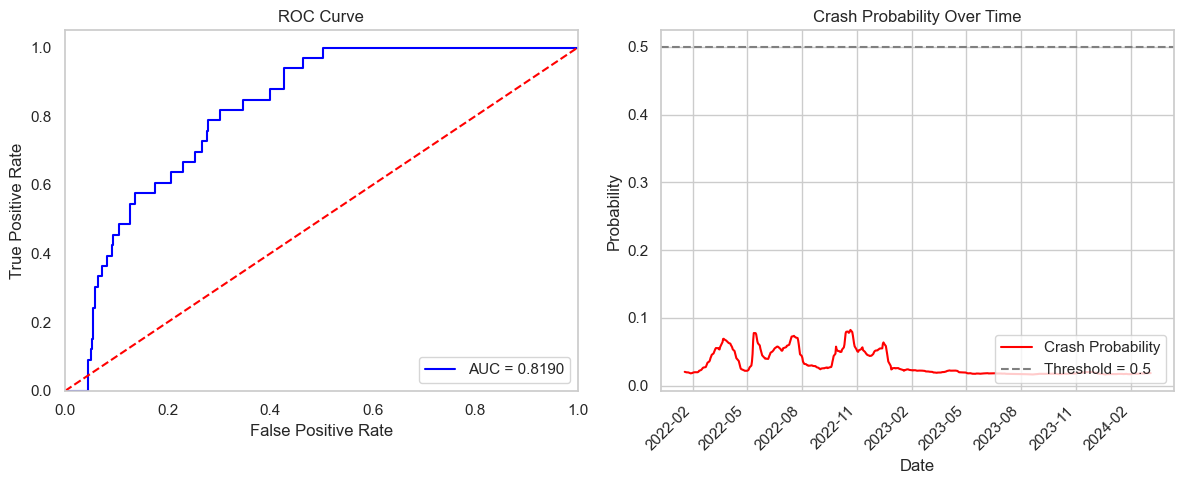

In [66]:
plot_CNN_roc_and_crash_prob_for_one(lstm_market[22], X_test_dict[22], y_test_dict[22])

### LSTM (Sentiment)

In [67]:
lstm_sentiment = {}
X_test_dict = {}
y_test_dict = {}

for n in volatility_period:
    feature_cols = [
        f'{n}_day_sentiment_volatility',
    ]
    
    lstm_model(n, feature_cols, market_sentiment_data, lstm_sentiment, X_test_dict, y_test_dict)

all_results.append(lstm_sentiment)

Epoch 1/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - AUC: 0.4962 - loss: 0.4764 - val_AUC: 0.3928 - val_loss: 0.5229
Epoch 2/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6688 - loss: 0.1219 - val_AUC: 0.4201 - val_loss: 0.4969
Epoch 3/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7401 - loss: 0.1262 - val_AUC: 0.4201 - val_loss: 0.5104
Epoch 4/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7985 - loss: 0.1272 - val_AUC: 0.4055 - val_loss: 0.5019
Epoch 5/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7003 - loss: 0.1555 - val_AUC: 0.4442 - val_loss: 0.5755
Epoch 6/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.8096 - loss: 0.1232 - val_AUC: 0.3785 - val_loss: 0.4796
Epoch 7/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7657 - loss: 0.1262 - val_AUC: 0.3686 - val_loss: 0.4696
Epoch 8/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.8258 - loss: 0.1168 - val_AUC: 0.3858 - val_loss: 0.4575
Epoch 9/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.8070 - loss: 

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


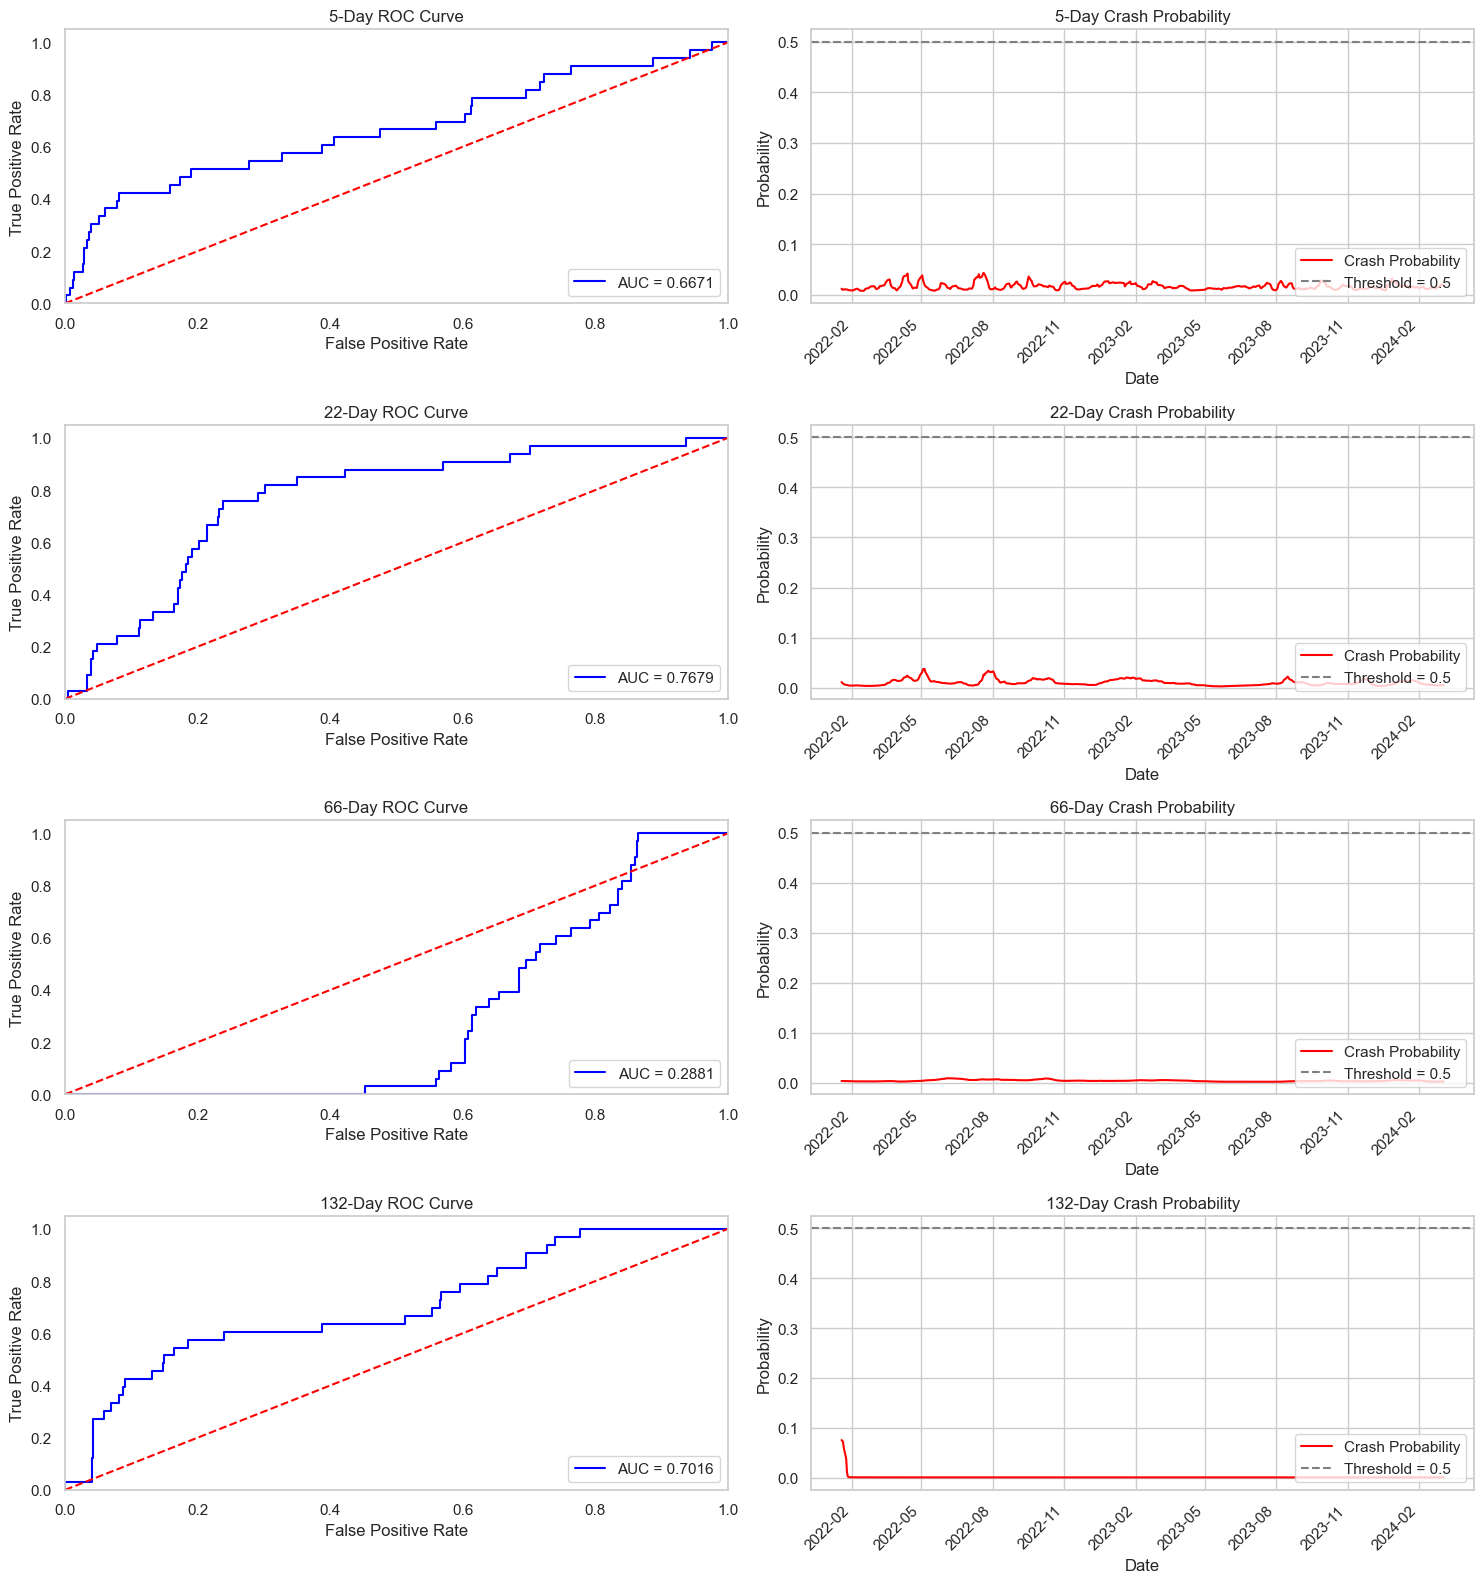

In [68]:
plot_CNN_roc_and_crash_probabilities(lstm_sentiment, X_test_dict, y_test_dict)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


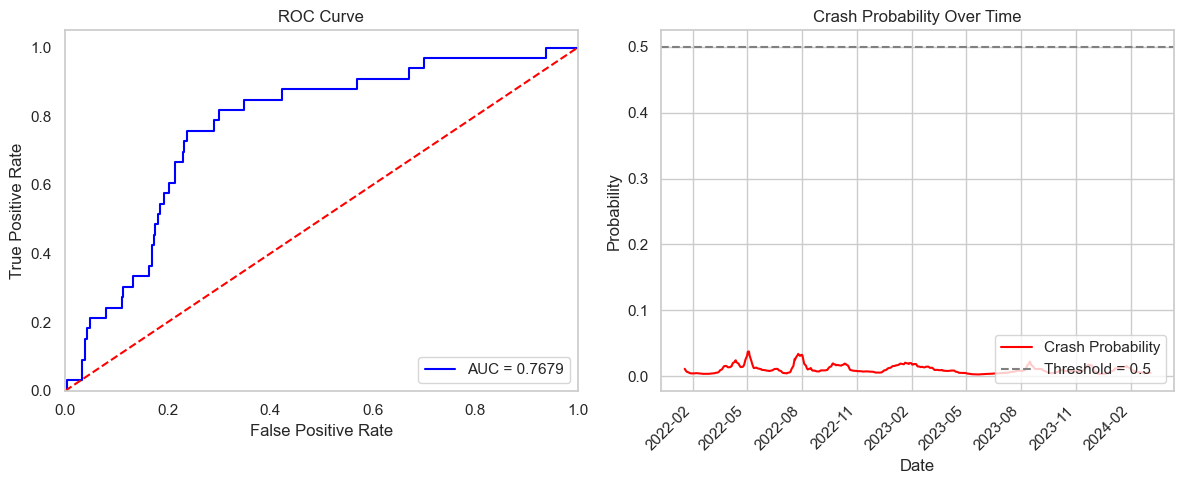

In [69]:
plot_CNN_roc_and_crash_prob_for_one(lstm_sentiment[22], X_test_dict[22], y_test_dict[22])

### LSTM (Market + Sentiment)

In [70]:
lstm_combined = {}
X_test_dict = {}
y_test_dict = {}

for n in volatility_period:
    feature_cols = [
        f'{n}_day_sentiment_volatility',
        f'{n}_day_market_volatility',
        f'VaR_{n}',
        f'ES_{n}',
    ]
    
    lstm_model(n, feature_cols, market_sentiment_data, lstm_combined, X_test_dict, y_test_dict)

all_results.append(lstm_combined)

Epoch 1/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - AUC: 0.5322 - loss: 0.4691 - val_AUC: 0.4214 - val_loss: 0.4957
Epoch 2/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7382 - loss: 0.1207 - val_AUC: 0.4101 - val_loss: 0.4747
Epoch 3/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7704 - loss: 0.1006 - val_AUC: 0.3988 - val_loss: 0.4744
Epoch 4/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8507 - loss: 0.1071 - val_AUC: 0.4118 - val_loss: 0.4274
Epoch 5/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8567 - loss: 0.0930 - val_AUC: 0.4102 - val_loss: 0.4682
Epoch 6/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.8373 - loss: 0.1119 - val_AUC: 0.4685 - val_loss: 0.4986
Epoch 7/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.8680 - loss: 0.1146 - val_AUC: 0.4503 - val_loss: 0.5083
Epoch 8/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.8514 - loss: 0.0941 - val_AUC: 0.4440 - val_loss: 0.5333
Epoch 9/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8362 - loss: 

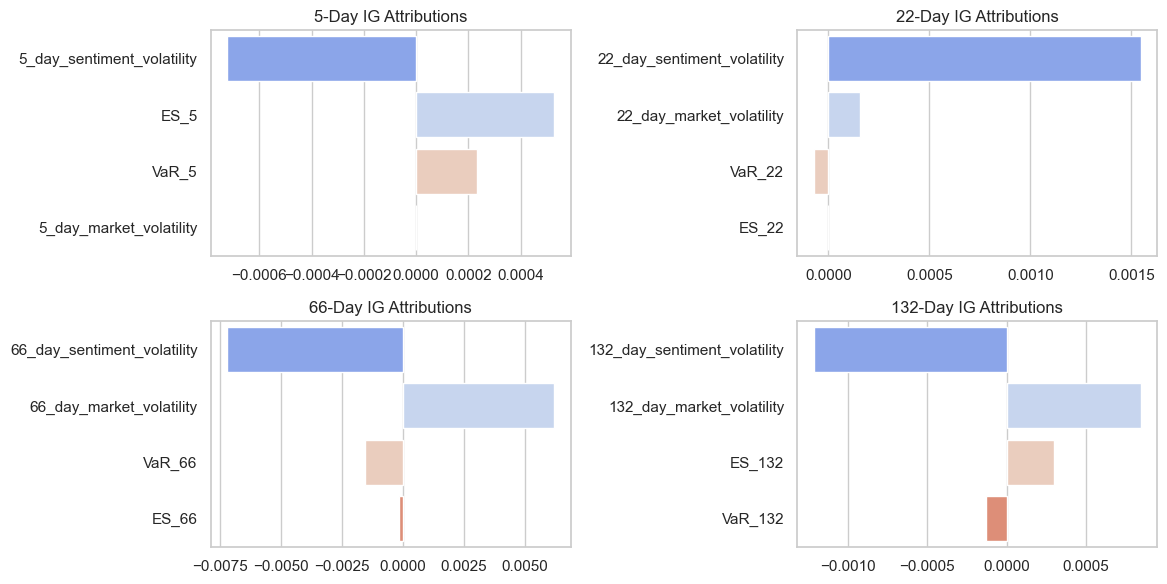

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


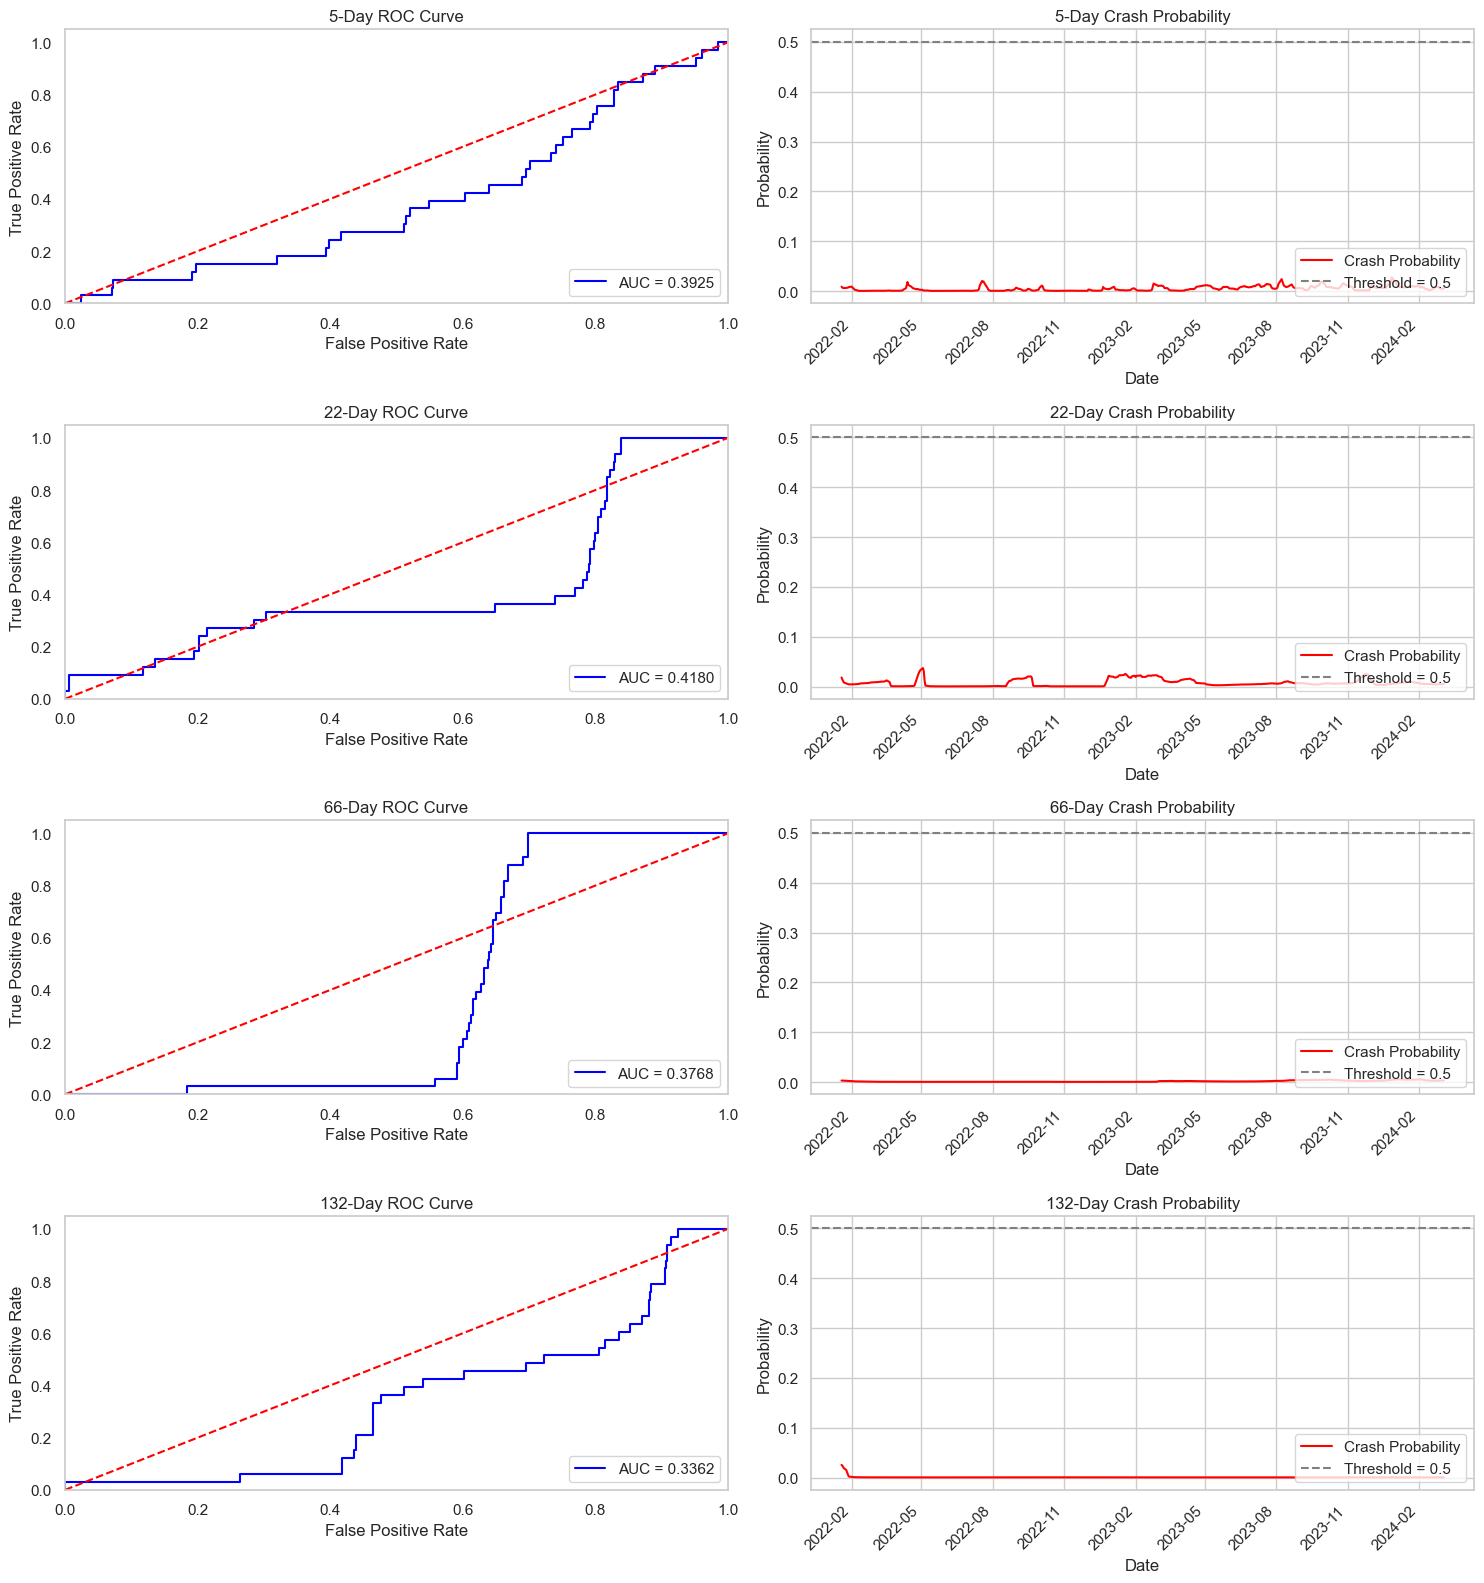

In [71]:
plot_ig_feature_attributions_grid(lstm_combined, X_test_dict, window_size=window_size)
plot_CNN_roc_and_crash_probabilities(lstm_combined, X_test_dict, y_test_dict)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


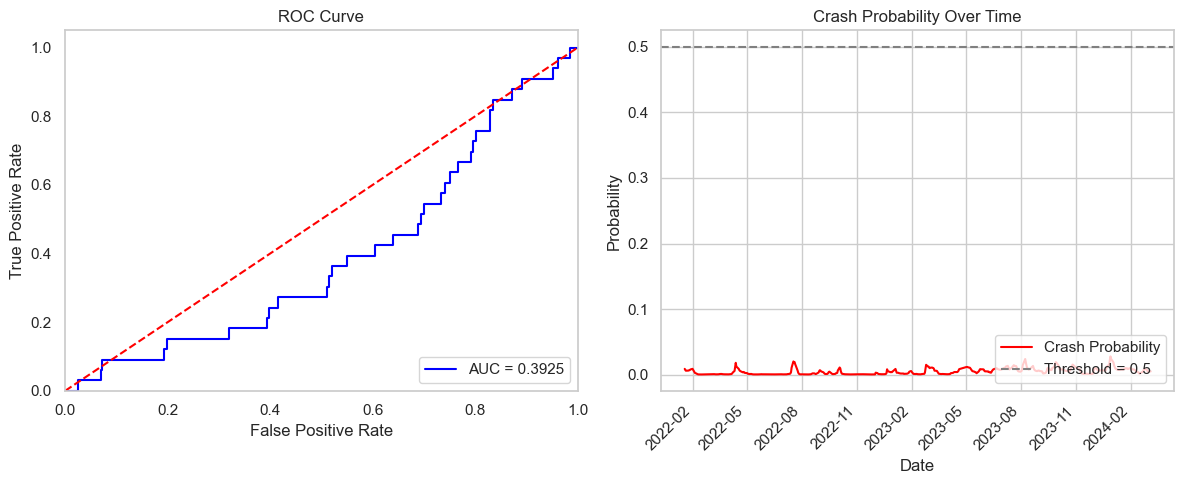

In [72]:
plot_CNN_roc_and_crash_prob_for_one(lstm_combined[5], X_test_dict[5], y_test_dict[5])

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


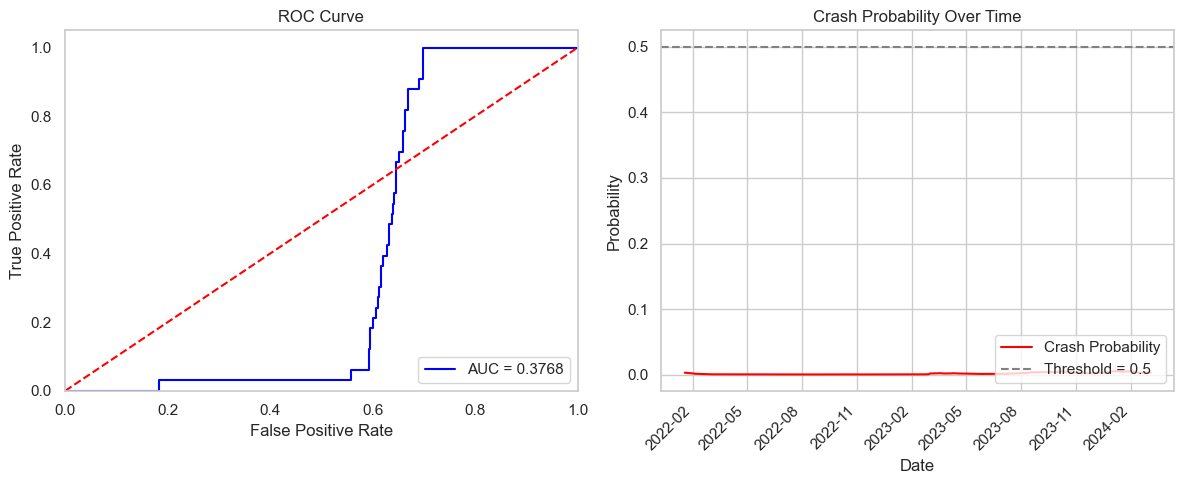

In [73]:
plot_CNN_roc_and_crash_prob_for_one(lstm_combined[66], X_test_dict[66], y_test_dict[66])

## Evaluate

In [74]:
# Summarize table of results -> Sensitivity, Specificity, Accuracy, AUC
i = 0
results_summary = []
results_dicts = [static_logit_market, static_logit_sentiment, static_logit_combined,
                 dynamic_logit_market, dynamic_logit_sentiment, dynamic_logit_combined,
                 cnn_market, cnn_sentiment, cnn_combined,
                 lstm_market, lstm_sentiment, lstm_combined]
results_dicts_name = ['Static_Logit_Market', 'Static_Logit_Sentiment', 'Static_Logit_Combined',
                      'Dynamic_Logit_Market', 'Dynamic_Logit_Sentiment', 'Dynamic_Logit_Combined',
                      'CNN_Market', 'CNN_Sentiment', 'CNN_Combined',
                      'LSTM_Market', 'LSTM_Sentiment', 'LSTM_Combined']

for results in results_dicts:
    for n in volatility_period:
        if n in results:
            res = results[n]
            auc_score = res['auc_score']
            report = res['report']
            cm = res['confusion']

            TN, FP = cm[0]
            FN, TP = cm[1]
            total = cm.sum()

            TPR = TP / (TP + FN) if (TP + FN) > 0 else 0.0  # Sensitivity
            TNR = TN / (TN + FP) if (TN + FP) > 0 else 0.0  # Specificity
            FPR = FP / (FP + TN) if (FP + TN) > 0 else 0.0
            FNR = FN / (TP + FN) if (TP + FN) > 0 else 0.0
            ACC = (TP + TN) / total
            PPV = TP / (TP + FP) if (TP + FP) > 0 else 0.0  # Precision
            FOR = FN / (FN + TN) if (FN + TN) > 0 else 0.0
            NSR = FPR / TPR if TPR > 0 else float('inf')
            f1_score = report['1']['f1-score']

        else:
            TPR = TNR = FPR = FNR = ACC = PPV = FOR = NSR = auc_score = f1_score = None

        results_summary.append({
            'model': f'{results_dicts_name[i]}_{n}',
            'TPR': np.round(TPR, 4),
            'TNR': np.round(TNR, 4),
            'FPR': np.round(FPR, 4),
            'FNR': np.round(FNR, 4),
            'PPV': np.round(PPV, 4),
            'FOR': np.round(FOR, 4),
            'NSR': np.round(NSR, 4),
            'ACC': np.round(ACC, 4),
            'AUC': np.round(auc_score, 4),
            'F1': np.round(f1_score, 4),
        })

    i += 1


# Define weighted scoring function
w_TPR, w_TNR, w_FPR, w_FNR, w_PPV, w_FOR, w_NSR, w_accuracy, w_auc_score, w_f1_score = (
    0.6, 0.3, -0.1, -0.3, 0.2, -0.1, -0.1, 0.2, 0, 0
)

def weighted_score(TPR, TNR, FPR, FNR, PPV, FOR, NSR, accuracy, 
                   w_TPR, w_TNR, w_FPR, w_FNR, w_PPV, w_FOR, w_NSR, w_accuracy, w_auc_score, w_f1_score):
    
    if None in (TPR, TNR, FPR, FNR, PPV, FOR, NSR, accuracy, auc_score, f1_score):
        return None

    return np.round(w_TPR * TPR +
            w_TNR * TNR +
            w_FPR * FPR +
            w_FNR * FNR +
            w_PPV * PPV +
            w_FOR * FOR +
            w_NSR * NSR +
            w_accuracy * accuracy, 4
            # w_auc_score * auc_score +
            # w_f1_score * f1_score, 4
            )

results_summary_df = pd.DataFrame(results_summary)
results_summary_df = results_summary_df.dropna().reset_index(drop=True)

results_summary_df['weighted_score'] = results_summary_df.apply(
    lambda row: weighted_score(row['TPR'], row['TNR'], row['FPR'], row['FNR'],
                               row['PPV'], row['FOR'], row['NSR'], row['ACC'],
                            #    row['AUC'], row['F1'],
                               w_TPR, w_TNR, w_FPR, w_FNR, w_PPV, w_FOR, w_NSR, w_accuracy, w_auc_score, w_f1_score),
    axis=1
)

results_summary_df = results_summary_df.sort_values(by='weighted_score', ascending=False).reset_index(drop=True)

# Save results to CSV
results_summary_df.to_csv('market_sentiment_crash_prediction_results_summary.csv', index=False)
results_summary_df

model     TPR     TNR     FPR     FNR     PPV  \
0     Static_Logit_Sentiment_22  0.8837  0.6525  0.3475  0.1163  0.1810   
1      Static_Logit_Combined_22  0.7907  0.6990  0.3010  0.2093  0.1858   
2             LSTM_Sentiment_22  0.7273  0.7616  0.2384  0.2727  0.1690   
3                 CNN_Market_22  0.7273  0.7515  0.2485  0.2727  0.1633   
4      Dynamic_Logit_Market_132  0.9535  0.4384  0.5616  0.0465  0.1285   
5   Dynamic_Logit_Sentiment_132  0.4884  0.9556  0.0444  0.5116  0.4884   
6              CNN_Sentiment_22  0.6667  0.7677  0.2323  0.3333  0.1606   
7     Static_Logit_Sentiment_66  0.8372  0.5394  0.4606  0.1628  0.1364   
8                LSTM_Market_66  0.9394  0.4061  0.5939  0.0606  0.0954   
9               LSTM_Market_132  0.9091  0.4222  0.5778  0.0909  0.0949   
10                CNN_Market_66  0.9394  0.3677  0.6323  0.0606  0.0901   
11               LSTM_Market_22  0.5455  0.8646  0.1354  0.4545  0.2118   
12      Static_Logit_Market_132  0.8372  0.4848  0.5152  0.1628  0.1237   
13   Static_Logit_Sentiment_132  0.3721  0.9737  0.0263  0.6279  0.5517   
14             LSTM_Combined_66  0.9697  0.3010  0.6990  0.0303  0.0847   
15     Static_Logit_Combined_66  0.9767  0.2646  0.7354  0.0233  0.1034   
16    Static_Logit_Combined_132  0.2558  0.9980  0.0020  0.7442  0.9167   
17       Static_Logit_Market_66  0.9767  0.2586  0.7414  0.0233  0.1027   
18      Dynamic_Logit_Market_22  1.0000  0.2141  0.7859  0.0000  0.0995   
19      Dynamic_Logit_Market_66  1.0000  0.1859  0.8141  0.0000  0.0964   
20                 CNN_Market_5  0.9394  0.2788  0.7212  0.0606  0.0799   
21    Dynamic_Logit_Combined_22  0.6047  0.7071  0.2929  0.3953  0.1520   
22              CNN_Combined_66  0.9697  0.1960  0.8040  0.0303  0.0744   
23       Static_Logit_Market_22  0.6279  0.6606  0.3394  0.3721  0.1385   
24   Dynamic_Logit_Combined_132  0.2558  0.9879  0.0121  0.7442  0.6471   
25              CNN_Sentiment_5  0.3939  0.9152  0.0848  0.6061  0.2364   
26              CNN_Combined_22  0.9697  0.1697  0.8303  0.0303  0.0722   
27           LSTM_Sentiment_132  0.3939  0.9091  0.0909  0.6061  0.2241   
28     Static_Logit_Sentiment_5  0.3256  0.9515  0.0485  0.6744  0.3684   
29   Dynamic_Logit_Sentiment_22  0.3953  0.8929  0.1071  0.6047  0.2429   
30      Static_Logit_Combined_5  0.3488  0.9293  0.0707  0.6512  0.3000   
31     Dynamic_Logit_Combined_5  0.6744  0.5556  0.4444  0.3256  0.1165   
32        Static_Logit_Market_5  0.8605  0.2889  0.7111  0.1395  0.0951   
33            LSTM_Sentiment_66  0.9697  0.1354  0.8646  0.0303  0.0696   
34                LSTM_Market_5  0.5758  0.6768  0.3232  0.4242  0.1061   
35             CNN_Sentiment_66  0.9697  0.1192  0.8808  0.0303  0.0684   
36             LSTM_Sentiment_5  0.2727  0.9616  0.0384  0.7273  0.3214   
37            LSTM_Combined_132  0.9697  0.0747  0.9253  0.0303  0.0653   
38             CNN_Combined_132  0.3030  0.9253  0.0747  0.6970  0.2128   
39   Dynamic_Logit_Sentiment_66  0.2093  0.9737  0.0263  0.7907  0.4091   
40              LSTM_Combined_5  0.9697  0.0141  0.9859  0.0303  0.0615   
41            CNN_Sentiment_132  0.2727  0.9172  0.0828  0.7273  0.1800   
42               CNN_Market_132  0.9697  0.0081  0.9919  0.0303  0.0612   
43    Dynamic_Logit_Sentiment_5  0.2326  0.9071  0.0929  0.7674  0.1786   
44             LSTM_Combined_22  0.0606  0.9939  0.0061  0.9394  0.4000   
45       Dynamic_Logit_Market_5  0.2791  0.8343  0.1657  0.7209  0.1277   
46    Dynamic_Logit_Combined_66  0.2326  0.8545  0.1455  0.7674  0.1220   
47               CNN_Combined_5  0.1515  0.9131  0.0869  0.8485  0.1042   

       FOR     NSR     ACC     AUC      F1  weighted_score  
0   0.0152  0.3932  0.6710  0.7582  0.3004          0.7859  
1   0.0254  0.3807  0.7063  0.7353  0.3009          0.7290  
2   0.0233  0.3278  0.7595  0.7679  0.2743          0.7098  
3   0.0236  0.3417  0.7500  0.7782  0.2667          0.7013  
4   0.0091  0.5890  0.4796  0.5920  0.2265   

In [75]:
filtered_df = results_summary_df[results_summary_df['NSR'] <= 0.34].reset_index(drop=True)
filtered_df = filtered_df[filtered_df['FNR'] <= 0.5].reset_index(drop=True)

# Sort by weighted score (descending)
filtered_df = filtered_df.sort_values(by='weighted_score', ascending=False).reset_index(drop=True)
filtered_df.to_csv('NSR_thresh_market_sentiment_crash_prediction_results_summary.csv', index=False)
filtered_df

model     TPR     TNR     FPR     FNR     PPV     FOR     NSR  \
0  LSTM_Sentiment_22  0.7273  0.7616  0.2384  0.2727  0.1690  0.0233  0.3278   
1     LSTM_Market_22  0.5455  0.8646  0.1354  0.4545  0.2118  0.0339  0.2481   

      ACC     AUC      F1  weighted_score  
0  0.7595  0.7679  0.2743          0.7098  
1  0.8447  0.8190  0.3051          0.6199

In [76]:
# Make a list of model names from the filtered DataFrame
model_names = filtered_df['model'].tolist()

# Get a list of model name in results_dicts form for plotting
# For exmaple, if model name is 'Static_Logit_Market_5', then result should be static_logit_market and n = 5
# Store as a tupple (model_type, n)
model_results = []
for model_name in model_names:
    parts = model_name.split('_')
    model_type = '_'.join(parts[:-1]).lower()  # Get the model type (e.g., static_logit_market)
    n = int(parts[-1])  # Get the n value (e.g., 5)
    model_results.append((model_type, n))

model_results

[('lstm_sentiment', 22), ('lstm_market', 22)]

In [77]:
cnn_combined = {}
X_test_dict = {}
y_test_dict = {}

for n in volatility_period:
    feature_cols = [
        f'{n}_day_sentiment_volatility',
        f'{n}_day_market_volatility',
        f'VaR_{n}',
        f'ES_{n}',
    ]

    cnn_model(n, feature_cols, market_sentiment_data, cnn_combined, X_test_dict, y_test_dict, lag=10, window_size=window_size)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Best threshold: 0.01, F1: 0.15

=== 5-Day CNN Model ===
AUC: 0.476
              precision    recall  f1-score   support

           0       0.99      0.22      0.36       495
           1       0.08      0.97      0.14        33

    accuracy                           0.27       528
   macro avg       0.53      0.59      0.25       528
weighted avg       0.93      0.27      0.34       528

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Best threshold: 0.00, F1: 0.14

=== 22-Day CNN Model ===
AUC: 0.341
              precision    recall  f1-score   support

           0       0.99      0.17      0.29       495
           1       0.07      0.97      0.13        33

    accuracy                           0.22       528
   macro avg       0.53      0.57      0.21       528
weighted avg       0.93      0.22      0.28       528

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Best threshold: 0.00, F1: 0.14

=== 66-Day CNN Model ===
AUC: 0.332
              precision   

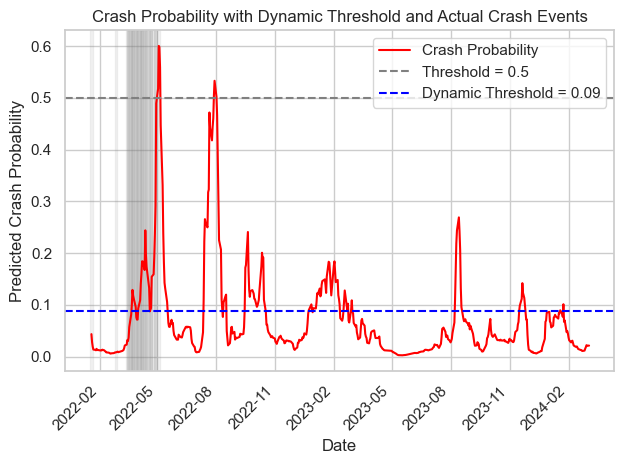

In [78]:
def plot_crash_probabilities_CNN(result):
    y_prob = result['y_prob']
    y_test_seq = result['y_test']
    date_seq = result['date_seq']
    
    df_plot = pd.DataFrame({
        'date': date_seq,
        'crash_probability': y_prob,
        'actual_crash': y_test_seq,
    })

    # --- calculate dynamic threshold ---
    precision, recall, thresholds = precision_recall_curve(y_test_seq, y_prob)
    f1_scores = 2 * precision * recall / (precision + recall + 1e-6)
    best_idx = np.argmax(f1_scores)
    # best_thresh = f1_scores[best_idx]
    best_thresh = thresholds[best_idx] if best_idx < len(thresholds) else 0.5  # Fallback to 0.5 if out of bounds

    # highlight actual crash periods
    crash_dates = df_plot[df_plot["actual_crash"] == 1]["date"]
    if not crash_dates.empty:
        for crash_date in crash_dates:
            plt.axvspan(crash_date - pd.Timedelta(days=2),
                        crash_date + pd.Timedelta(days=2),
                        color="gray", alpha=0.1)

    plt.plot(df_plot['date'], df_plot['crash_probability'], label='Crash Probability', color='red')
    plt.axhline(0.5, linestyle='--', color='gray', label='Threshold = 0.5')  # Example threshold
    plt.axhline(best_thresh, linestyle="--", color="blue", label=f"Dynamic Threshold = {best_thresh:.2f}")
    plt.title("Crash Probability with Dynamic Threshold and Actual Crash Events")
    plt.xlabel("Date")
    plt.ylabel("Predicted Crash Probability")
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
    plt.xticks(rotation=45, ha="right")
    plt.legend()
    plt.tight_layout()
    plt.grid(True)
    plt.show()

plot_crash_probabilities_CNN(cnn_sentiment[22])

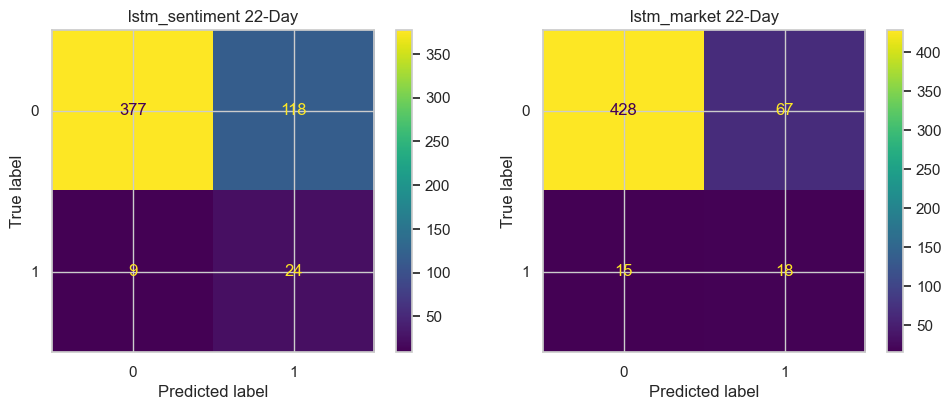

In [79]:
conf_matrices = []
titles = []
for model in model_results:
    model_type, n = model
    if model_type == 'static_logit_market':
        conf_matrices.append(static_logit_market[n]['confusion'])
    elif model_type == 'static_logit_sentiment':
        conf_matrices.append(static_logit_sentiment[n]['confusion'])
    elif model_type == 'static_logit_combined':
        conf_matrices.append(static_logit_combined[n]['confusion'])
    elif model_type == 'dynamic_logit_market':
        conf_matrices.append(dynamic_logit_market[n]['confusion'])
    elif model_type == 'dynamic_logit_sentiment':
        conf_matrices.append(dynamic_logit_sentiment[n]['confusion'])
    elif model_type == 'dynamic_logit_combined':
        conf_matrices.append(dynamic_logit_combined[n]['confusion'])
    elif model_type == 'cnn_market':
        conf_matrices.append(cnn_market[n]['confusion'])
    elif model_type == 'cnn_sentiment':
        conf_matrices.append(cnn_sentiment[n]['confusion'])
    elif model_type == 'cnn_combined':
        conf_matrices.append(cnn_combined[n]['confusion'])
    elif model_type == 'lstm_market':
        conf_matrices.append(lstm_market[n]['confusion'])
    elif model_type == 'lstm_sentiment':
        conf_matrices.append(lstm_sentiment[n]['confusion'])
    elif model_type == 'lstm_combined':
        conf_matrices.append(lstm_combined[n]['confusion'])
    titles.append(f'{model_type} {n}-Day')

plot_confusion_matrix_grid(conf_matrices, titles, ncols=2)

In [80]:
# Save the best model to use in the future
best_model = cnn_sentiment[22]

from tensorflow.keras.models import load_model
best_model['model'].save('best_model.keras')  # HDF5 format

## RF + Logit

In [81]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# --- Setup ---
RANDOM_STATE = 42

# Select features and target
features = [
    '5_day_market_volatility',
    '5_day_sentiment_volatility',
    'VaR_5',
    'ES_5',
    '22_day_market_volatility',
    '22_day_sentiment_volatility',
    'VaR_22',
    'ES_22',
    '66_day_market_volatility',
    '66_day_sentiment_volatility',
    'VaR_66',
    'ES_66',
    '132_day_market_volatility',
    '132_day_sentiment_volatility',
    'VaR_132',
    'ES_132',
]
target = 'future_crash'

# Drop NA values
df_model = market_sentiment_data.dropna(subset=features + [target]).copy()
X = df_model[features]
y = df_model[target]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=RANDOM_STATE)

# --- Step 1: Random Forest for Feature Selection ---
rf = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, class_weight='balanced', max_depth=10, min_samples_split=5, min_samples_leaf=2)
rf.fit(X_train, y_train)

# Get feature importances
feat_importances = pd.Series(rf.feature_importances_, index=features)
top_features = feat_importances.sort_values(ascending=False).head(5).index.tolist()

print("Top Features from Random Forest:")
print(top_features)

# --- Step 2: Logistic Regression with Top Features ---
X_train_top = X_train[top_features]
X_test_top = X_test[top_features]

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_top)
X_test_scaled = scaler.transform(X_test_top)

# Fit logistic regression
logit = LogisticRegression(max_iter=1000, solver='liblinear', class_weight='balanced')
logit.fit(X_train_scaled, y_train)

# Predict
y_proba = logit.predict_proba(X_test_scaled)[:, 1]
y_pred = (y_proba >= 0.5).astype(int)

# Evaluation
auc = roc_auc_score(y_test, y_proba)
report = classification_report(y_test, y_pred)

# Coefficients
coefs = pd.DataFrame({
    'Feature': top_features,
    'Coefficient': logit.coef_[0]
}).sort_values(by='Coefficient', key=abs, ascending=False)

print("\n=== Logistic Regression Results ===")
print(f"AUC: {auc:.3f}")
print(report)


Top Features from Random Forest:
['132_day_sentiment_volatility', '66_day_market_volatility', 'VaR_66', 'ES_66', '132_day_market_volatility']

=== Logistic Regression Results ===
AUC: 0.677
              precision    recall  f1-score   support

           0       0.97      0.45      0.62       647
           1       0.05      0.71      0.10        28

    accuracy                           0.46       675
   macro avg       0.51      0.58      0.36       675
weighted avg       0.94      0.46      0.60       675



In [83]:
from sklearn.metrics import recall_score, confusion_matrix, accuracy_score, mean_squared_error
import statsmodels.api as sm
import numpy as np

# Assume y_test, y_pred, y_proba, and X_train_scaled already defined
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

sensitivity = recall_score(y_test, y_pred, pos_label=1)
specificity = tn / (tn + fp)
misclass_error = 1 - accuracy_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_proba))

# McFadden's R² and AIC via statsmodels
X_train_const = sm.add_constant(X_train_scaled)
logit_model = sm.Logit(y_train, X_train_const).fit(disp=False)

mcfadden_r2 = 1 - logit_model.llf / logit_model.llnull
aic = logit_model.aic

print("Sensitivity (Recall for 1):", round(sensitivity, 3))
print("Specificity (True Negative Rate):", round(specificity, 3))
print("Misclassification Error:", round(misclass_error, 3))
print("RMSE:", round(rmse, 3))
print("McFadden Pseudo R²:", round(mcfadden_r2, 3))
print("AIC:", round(aic, 2))

Sensitivity (Recall for 1): 0.714
Specificity (True Negative Rate): 0.451
Misclassification Error: 0.538
RMSE: 0.496
McFadden Pseudo R²: 0.028
AIC: 928.19
